# Objectif


# Etude du petit déjeuner: importer et selectionner les données

In [6]:
# Importer les données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
! pip install openpyxl

recettes_aliments = pd.read_excel("./Details_recettes.xlsx", engine='openpyxl')
liste_ingr = pd.read_excel("./Liste_ingredients.xlsx", engine='openpyxl')

#il y a 3 tables de données: les consommations des 7 jours, les individus et la nomenclature des aliments.
conso = pd.read_csv("./Table_conso.csv", encoding = "ISO-8859-1", sep=';')
indiv= pd.read_csv("./Table_indiv.csv", encoding = "ISO-8859-1",  sep=';', low_memory=False)
nomenc= pd.read_csv("./Nomenclature_3.csv", encoding = "ISO-8859-1",  sep=';')

In [7]:
# Sélectionner les colonnes d'intérêt pour les consommations (numéro d'indiv, numéro du jour de la semaine, 
# type de repas, code groupe aliment, code sous groupe aliment, code aliment)
conso=conso[["nomen", "nojour", "tyrep", "codgr", "sougr", "codal"]]

# Nombre de valeurs manquantes
print("donnees manquantes dans le tableau des consommations\n", conso.isnull().sum())

donnees manquantes dans le tableau des consommations
 nomen     0
nojour    0
tyrep     0
codgr     0
sougr     0
codal     0
dtype: int64


In [8]:
#on crée un dictionnaire pour associer un code d'aliment (codal) au libellé de l'aliment (libal)) 
dic_alim={}
for i in range(nomenc.shape[0]):
    dic_alim[nomenc.codal[i]]=nomenc.libal[i]
#print(dic_alim)

# on crée un dictionnaire pour associer un code de groupe d'aliment (codgr) au libellé du groupe d'aliment (libgr)
groups=nomenc[["codgr", "libgr"]]
groups = groups.drop_duplicates()   
groups.reset_index(drop=True, inplace=True)
#groups.info()

dic_group={}
for i in range(groups.shape[0]):
    dic_group[groups.codgr[i]]=groups.libgr[i]
# print(dic_group)

#on crée un dictionnaire pour associer un code d'aliment (codal) au code du groupe d'aliment (codgr)) 
dic_alim_group={}
for i in range(nomenc.shape[0]):
    dic_alim_group[nomenc.codal[i]]=nomenc.codgr[i]
print(dic_alim_group)

{7001: 1, 7004: 1, 7012: 1, 7100: 1, 7110: 1, 7125: 1, 7126: 1, 7160: 1, 7200: 1, 7225: 1, 7255: 1, 90003: 1, 91123: 1, 92031: 1, 7300: 1, 7310: 1, 7330: 1, 7340: 1, 7400: 1, 7411: 1, 7425: 1, 92030: 1, 7430: 1, 7500: 1, 7812: 1, 32000: 2, 32002: 2, 32003: 2, 32005: 2, 32006: 2, 32021: 2, 32121: 2, 32133: 2, 32001: 2, 32009: 2, 32016: 2, 32022: 2, 32112: 2, 32115: 2, 32131: 2, 32135: 2, 32023: 2, 32110: 2, 32111: 2, 32113: 2, 32123: 2, 32004: 2, 32018: 2, 90032: 2, 9811: 3, 9822: 3, 9871: 3, 23412: 3, 23422: 3, 9081: 4, 9683: 4, 9103: 4, 9104: 4, 9105: 4, 9230: 5, 9313: 5, 9615: 5, 9660: 5, 7601: 6, 7615: 6, 7620: 6, 7650: 6, 7710: 6, 7720: 6, 7730: 6, 7740: 6, 7741: 6, 23480: 6, 24660: 6, 92510: 6, 24000: 7, 24002: 7, 24003: 7, 24015: 7, 24016: 7, 24031: 7, 24034: 7, 24036: 7, 24037: 7, 24038: 7, 24049: 7, 24231: 7, 24310: 7, 24320: 7, 24430: 7, 24441: 7, 24615: 7, 24659: 7, 24678: 7, 24684: 7, 92033: 7, 4004: 7, 38105: 7, 38106: 7, 38400: 7, 38401: 7, 38402: 7, 38403: 7, 31100: 7, 31

In [9]:
#Sélectionner les colonnes d'intérêt pour individus (numéro d'indiv, sexe, catégorie d'age)
indiv=indiv[["nomen", "sexe_ps", "tage"]]

#Merger consommations et individus pour ne conserver que les consommations des adultes 
conso_indiv=pd.merge(conso, indiv)
conso_indiv.head()

#ne conserver que les adultes (18 ans et plus)
conso_indiv=conso_indiv[(conso_indiv.tage!=1) & (conso_indiv.tage!=2)  & (conso_indiv.tage!=3)]
conso_indiv.info()
print("nombre d'adultes:", len(conso_indiv["nomen"].unique()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372825 entries, 0 to 372824
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   nomen    372825 non-null  int64
 1   nojour   372825 non-null  int64
 2   tyrep    372825 non-null  int64
 3   codgr    372825 non-null  int64
 4   sougr    372825 non-null  int64
 5   codal    372825 non-null  int64
 6   sexe_ps  372825 non-null  int64
 7   tage     372825 non-null  int64
dtypes: int64(8)
memory usage: 25.6 MB
nombre d'adultes: 2624


In [10]:
#Ajouter le libellé des aliments et des groupes d'aliments dans la table des consommations 

conso_indiv_alim=conso_indiv.assign(Aliment=np.nan, Groupe_Aliment=np.nan)

for i in range(conso_indiv_alim.shape[0]):
    conso_indiv_alim.Aliment[i]=dic_alim.get(conso_indiv_alim.codal[i])
    conso_indiv_alim.Groupe_Aliment[i]=dic_group.get(conso_indiv_alim.codgr[i])
conso_indiv_alim.head()

C:\Users\jacqueno\AppData\Local\Temp\ipykernel_58860\2223274028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_indiv_alim.Aliment[i]=dic_alim.get(conso_indiv_alim.codal[i])
C:\Users\jacqueno\AppData\Local\Temp\ipykernel_58860\2223274028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_indiv_alim.Groupe_Aliment[i]=dic_group.get(conso_indiv_alim.codgr[i])


nomen  nojour  tyrep  codgr  sougr  codal  sexe_ps  tage  \
0  110006       6      1     34     99  18151        2     7   
1  110006       6      1     30      1  31076        2     7   
2  110006       6      1      1      1   7001        2     7   
3  110006       6      1     15     99  16632        2     7   
4  110006       6      3     21      1  26039        2     7   

                                             Aliment  \
0  café au lait ou café crème ou cappuccino non s...   
1                       sucre allégé type tutti free   
2                                      pain baguette   
3                    matière grasse allégée 60% m.g.   
4                thon au naturel en conserve égoutté   

               Groupe_Aliment  
0                        café  
1           sucres et dérivés  
2  pain et panification sèche  
3                   margarine  
4                    poissons

In [11]:
#Créer les séquences des petits déjeuners de la semaine pour chaque individu 
conso_pdj0=conso_indiv_alim[conso_indiv_alim.tyrep==1]
conso_pdj1=conso_pdj0.sort_values(['nomen', 'nojour'], ascending =[True, True])
conso_pdj1.head()

nomen  nojour  tyrep  codgr  sougr  codal  sexe_ps  tage  \
60  110006       1      1     34     99  18151        2     7   
61  110006       1      1     30      1  31076        2     7   
62  110006       1      1      1      1   7001        2     7   
63  110006       1      1     15     99  16632        2     7   
80  110006       2      1     34     99  18151        2     7   

                                              Aliment  \
60  café au lait ou café crème ou cappuccino non s...   
61                       sucre allégé type tutti free   
62                                      pain baguette   
63                    matière grasse allégée 60% m.g.   
80  café au lait ou café crème ou cappuccino non s...   

                Groupe_Aliment  
60                        café  
61           sucres et dérivés  
62  pain et panification sèche  
63                   margarine  
80                        café

In [15]:
# Créer la liste des alimenconso_pdj1ts du petit déjeuner
liste_code_al_pdj=(conso_pdj1.codal.unique()).tolist()
print("nombre d'aliments differents au pjd:", len(liste_code_al_pdj))
print(liste_code_al_pdj)
liste_al_pdj=[]
for i in liste_code_al_pdj:
    liste_al_pdj.append(dic_alim[i])
print(liste_al_pdj)


nombre d'aliments differents au pjd: 630
[18151, 31076, 7001, 16632, 18004, 31016, 7100, 76057, 16727, 76050, 7330, 18020, 31006, 7812, 16415, 7740, 7310, 16400, 31038, 18150, 18066, 18008, 13024, 19041, 7601, 92031, 92034, 81052, 7012, 2069, 76022, 13034, 7110, 16701, 13042, 7300, 19600, 31008, 32003, 19624, 7400, 12009, 31019, 23950, 31024, 2012, 7730, 2035, 76075, 7004, 2027, 2015, 24036, 16402, 13039, 19050, 7741, 31037, 13005, 18104, 7225, 7200, 28727, 12310, 22501, 23585, 76056, 2013, 19602, 13108, 32004, 31017, 13038, 24015, 13009, 13134, 81067, 13040, 31004, 16730, 19760, 90003, 7620, 23467, 16403, 31039, 2070, 18073, 76016, 2061, 24049, 2002, 24002, 19042, 2014, 19740, 23684, 24678, 23121, 2025, 18045, 12500, 19585, 92026, 32005, 23081, 32021, 19606, 13049, 92018, 16412, 2004, 76020, 19510, 19122, 18005, 2074, 2034, 32000, 76052, 18101, 92030, 31032, 32016, 76025, 7340, 31110, 32123, 38402, 15010, 18102, 32009, 19640, 19730, 32006, 18900, 19801, 19765, 32113, 7125, 19628, 3200

In [16]:
#Créer les séquences des aliments d'un petit déjeuner par individu sous forme d'un dictionnaire
   
d = {}
for index, row in conso_pdj1.iterrows():
    d.setdefault(row.nomen, {}).setdefault(row.nojour, []).append(row.codal)
print(d)

{110006: {1: [18151, 31076, 7001, 16632], 2: [18151, 31076, 7001, 16632], 3: [18151, 31076, 7001, 16632], 4: [18151, 31076, 7001, 16632], 5: [18151, 31076, 7001, 16632], 6: [18151, 31076, 7001, 16632], 7: [18151, 31076, 7001, 16632]}, 110007: {1: [18004, 31016, 7100, 76057, 16727], 2: [18004, 31016, 7100, 76057, 16727], 3: [18004, 7100, 31016, 76050, 16727], 4: [18004, 31016, 7100, 76050, 16727], 5: [18004, 31016, 7100, 16727, 76057], 6: [18004, 7330, 31016, 76057], 7: [18004, 7330, 31016, 76057]}, 110020: {1: [18020, 31076, 7001, 31006], 2: [18020, 7812, 16415, 31076], 3: [18020, 7001, 31006, 31076], 4: [18020, 31076, 7001, 31006], 5: [18020, 31076, 7001, 31006], 6: [7001, 31006, 18020, 31076], 7: [18020, 31076, 7740]}, 110021: {1: [7310, 16400, 31038, 18150, 18066, 18008, 13024], 2: [7310, 16400, 31006, 18150, 18066, 18008, 13024], 3: [7310, 16400, 31038, 18150, 18066, 18008, 13024], 4: [7310, 16400, 31006, 18150, 18066, 18008, 13024], 5: [7310, 16400, 31006, 18150, 18066, 18008], 6:

# Entrainer word2vec sur les séquences des aliments de chaque petit déjeuner (une phrase= 1 PDJ)

In [17]:
# !pip install gensim

import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [18]:
# Sequences des PDJ
PDJ_liste=[]
for cle, valeur in d.items():
    for sous_valeur in valeur.values():
        PDJ_liste.append(sous_valeur)

print(PDJ_liste)

[[18151, 31076, 7001, 16632], [18151, 31076, 7001, 16632], [18151, 31076, 7001, 16632], [18151, 31076, 7001, 16632], [18151, 31076, 7001, 16632], [18151, 31076, 7001, 16632], [18151, 31076, 7001, 16632], [18004, 31016, 7100, 76057, 16727], [18004, 31016, 7100, 76057, 16727], [18004, 7100, 31016, 76050, 16727], [18004, 31016, 7100, 76050, 16727], [18004, 31016, 7100, 16727, 76057], [18004, 7330, 31016, 76057], [18004, 7330, 31016, 76057], [18020, 31076, 7001, 31006], [18020, 7812, 16415, 31076], [18020, 7001, 31006, 31076], [18020, 31076, 7001, 31006], [18020, 31076, 7001, 31006], [7001, 31006, 18020, 31076], [18020, 31076, 7740], [7310, 16400, 31038, 18150, 18066, 18008, 13024], [7310, 16400, 31006, 18150, 18066, 18008, 13024], [7310, 16400, 31038, 18150, 18066, 18008, 13024], [7310, 16400, 31006, 18150, 18066, 18008, 13024], [7310, 16400, 31006, 18150, 18066, 18008], [7310, 16400, 31006, 18150, 18066, 18008], [7310, 16400, 18150, 18066, 31006, 18008], [18004, 19041, 31016, 7601, 18066

In [19]:
nb_alim_pdj=[]
for i in range(len(PDJ_liste)):
    nb_alim_pdj.append(len(PDJ_liste[i]))
    
#Nombre d'aliments max consommées par un individu en 1 PDJ
print("nombre max:", max(nb_alim_pdj))
#Nombre moyen d'aliments consommées par un individu en 1 PDJ
print("nombre moyen:", sum(nb_alim_pdj)/len(nb_alim_pdj))

nombre max: 18
nombre moyen: 4.184985802177


In [107]:
# w2v_cbow_pdj= gensim.models.word2vec.Word2Vec(sentences=PDJ_liste,
#                                 vector_size=10, window=18,     ### here we train a cbow model 
#                                 min_count=5,                      
#                                 sample=0.001, workers=3,
#                                 sg=0, hs=0, negative=5,        ### set sg to 1 to train a sg model
#                                 cbow_mean=1, epochs=1000)

# Représenter les ALIMENTS du PDJ appris avec W2V dans un espace en 2 dimensions (TSNE)

In [108]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def tsne_plot(model):
#     "Creates and TSNE model and plots it"
#     labels = []
#     alim = []

#     for e in liste_code_al_pdj:
#         if e in model.wv:
#             alim.append(model.wv[e])
#             labels.append(dic_alim[e])
#     alim2=np.array(alim)
    
#     tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
#     new_values = tsne_model.fit_transform(alim2)

#     x = []
#     y = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
        
#     plt.figure(figsize=(20, 20)) 
#     plt.rc('font', size=15)
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
#     plt.show()
 
# tsne_plot(w2v_cbow_pdj) 

In [20]:
# Créer un dictionnaire qui contient tous les aliments des 7 PDJ par individu 
d_indiv = {}
for index, row in conso_pdj1.iterrows():
    d_indiv.setdefault(row.nomen, []).append(row.codal)
print(d_indiv)

{110006: [18151, 31076, 7001, 16632, 18151, 31076, 7001, 16632, 18151, 31076, 7001, 16632, 18151, 31076, 7001, 16632, 18151, 31076, 7001, 16632, 18151, 31076, 7001, 16632, 18151, 31076, 7001, 16632], 110007: [18004, 31016, 7100, 76057, 16727, 18004, 31016, 7100, 76057, 16727, 18004, 7100, 31016, 76050, 16727, 18004, 31016, 7100, 76050, 16727, 18004, 31016, 7100, 16727, 76057, 18004, 7330, 31016, 76057, 18004, 7330, 31016, 76057], 110020: [18020, 31076, 7001, 31006, 18020, 7812, 16415, 31076, 18020, 7001, 31006, 31076, 18020, 31076, 7001, 31006, 18020, 31076, 7001, 31006, 7001, 31006, 18020, 31076, 18020, 31076, 7740], 110021: [7310, 16400, 31038, 18150, 18066, 18008, 13024, 7310, 16400, 31006, 18150, 18066, 18008, 13024, 7310, 16400, 31038, 18150, 18066, 18008, 13024, 7310, 16400, 31006, 18150, 18066, 18008, 13024, 7310, 16400, 31006, 18150, 18066, 18008, 7310, 16400, 31006, 18150, 18066, 18008, 7310, 16400, 18150, 18066, 31006, 18008], 110025: [18004, 19041, 31016, 7601, 18066, 18004,

In [22]:
# Créer un dictionnaire qui contient le nombre d'individus qui ont consommé au moins une fois l'aliment au pdj, 
# pour chaque aliment du pdj 
d_freq_alim={}

for e in liste_code_al_pdj:
    d_freq_alim[e]=0
    for i in d_indiv.keys():
        if e in d_indiv[i]:
            d_freq_alim[e]=d_freq_alim[e]+1

# Exclure les aliments rares

In [25]:
# Identifier les aliments consommés par plus de 3%  et moins de 3% des individus au pdj
Alim_non_rare=[]
Alim_rare=[]
for e in liste_code_al_pdj:
    if d_freq_alim[e]>75:
        Alim_non_rare.append(e)
    elif d_freq_alim[e]<76:
        Alim_rare.append(e)
        
print("Nb d'aliments fréquemment consommés:", len(Alim_non_rare))
print("Nb d'aliments rarement consommés:", len(Alim_rare))

Nb d'aliments fréquemment consommés: 55
Nb d'aliments rarement consommés: 575


In [26]:
for i in Alim_non_rare:
    print(i, dic_alim[i])

18151 café au lait ou café crème ou cappuccino non sucré
7001 pain baguette
16632 matière grasse allégée 60% m.g.
18004 café noir prêt à boire non sucré
31016 sucre blanc
7100 pain de campagne ou bis
16727 matière grasse allégée 55-60% m.g. riche en oméga 3 et 6
18020 thé infusé non sucré
31006 confiture ou marmelade tout type
7740 brioche industrielle préemballée
16400 beurre doux
18150 poudre soluble à base de chicorée et de café type ricoré
18066 eau du robinet
18008 eau de source
13024 clémentine ou mandarine fraîche
19041 lait demi-écrémé uht
7601 croissant sans précision
81052 sucre blanc ajouté au service
7012 pain courant français boule à la levure
13034 orange fraîche
7110 pain complet ou intégral artisanal
7300 biscotte classique type heudebert lu
19600 yaourt ou spécialité laitière nature
31008 miel
31019 édulcorant à l'aspartame
31024 confiture de fraise
2012 jus d'orange à base de concentré pasteurisé
7730 pain au chocolat feuilleté artisanal
7004 pain grillé maison
16402 

In [27]:
for i in Alim_rare:
    print(i, dic_alim[i])

31076 sucre allégé type tutti free
76057 volvic eau plate
76050 thonon eau plate
7330 biscotte multicéréales type heudebert aux six céréales
7812 fougasse garnie
16415 beurre doux léger 39-41% m.g.
7310 biscotte sans adjonction de sel
31038 confiture de cerise
92031 autre pain
92034 autre gâteau
2069 cocktail de jus de fruits à base de concentré pasteurisé
76022 hépar eau plate
16701 matière grasse composée allégée 60% m.g. type le fleurier ou tartine et cuisine
13042 pruneau sec
32003 céréales sucrées sans précision
19624 yaourt ou spécialité laitière sans précision
7400 pain grillé au froment type tranches pain grillé pelletier lu braisotte jacquet
12009 fromage à pâte molle à croûte fleurie genre camembert allégé 20-30% m.g.
23950 muffin
2035 cocktail de purs jus de fruits pasteurisé
76075 san pellegrino eau gazeuse
2027 pur jus de pamplemousse pasteurisé
2015 jus de pamplemousse à base de concentré pasteurisé
24036 biscuit sec au chocolat sans précision
18104 boisson instantanée ca

In [29]:
# Enlever les PDJ qui contiennent les aliments rares

d_new = {}

for key, value in d.items():
    new_value = {}
    for subkey, sublist in value.items():
        if not any(e in sublist for e in Alim_rare):
            new_value[subkey] = sublist
    d_new[key] = new_value
    
print("longueur du dic:", len(d_new))
print(d_new)


longueur du dic: 2584
{110006: {}, 110007: {}, 110020: {}, 110021: {}, 110025: {1: [18004, 19041, 31016, 7601, 18066], 2: [18004, 19041, 31016, 7601, 18066], 3: [18004, 19041, 31016, 7001, 16632, 18066]}, 110034: {}, 110046: {}, 110057: {}, 110067: {2: [18004, 7601, 2012, 31016], 3: [18004, 7601, 31016, 2012], 4: [18004, 31016, 7601, 2012], 5: [18004, 31016, 7601, 2012], 6: [18004, 31016, 7601, 2012]}, 110071: {1: [18004, 18066, 81052], 2: [18004, 7001, 31008, 16400, 81052], 3: [18004, 7001, 18066, 16400, 31008, 81052], 4: [18004, 81052], 5: [18004, 81052], 6: [18004, 18066, 81052], 7: [18004, 81052]}, 110081: {}, 110110: {2: [18020, 19041], 3: [18020, 19041, 7001, 16402, 31008], 4: [18020, 19041], 5: [18020, 19041], 6: [18020, 19041], 7: [18020, 19041, 13039]}, 110113: {1: [19041, 7001, 31006, 18150], 2: [19050, 18150, 7001, 31006], 3: [19050, 18150, 7001, 31006], 4: [19050, 18150], 5: [19050, 7741], 6: [19050, 7741], 7: [19041, 7001, 31006]}, 110125: {5: [13005, 13039, 18066], 7: [71

In [30]:
# Sequences des PDJ qui ne contiennent pas les aliments rares

PDJ_alimfreqliste=[]
for cle, valeur in d_new.items():
    for sous_valeur in valeur.values():
        PDJ_alimfreqliste.append(sous_valeur)

print(PDJ_alimfreqliste)


[[18004, 19041, 31016, 7601, 18066], [18004, 19041, 31016, 7601, 18066], [18004, 19041, 31016, 7001, 16632, 18066], [18004, 7601, 2012, 31016], [18004, 7601, 31016, 2012], [18004, 31016, 7601, 2012], [18004, 31016, 7601, 2012], [18004, 31016, 7601, 2012], [18004, 18066, 81052], [18004, 7001, 31008, 16400, 81052], [18004, 7001, 18066, 16400, 31008, 81052], [18004, 81052], [18004, 81052], [18004, 18066, 81052], [18004, 81052], [18020, 19041], [18020, 19041, 7001, 16402, 31008], [18020, 19041], [18020, 19041], [18020, 19041], [18020, 19041, 13039], [19041, 7001, 31006, 18150], [19050, 18150, 7001, 31006], [19050, 18150, 7001, 31006], [19050, 18150], [19050, 7741], [19050, 7741], [19041, 7001, 31006], [13005, 13039, 18066], [7100, 16402, 18020, 31016], [7001, 31037, 2013, 18004, 18066], [18004, 81052], [18004, 81052], [18004, 81052], [18004, 7620, 31006], [18004, 19041, 7620, 31006], [18004, 19041, 7620, 31006], [18004, 19041, 7100, 31006], [18004, 19041, 31006], [18151, 81052], [18151, 31

In [31]:
# Imprimer quelques petits déjeuners pour avoir une idée 

for i in range(len(PDJ_alimfreqliste[:20])):
    for j in range(len(PDJ_alimfreqliste[i])):
        print(dic_alim[PDJ_alimfreqliste[i][j]])
    print("\t", "dej suivant:")

café noir prêt à boire non sucré
lait demi-écrémé uht
sucre blanc
croissant sans précision
eau du robinet
	 dej suivant:
café noir prêt à boire non sucré
lait demi-écrémé uht
sucre blanc
croissant sans précision
eau du robinet
	 dej suivant:
café noir prêt à boire non sucré
lait demi-écrémé uht
sucre blanc
pain baguette
matière grasse allégée 60% m.g.
eau du robinet
	 dej suivant:
café noir prêt à boire non sucré
croissant sans précision
jus d'orange à base de concentré pasteurisé
sucre blanc
	 dej suivant:
café noir prêt à boire non sucré
croissant sans précision
sucre blanc
jus d'orange à base de concentré pasteurisé
	 dej suivant:
café noir prêt à boire non sucré
sucre blanc
croissant sans précision
jus d'orange à base de concentré pasteurisé
	 dej suivant:
café noir prêt à boire non sucré
sucre blanc
croissant sans précision
jus d'orange à base de concentré pasteurisé
	 dej suivant:
café noir prêt à boire non sucré
sucre blanc
croissant sans précision
jus d'orange à base de concent

In [32]:
# Nombre max et moyen d'aliments après avoir enlevé les aliments rares

nb_alim_pdj=[]
for i in range(len(PDJ_alimfreqliste)):
    nb_alim_pdj.append(len(PDJ_alimfreqliste[i]))
# Nombre d'aliments max consommées par un individu en 1 PDJ
print("nombre max:", max(nb_alim_pdj))
# Nombre moyen d'aliments consommées par un individu en 1 PDJ
print("nombre moyen:", sum(nb_alim_pdj)/len(nb_alim_pdj))

nombre max: 11
nombre moyen: 3.6488200964222277


In [118]:
# w2v_cbow_pdj_freq= gensim.models.word2vec.Word2Vec(sentences=PDJ_alimfreqliste,
#                                 vector_size=10, window=11,     ### here we train a cbow model 
#                                 min_count=5,                      
#                                 sample=0.001, workers=3,
#                                 sg=0, hs=0, negative=5,        ### set sg to 1 to train a sg model
#                                 cbow_mean=1, epochs=1000)

import tempfile

# with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
#     temporary_filepath = tmp.name
#     w2v_cbow_pdj_freq.save(temporary_filepath)
    
#The model is now safely stored in the filepath.
  

In [33]:
    # To load a saved model:
    w2v_cbow_pdj_freq_load = gensim.models.Word2Vec.load("./gensim-model-ixldv1es")

2023-07-26 17:35:22,847 : INFO : loading Word2Vec object from ./gensim-model-ixldv1es
2023-07-26 17:35:22,856 : INFO : loading wv recursively from ./gensim-model-ixldv1es.wv.* with mmap=None
2023-07-26 17:35:22,857 : INFO : setting ignored attribute cum_table to None
2023-07-26 17:35:22,858 : INFO : Word2Vec lifecycle event {'fname': './gensim-model-ixldv1es', 'datetime': '2023-07-26T17:35:22.858749', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}


# Représenter les ALIMENTS NON RARES du PDJ appris avec W2V dans un espace en 2 dimensions (TSNE)

In [34]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    alim = []
    i=0
    
    for e in liste_code_al_pdj:
        if e in model.wv:
            alim.append(model.wv[e])
            labels.append(dic_alim[e])
            i+=1
    alim2=np.array(alim)

    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
    new_values = tsne_model.fit_transform(alim2)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    plt.rc('font', size=15)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig("w2v_pdj_freq.jpg")
    plt.show()
    print(i)
    
    
tsne_plot(w2v_cbow_pdj_freq_load) 


55


In [35]:
#On génère toutes les combinaisons possibles de 2 élements parmi les aliments
import random
randoo_liste=[]
numbers = Alim_non_rare
for i in (range(len(Alim_non_rare))):
    random_numbers = random.sample(numbers, 2)
    randoo_liste.append(random_numbers)
# print(randoo_liste)

In [36]:
rand_liste=[[7740, 13005], [18071, 7601], [7012, 13024], [92030, 24231], [18004, 16727], [7200, 7100], 
            [7740, 7255], [31019, 16727], [2004, 18004], [18005, 19050], [31006, 18073], [31006, 18008], 
            [16632, 31016], [31110, 16400], [31017, 16730], [19050, 7001], [19041, 7200], [31110, 7255], 
            [18073, 92030], [18151, 7110], [18008, 19041], [7001, 18071], [2070, 31019], [7740, 31024], 
            [18150, 24231], [2004, 7200], [18005, 19041], [18066, 7300], [7740, 13039], [18150, 24231], 
            [24630, 2012], [7255, 7620], [7200, 24231], [18071, 31032], [19050, 7741], [18073, 16412], 
            [31110, 18073], [7110, 7100], [13005, 16727], [19600, 31024], [81052, 18071], [7730, 2013], 
            [31037, 16632], [7001, 18101], [7001, 31037], [81052, 18008], [7012, 31008], [7012, 2013], 
            [18005, 2070], [13034, 31008], [18020, 16412], [7710, 2004], [7620, 7110], [16402, 16632], [7100, 7012]]
#On crée un dataframe vide avec comme colonnes le code des ingrédients, le nom des aliments (INCA) 
# la distance entre les aliments dans W2V INCA, 
D_alim= pd.DataFrame(columns=['Code_A1','Code_A2','Nom_A1_inca','Nom_A2_inca','Dist_inca'], index = range(len(rand_liste)))

#préciser le modèle W2V appris sur INCA 
model=w2v_cbow_pdj_freq_load
for i in range(len(rand_liste)):
    D_alim.Code_A1[i]=rand_liste[i][0]
    D_alim.Code_A2[i]=rand_liste[i][1]
    D_alim.Nom_A1_inca[i]=dic_alim[D_alim.Code_A1[i]]
    D_alim.Nom_A2_inca[i]=dic_alim[D_alim.Code_A2[i]]
    if (D_alim.Code_A1[i] in model.wv) and (D_alim.Code_A2[i] in model.wv):
        D_alim.Dist_inca[i]=round(model.wv.similarity(D_alim.Code_A1[i], D_alim.Code_A2[i]),2)
D_alim=D_alim.sort_values('Dist_inca', ascending=False)

distmin=D_alim["Dist_inca"].min()
distmax=D_alim["Dist_inca"].max()
print("similarité min:", distmin, "\n", "similarité max:", distmax)

D_alim

similarité min: -0.56 
 similarité max: 0.97


Code_A1 Code_A2                                        Nom_A1_inca  \
37    7110    7100                 pain complet ou intégral artisanal   
54    7100    7012                            pain de campagne ou bis   
53   16402   16632                        beurre demi-sel sel maxi 3%   
5     7200    7100                                        pain de mie   
6     7740    7255                   brioche industrielle préemballée   
31    7255    7620                        pain aux céréales artisanal   
52    7620    7110                      croissant au beurre artisanal   
36   31110   18073                                  confiture allégée   
35   18073   16412    café soluble reconstitué prêt à boire non sucré   
32    7200   24231                                        pain de mie   
11   31006   18008                   confiture ou marmelade tout type   
38   13005   16727                                     banane fraîche   
45   81052   18008                      sucre blanc ajouté au service   
3    92030   24231                                     autre biscotte   
39   19600   31024               yaourt ou spécialité laitière nature   
27   18066    7300                                     eau du robinet   
47    7012    2013            pain courant français boule à la levure   
50   18020   16412                               thé infusé non sucré   
22    2070   31019                        pur jus d'orange pasteurisé   
20   18008   19041                                      eau de source   
49   13034   31008                                     orange fraîche   
8     2004   18004                       jus de fruits sans précision   
33   18071   31032                            café expresso non sucré   
15   19050    7001                                    lait écrémé uht   
1    18071    7601                            café expresso non sucré   
29   18150   24231  poudre soluble à base de chicorée et de café t...   
24   18150   24231  poudre soluble à base de chicorée et de café t...   
18   18073   92030    café soluble reconstitué prêt à boire non sucré   
10   31006   18073                   confiture ou marmelade tout type   
17   31110    7255                                  confiture allégée   
4    18004   16727                   café noir prêt à boire non sucré   
14   31017   16730                                         sucre roux   
16   19041    7200                               lait demi-écrémé uht   
2     7012   13024            pain courant français boule à la levure   
28    7740   13039                   brioche industrielle préemballée   
42   31037   16632                                confiture d'abricot   
0     7740   13005                   brioche industrielle préemballée   
21    7001   18071                                      pain baguette   
26   18005   19041                             café soluble en poudre   
43    7001   18101                                      pain baguette   
19   18151    7110  café au lait ou café crème ou cappuccino non s...   
7    31019   16727                           édulcorant à l'aspartame   
13   31110   16400                                  confiture allégée   
46    7012   31008            pain courant français boule à la levure   
44    7001   31037                                      pain baguette   
48   18005    2070                             café soluble en poudre   
9    18005   19050                             café soluble en poudre   
25    2004    7200                       jus de fruits sans précision   
23    7740   31024                   brioche industrielle préemballée   
12   16632   31016                    matière grasse allégée 60% m.g.   
34   19050    7741                                    lait écrémé uht   
41    7730    2013               pain au chocolat feuilleté artisanal   
51    7710    2004                             pain au lait artisanal   
30   24630    2012                                          m

In [37]:
#on regarde les aliments du PDJ dont la simiarité est >0.5 

D_alim2 = pd.DataFrame(columns=['Code_A1','Code_A2','Nom_A1_inca','Nom_A2_inca', 
                               'Dist_inca'], index = range((len(Alim_non_rare))**2))

pd.set_option('display.max_rows', None)

#préciser le modèle W2V appris sur INCA 
model=w2v_cbow_pdj_freq_load

i=0
for j in range(len(Alim_non_rare)):
    for k in range(len(Alim_non_rare)):
        D_alim2.Code_A1[i]=Alim_non_rare[k]
        D_alim2.Code_A2[i]=Alim_non_rare[j]
        if (D_alim2.Code_A1[i] in model.wv) and (D_alim2.Code_A2[i] in model.wv):
            if model.wv.similarity(D_alim2.Code_A1[i],D_alim2.Code_A2[i])>0.5: 
                D_alim2.Dist_inca[i]=model.wv.similarity(D_alim2.Code_A1[i], D_alim2.Code_A2[i])
                D_alim2.Nom_A1_inca[i]=dic_alim[D_alim2.Code_A1[i]]
                D_alim2.Nom_A2_inca[i]=dic_alim[D_alim2.Code_A2[i]]
        i+=1
              
Distnotnull=D_alim2[D_alim2["Dist_inca"].notnull()]
Dist_diff_alim=Distnotnull[Distnotnull.Code_A1 != Distnotnull.Code_A2]
Dist_diff_alim.reset_index(drop=True, inplace=True)
Dist_diff_alim=Dist_diff_alim.sort_values('Dist_inca', ascending=False)
for i in range(len(Dist_diff_alim)):
    if i in Dist_diff_alim.index:
        k=Dist_diff_alim.Code_A1[i]
        l=Dist_diff_alim.Code_A2[i]
        Dist_diff_alim=Dist_diff_alim.drop(Dist_diff_alim[(Dist_diff_alim.Code_A1==l) & (Dist_diff_alim.Code_A2==k)].index)
Dist_diff_alim        
# Dist_diff_alim.to_excel('dist_alim_pdj.xlsx', index=False)


Code_A1 Code_A2                                        Nom_A1_inca  \
47     7255    7100                        pain aux céréales artisanal   
38     7110    7100                 pain complet ou intégral artisanal   
79    16402   16400                        beurre demi-sel sel maxi 3%   
12     7004    7001                                 pain grillé maison   
40     7004    7100                                 pain grillé maison   
16    92030    7001                                     autre biscotte   
108    7710    7601                             pain au lait artisanal   
7      7100    7001                            pain de campagne ou bis   
10     7110    7001                 pain complet ou intégral artisanal   
119    7004    7012                                 pain grillé maison   
145   92030    7110                                     autre biscotte   
80    16730   16400       matière grasse légère 38-41% m.g. à tartiner   
60    31024   31006                                confiture de fraise   
146    7255    7110                        pain aux céréales artisanal   
9      7012    7001            pain courant français boule à la levure   
140    7004    7110                                 pain grillé maison   
23    16730   16632       matière grasse légère 38-41% m.g. à tartiner   
51    16730   16727       matière grasse légère 38-41% m.g. à tartiner   
11     7300    7001               biscotte classique type heudebert lu   
0     18004   18151                   café noir prêt à boire non sucré   
123   92030    7012                                     autre biscotte   
282    2004    2070                       jus de fruits sans précision   
191    7255    7004                        pain aux céréales artisanal   
61    31037   31006                                confiture d'abricot   
17     7255    7001                        pain aux céréales artisanal   
85    18005   18150                             café soluble en poudre   
190   92030    7004                                     autre biscotte   
26    18020   18004                               thé infusé non sucré   
46    92030    7100                                     autre biscotte   
32    81052   31016                      sucre blanc ajouté au service   
37     7012    7100            pain courant français boule à la levure   
121    7200    7012                                        pain de mie   
14     7200    7001                                        pain de mie   
112   31017   81052                                         sucre roux   
28    18073   18004    café soluble reconstitué prêt à boire non sucré   
168   31017   31019                                         sucre roux   
156   92030    7300                                     autre biscotte   
19    16727   16632  matière grasse allégée 55-60% m.g. riche en om...   
196   16730   16402       matière grasse légère 38-41% m.g. à tartiner   
188    7200    7004                                        pain de mie   
94    13021   18008                                         kiwi frais   
49    16400   16727                                        beurre doux   
117    7110    7012                 pain complet ou intégral artisanal   
71     7741    7740                             brioche sans précision   
208    2013   19050                         jus d'orange pressé maison   
187    7741    7004                             brioche sans précision   
153    7004    7300                                 pain grillé maison   
139    7300    7110               biscotte classique type heudebert lu   
124    7255    7012                        pain aux céréales artisanal   
118    7300    7012               biscotte classique type heudebert lu   
1     18020   18151                               thé infusé non sucré   
107    7620    7601                      croissant au beurre artisanal   
275    7710    7620                             pain au lait artisanal   
249    7

In [38]:
#on regarde les aliments du PDJ dont la simiarité est <-0.5 

D_alim2 = pd.DataFrame(columns=['Code_A1','Code_A2','Nom_A1_inca','Nom_A2_inca', 
                               'Dist_inca'], index = range((len(Alim_non_rare))**2))

pd.set_option('display.max_rows', None)

#préciser le modèle W2V appris sur INCA 
model=w2v_cbow_pdj_freq_load

i=0
for j in range(len(Alim_non_rare)):
    for k in range(len(Alim_non_rare)):
        D_alim2.Code_A1[i]=Alim_non_rare[k]
        D_alim2.Code_A2[i]=Alim_non_rare[j]
        if (D_alim2.Code_A1[i] in model.wv) and (D_alim2.Code_A2[i] in model.wv):
            if model.wv.similarity(D_alim2.Code_A1[i],D_alim2.Code_A2[i])<-0.5: 
                D_alim2.Dist_inca[i]=model.wv.similarity(D_alim2.Code_A1[i], D_alim2.Code_A2[i])
                D_alim2.Nom_A1_inca[i]=dic_alim[D_alim2.Code_A1[i]]
                D_alim2.Nom_A2_inca[i]=dic_alim[D_alim2.Code_A2[i]]
        i+=1
              
Distnotnull=D_alim2[D_alim2["Dist_inca"].notnull()]
Dist_diff_alim=Distnotnull[Distnotnull.Code_A1 != Distnotnull.Code_A2]
Dist_diff_alim.reset_index(drop=True, inplace=True)
Dist_diff_alim=Dist_diff_alim.sort_values('Dist_inca', ascending=True)
Dist_diff_alim


Code_A1 Code_A2                                        Nom_A1_inca  \
70    7100   31032                            pain de campagne ou bis   
5    31032    7100  pâte à tartiner au chocolat et aux noisettes t...   
32   31032    7110  pâte à tartiner au chocolat et aux noisettes t...   
73    7110   31032                 pain complet ou intégral artisanal   
68   31032   92030  pâte à tartiner au chocolat et aux noisettes t...   
77   92030   31032                                     autre biscotte   
30    7601   13034                           croissant sans précision   
23   13034    7601                                     orange fraîche   
46   31032    7004  pâte à tartiner au chocolat et aux noisettes t...   
75    7004   31032                                 pain grillé maison   
78    7255   31032                        pain aux céréales artisanal   
81   31032    7255  pâte à tartiner au chocolat et aux noisettes t...   
69    7001   31032                                      pain baguette   
2    31032    7001  pâte à tartiner au chocolat et aux noisettes t...   
76   13039   31032                            pomme non pelée fraîche   
49   31032   13039  pâte à tartiner au chocolat et aux noisettes t...   
29   31032    7012  pâte à tartiner au chocolat et aux noisettes t...   
72    7012   31032            pain courant français boule à la levure   
64   18066   18101                                     eau du robinet   
14   18101   18066  poudre cacaotée et sucrée pour boisson au choc...   
31    7710   13034                             pain au lait artisanal   
91   13034    7710                                     orange fraîche   
86    7601   13021                           croissant sans précision   
26   13021    7601                                         kiwi frais   
7     7730   18020               pain au chocolat feuilleté artisanal   
45   18020    7730                               thé infusé non sucré   
9    24231   18020  goûter sec fourré au chocolat type prince ou b...   
94   18020   24231                               thé infusé non sucré   
13   18073   18066    café soluble reconstitué prêt à boire non sucré   
59   18066   18073                                     eau du robinet   
65   19041   18101                               lait demi-écrémé uht   
20   18101   19041  poudre cacaotée et sucrée pour boisson au choc...   
63   24231    2004  goûter sec fourré au chocolat type prince ou b...   
97    2004   24231                       jus de fruits sans précision   
87   31032   13021  pâte à tartiner au chocolat et aux noisettes t...   
79   13021   31032                                         kiwi frais   
52   24231    2013  goûter sec fourré au chocolat type prince ou b...   
95    2013   24231                         jus d'orange pressé maison   
25    2070    7601                        pur jus d'orange pasteurisé   
56    7601    2070                           croissant sans précision   
58   24231    2070  goûter sec fourré au chocolat type prince ou b...   
96    2070   24231                        pur jus d'orange pasteurisé   
34   16402    7300                        beurre demi-sel sel maxi 3%   
47    7300   16402               biscotte classique type heudebert lu   
57    7710    2070                             pain au lait artisanal   
92    2070    7710                        pur jus d'orange pasteurisé   
15    7601   18008                           croissant sans précision   
22   18008    7601                                      eau de source   
74    7300   31032               biscotte classique type heudebert lu   
36   31032    7300  pâte à tartiner au chocolat et aux noisettes t...   
88    7710   13021                             pain au lait artisanal   
93   13021    7710                                         kiwi frais   
19   13021   13024                                         kiwi frais   
85   13024   13021                    clémentine ou mandarine

In [40]:
# CLUSTERISER LES ALIMENTS DU PETIT DEJEUNER AVEC KMEANS ET TESTER ARBITRAIREMENT UNE PREMIERE VALEUR DE K 

from sklearn.cluster import KMeans

print(np.shape(w2v_cbow_pdj_freq_load.wv.vectors))

def cluster_kmeans(matrix, k):
    km_model = KMeans(n_clusters=k, n_init=10).fit(matrix)
    km_labels = km_model.labels_
    centers = km_model.cluster_centers_
    return km_model, km_labels, centers     
    
# First cluster the item data and return the model
# on définit arbitrairement un nombre de clusters : ici on teste k=8
items_model, items_labels, items_cluster_centers = cluster_kmeans(w2v_cbow_pdj_freq_load.wv.vectors, 8)

# on définit arbitrairement un nombre de clusters : ici on teste k=8
# dictionnaire qui associe à chaque aliment sa classe prédite en regardant l'array des probabilités 
# d'appartenance à chaque classe

c=8
dico_cluster_codes={}
dico_cluster_noms={}
for i in range(c):
        dico_cluster_codes[i]=[]
        dico_cluster_noms[i]=[]
for e in liste_code_al_pdj:
    if e in w2v_cbow_pdj_freq_load.wv:
        dico_cluster_codes[int(items_model.predict(w2v_cbow_pdj_freq_load.wv[e].reshape(1,-1)))].append(e)
        dico_cluster_noms[int(items_model.predict(w2v_cbow_pdj_freq_load.wv[e].reshape(1,-1)))].append(dic_alim[e])

print(dico_cluster_codes.items())
print(dico_cluster_noms.items())



(55, 10)


C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


dict_items([(0, [18066, 18008, 19041, 13034, 2012, 13039, 19050, 13005, 2013, 2070, 2004, 13021]), (1, [7740, 7601, 19600, 7730, 7741, 7620, 24630, 7710, 24231]), (2, [18151, 18004, 18020, 18150, 18073, 18005, 18101, 18071]), (3, [16632, 16727, 16400, 16402, 16730, 16412]), (4, [7001, 7100, 7012, 7110, 7300, 7004, 7200, 92030, 7255]), (5, [31006, 31008, 31024, 31037, 31032, 31110]), (6, [31016, 81052, 31019, 31017, 1]), (7, [13024])])
dict_items([(0, ['eau du robinet', 'eau de source', 'lait demi-écrémé uht', 'orange fraîche', "jus d'orange à base de concentré pasteurisé", 'pomme non pelée fraîche', 'lait écrémé uht', 'banane fraîche', "jus d'orange pressé maison", "pur jus d'orange pasteurisé", 'jus de fruits sans précision', 'kiwi frais']), (1, ['brioche industrielle préemballée', 'croissant sans précision', 'yaourt ou spécialité laitière nature', 'pain au chocolat feuilleté artisanal', 'brioche sans précision', 'croissant au beurre artisanal', 'madeleine', 'pain au lait artisanal', 

0.31125945
(55, 10)
(55,)
[2 6 0 4 3 5 0 2 0 6 2 2 2 6 4 4 1 3 1 5 4 3 0 4 6 3 5 4 2 1 4 2 5 5 1 5 0
 3 3 2 4 1 1 1 0 0 1 0 0 0 1 4 0 7 0]

 silhouette en fonction de k:


C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory le

C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory le

[0.184, 0.239, 0.281, 0.284, 0.296, 0.304, 0.31, 0.329, 0.322, 0.299, 0.315, 0.304, 0.29, 0.28, 0.251, 0.278, 0.273, 0.268, 0.246, 0.245, 0.213, 0.23, 0.21, 0.227, 0.192, 0.204, 0.204, 0.194, 0.172, 0.186, 0.177, 0.158, 0.144, 0.151, 0.146, 0.153, 0.132, 0.131, 0.136, 0.138, 0.125, 0.123, 0.1, 0.112, 0.088, 0.082, 0.074, 0.07, 0.066, 0.05, 0.042, 0.021, 0.012]


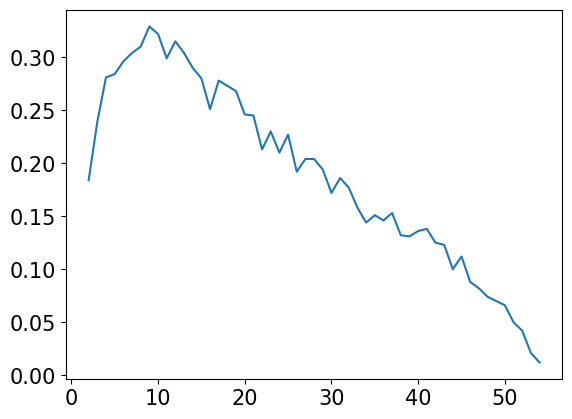

In [41]:
#Calcul de silhouette score 

from sklearn import metrics
from sklearn.metrics import pairwise_distances

print(metrics.silhouette_score(w2v_cbow_pdj_freq_load.wv.vectors, items_labels, metric='euclidean'))
print(np.shape(w2v_cbow_pdj_freq_load.wv.vectors))

#classe prédite pour chaque aliment du PDJ (ici avec k=8)
print(np.shape(items_labels))
print(items_labels[0:55])

#Evaluer le silhouette scores en fonction de la valeur de k 
print("\n", "silhouette en fonction de k:")
x=[]
y=[]
for k in range(2,55):
    items_model, items_labels, items_cluster_centers = cluster_kmeans(w2v_cbow_pdj_freq_load.wv.vectors, k)
    x.append(k)
    y.append(round(metrics.silhouette_score(w2v_cbow_pdj_freq_load.wv.vectors, items_labels, metric='euclidean'),3))
plt.plot(x,y)
print(y)


In [33]:
# Conclusion: PRENONS k=8 clusters basé sur la connaissance expert des catégories (homogénéité vs groupe INCA2) et sur le silhouette score 

# ON FIGE LES CLUSTERS (k=8)

In [42]:
# ON A FIXE A K=8 LE NOMBRE DE CATEGORIES ET ON A ENREGISTRE LE MODELE 

# items_model, items_labels, items_cluster_centers = cluster_kmeans(w2v_cbow_pdj_freq_load.wv.vectors, 8)

import pickle

# save the model 
filename = 'final_model_10dim_kmeans.sav'
# pickle.dump(items_model, open(filename, 'wb'))


In [43]:
# ON CHARGE LE MODELE basé sur 8 clusters

loaded_kmeans_model = pickle.load(open(filename, 'rb'))

item_labels_load=loaded_kmeans_model.labels_
items_cluster_centers_load=loaded_kmeans_model.cluster_centers_
print(item_labels_load)
print(items_cluster_centers_load)

[3 5 0 1 2 6 0 3 0 5 3 7 3 5 1 1 4 2 4 6 1 2 0 1 5 2 6 1 7 4 1 3 4 6 4 6 0
 2 2 3 1 4 4 4 0 0 6 0 0 0 4 1 0 6 0]
[[ 1.6298193   1.1916977  -0.04189955 -0.30314618  0.8231111  -1.6712458
   0.55815095  0.6577574  -0.54672277 -0.45569843]
 [ 0.9109309  -1.9798124   0.27695984 -4.0422344   1.824614    0.65561116
   1.689454   -0.71931684 -2.4182568  -0.9327279 ]
 [ 0.16452783 -0.4871176   0.12895222  2.0463288  -0.6068634   0.4971176
  -0.1013453   5.720546    1.8110275  -0.19893411]
 [-2.9553008  -0.77701366  0.54245114  1.3362415   0.380859   -2.8962762
   0.14971173 -0.6211479  -0.16386127 -1.2927873 ]
 [-0.39385614 -0.5169955   0.87936306 -1.1435509  -0.24513441  2.1742868
   0.5585872   0.3380416  -0.2532966   0.88263726]
 [ 1.0317612  -0.05403742 -3.4022126   0.5922676   1.8107128  -0.2847352
  -1.1016377  -1.544285    0.873913    0.5919515 ]
 [ 0.60391235  0.33037877 -0.6721635   2.013597   -1.8741882   0.31626406
   1.8843087  -0.323671   -2.0181432   0.6853366 ]
 [-6.095881    1.

C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

c=8

def tsne_plot_class_centroid(model, k):      
    labels = []
    alim = []
    classe = []
    labels_centroids = []
    centroid = []
     
    for e in liste_code_al_pdj:
        if e in model.wv:
            alim.append(model.wv[e])
            labels.append(dic_alim[e])
            classe.append(loaded_kmeans_model.predict(model.wv[e].reshape(1,-1)))
    alim2=np.array(alim)
    print(np.shape(alim2))
    
    i=0
    for i in range(k):
        centroid.append(items_cluster_centers_load[i])
        labels_centroids.append(i)
    centroid2=np.array(centroid)
    print(np.shape(centroid2))
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
    new_values = tsne_model.fit_transform(alim2) 
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])      
        
    colors=['darkgreen', 'orange', 'pink', 'black', 'blueviolet', 'brown', 'red', 'cyan', 'darkgrey', 'darkred', 
            'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'deeppink', 
            'deepskyblue', 'dimgray', 'dodgerblue', 'firebrick', 'forestgreen', 'fuchsia', 'ghostwhite', 'gold']
    plt.figure(figsize=(20, 20)) 
    plt.rc('font', size=15)
    
    for i in range(len(x)):
        j=int(classe[i])
        plt.scatter(x[i], y[i], c=colors[j])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]), 
                     color=colors[j],
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
         
    plt.show()
    
    
    
tsne_plot_class_centroid(w2v_cbow_pdj_freq_load, c) 
    

(56, 10)
(8, 10)


In [46]:
# Créer un dictionnaire qui associe à chaque aliment sa catégorie prédite, ici k=8
# Lister les aliments par catégorie
# Lister les groupes INCA2 par catégorie

c=8
dico_cluster_codes={}
dico_cluster_noms={}
for i in range(c):
        dico_cluster_codes[i]=[]
        dico_cluster_noms[i]=[]
for e in liste_code_al_pdj:
    if e in w2v_cbow_pdj_freq_load.wv:
        dico_cluster_codes[int(loaded_kmeans_model.predict(w2v_cbow_pdj_freq_load.wv[e].reshape(1,-1)))].append(e)
        dico_cluster_noms[int(loaded_kmeans_model.predict(w2v_cbow_pdj_freq_load.wv[e].reshape(1,-1)))].append(dic_alim[e])
print(dico_cluster_codes.items())

table_cluster_alim=pd.DataFrame(columns=['cluster', 'aliments'], index=range(c))
for i in range(len(dico_cluster_noms.keys())):
    table_cluster_alim.cluster[i]=i
    table_cluster_alim.aliments[i]=dico_cluster_noms[i]
    print("\n", i, ": Ce cluster contient les aliments:", "\n", "\t", dico_cluster_noms[i])           

# dictionnaire qui associe à chaque classe :la liste des catégories des aliments dans INCA  (ici k=8)
dico_cluster_group={}
for i in range(len(dico_cluster_codes.keys())):
    dico_cluster_group[i]=[]
    for j in range(len(dico_cluster_codes[i])):
        dico_cluster_group[i].append(dic_group[dic_alim_group[dico_cluster_codes[i][j]]])    
        
table_cluster_group=pd.DataFrame(columns=['cluster', 'groupe'], index=range(c))
for i in range(len(dico_cluster_group.keys())): 
    table_cluster_group.cluster[i]=i
    table_cluster_group.groupe[i]=dico_cluster_group[i]
    print("\n", i, ": Ce cluster contient les aliments des groupes suivants:", "\n", "\t", dico_cluster_group[i])
    
#dictionnaire qui associe à un aliment sa catégorie
dico_cluster_code_km={}
dico_cluster_name_km={}
dico_cluster_group_km={}

for i in range(c):
    dico_cluster_code_km[i] = []
    dico_cluster_name_km[i] = []
    dico_cluster_group_km[i] = []
    
for i in range(c):
    for index, word in enumerate(w2v_cbow_pdj_freq_load.wv.index_to_key):
        if item_labels_load[index]==i:
            dico_cluster_code_km[i].append(word)
            dico_cluster_name_km[i].append(dic_alim[word])
            dico_cluster_group_km[i].append(dic_group[dic_alim_group[word]])

#Contenu des catégories            
print("\n Aliments contenus dans chaque catégorie")            
for key, value in dico_cluster_name_km.items():
    print(key, value, "\n")
    
print("\n Groupes INCA2 des aliments contenus dans chaque catégorie")
for key, value in dico_cluster_group_km.items():
    print(key, len(value), value, "\n")

print("\n Groupes INCA2 (%) contenus dans chaque catégorie")   
for i in range(c): 
    print("catégorie", i)
    word_count = {}
    for word in dico_cluster_group_km[i]: 
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1
    for e in word_count.keys():
        word_count[e]=round((word_count[e]/len(dico_cluster_group_km[i])),2)
    print(word_count,"\n")

dict_items([(0, [18066, 18008, 19041, 13034, 2012, 13039, 19050, 13005, 2013, 2070, 2004, 13021]), (1, [7001, 7100, 7012, 7110, 7300, 7004, 7200, 92030, 7255]), (2, [16632, 16727, 16400, 16402, 16730, 16412]), (3, [18151, 18004, 18020, 18073, 18101, 18071]), (4, [7740, 7601, 7730, 7741, 7620, 31032, 24630, 7710, 24231]), (5, [31016, 81052, 31019, 31017, 1]), (6, [31006, 13024, 19600, 31008, 31024, 31037, 31110]), (7, [18150, 18005])])

 0 : Ce cluster contient les aliments: 
 	 ['eau du robinet', 'eau de source', 'lait demi-écrémé uht', 'orange fraîche', "jus d'orange à base de concentré pasteurisé", 'pomme non pelée fraîche', 'lait écrémé uht', 'banane fraîche', "jus d'orange pressé maison", "pur jus d'orange pasteurisé", 'jus de fruits sans précision', 'kiwi frais']

 1 : Ce cluster contient les aliments: 
 	 ['pain baguette', 'pain de campagne ou bis', 'pain courant français boule à la levure', 'pain complet ou intégral artisanal', 'biscotte classique type heudebert lu', 'pain grill

In [47]:
# Pour les classifications "aberrantes", retrouver le code de l'aliment :

for key, value in dic_alim.items():
    if value == "pâte à tartiner au chocolat et aux noisettes type nutella":
        print(value, "La clé correspondante est :", key)
        
    if value == "=> yaourt ou spécialité laitière nature":
        print(value, "=> La clé correspondante est :", key)

pâte à tartiner au chocolat et aux noisettes type nutella La clé correspondante est : 31032


In [48]:
# Pour les classifications "aberrantes", voir les most similar :

s1_1=w2v_cbow_pdj_freq_load.wv.most_similar(31032,topn=5)
print(s1_1)

for i in range(len(s1_1)):
    print(dic_alim[s1_1[i][0]], s1_1[i][1], "\t", dic_group[dic_alim_group[s1_1[i][0]]])


[(31037, 0.5491869449615479), (31006, 0.48450013995170593), (24231, 0.4532880485057831), (31024, 0.4257569909095764), (7730, 0.4035760462284088)]
confiture d'abricot 0.5491869449615479 	 sucres et dérivés
confiture ou marmelade tout type 0.48450013995170593 	 sucres et dérivés
goûter sec fourré au chocolat type prince ou bn au chocolat 0.4532880485057831 	 biscuits sucrés ou salés et barres
confiture de fraise 0.4257569909095764 	 sucres et dérivés
pain au chocolat feuilleté artisanal 0.4035760462284088 	 viennoiserie


In [49]:
# Pour les classifications "aberrantes", voir les most similar :

s1_1=w2v_cbow_pdj_freq_load.wv.most_similar(19600,topn=5)
print(s1_1)

for i in range(len(s1_1)):
    print(dic_alim[s1_1[i][0]], s1_1[i][1], "\t", dic_group[dic_alim_group[s1_1[i][0]]])

[(13005, 0.7724541425704956), (31008, 0.6716515421867371), (13039, 0.44465333223342896), (16402, 0.4234231412410736), (16727, 0.39153409004211426)]
banane fraîche 0.7724541425704956 	 fruits
miel 0.6716515421867371 	 sucres et dérivés
pomme non pelée fraîche 0.44465333223342896 	 fruits
beurre demi-sel sel maxi 3% 0.4234231412410736 	 beurre
matière grasse allégée 55-60% m.g. riche en oméga 3 et 6 0.39153409004211426 	 margarine


In [50]:
# Essayer de reclusteriser au sein de clusters heterogènes (le cluster 0)

vectors_c0=[]
for e in dico_cluster_codes[0]:
    vectors_c0.append(w2v_cbow_pdj_freq_load.wv[e])
print(np.shape(vectors_c0))

items_model_c0, items_labels_c0, items_cluster_centers_c0 = cluster_kmeans(vectors_c0, 4)
print(items_labels_c0)

for e in dico_cluster_codes[0]:
    print(e, dic_alim[e], items_labels_c0[dico_cluster_codes[0].index(e)])
    
# conclusion on ne retombe pas sur des sous catégories souhaitées (groups INCA2)...ON NE RETIENT PAS CETTE APPROCHE

(12, 10)


C:\Users\jacqueno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[3 0 1 0 1 0 2 0 1 1 1 0]
18066 eau du robinet 3
18008 eau de source 0
19041 lait demi-écrémé uht 1
13034 orange fraîche 0
2012 jus d'orange à base de concentré pasteurisé 1
13039 pomme non pelée fraîche 0
19050 lait écrémé uht 2
13005 banane fraîche 0
2013 jus d'orange pressé maison 1
2070 pur jus d'orange pasteurisé 1
2004 jus de fruits sans précision 1
13021 kiwi frais 0


In [51]:
# Calculer les coordonnées des users dans le nouvel espace contenant les clusters des aliments
# ATTENTION ICI ON N A PAS ENLEVE LE JOUR DE RECUEIL CACHE DONC C EST JUSTE POUR TESTER L APPROCHE 

# On reprend les PDJ qui contiennent les aliments non rares seulement (les 55):
import copy
d_new2=copy.deepcopy(d_new)
d_new_indiv_nonnuls={}
print(d_new2)

for key in d_new2.keys(): 
    if d_new2[key]!={}:
        d_new_indiv_nonnuls[key]=d_new2[key]

{110006: {}, 110007: {}, 110020: {}, 110021: {}, 110025: {1: [18004, 19041, 31016, 7601, 18066], 2: [18004, 19041, 31016, 7601, 18066], 3: [18004, 19041, 31016, 7001, 16632, 18066]}, 110034: {}, 110046: {}, 110057: {}, 110067: {2: [18004, 7601, 2012, 31016], 3: [18004, 7601, 31016, 2012], 4: [18004, 31016, 7601, 2012], 5: [18004, 31016, 7601, 2012], 6: [18004, 31016, 7601, 2012]}, 110071: {1: [18004, 18066, 81052], 2: [18004, 7001, 31008, 16400, 81052], 3: [18004, 7001, 18066, 16400, 31008, 81052], 4: [18004, 81052], 5: [18004, 81052], 6: [18004, 18066, 81052], 7: [18004, 81052]}, 110081: {}, 110110: {2: [18020, 19041], 3: [18020, 19041, 7001, 16402, 31008], 4: [18020, 19041], 5: [18020, 19041], 6: [18020, 19041], 7: [18020, 19041, 13039]}, 110113: {1: [19041, 7001, 31006, 18150], 2: [19050, 18150, 7001, 31006], 3: [19050, 18150, 7001, 31006], 4: [19050, 18150], 5: [19050, 7741], 6: [19050, 7741], 7: [19041, 7001, 31006]}, 110125: {5: [13005, 13039, 18066], 7: [7100, 16402, 18020, 3101

In [53]:
# On a ci-dessous les PDJ qui contiennent les aliments non rares seulement

print(d_new_indiv_nonnuls)   
len(d_new_indiv_nonnuls)


{110025: {1: [18004, 19041, 31016, 7601, 18066], 2: [18004, 19041, 31016, 7601, 18066], 3: [18004, 19041, 31016, 7001, 16632, 18066]}, 110067: {2: [18004, 7601, 2012, 31016], 3: [18004, 7601, 31016, 2012], 4: [18004, 31016, 7601, 2012], 5: [18004, 31016, 7601, 2012], 6: [18004, 31016, 7601, 2012]}, 110071: {1: [18004, 18066, 81052], 2: [18004, 7001, 31008, 16400, 81052], 3: [18004, 7001, 18066, 16400, 31008, 81052], 4: [18004, 81052], 5: [18004, 81052], 6: [18004, 18066, 81052], 7: [18004, 81052]}, 110110: {2: [18020, 19041], 3: [18020, 19041, 7001, 16402, 31008], 4: [18020, 19041], 5: [18020, 19041], 6: [18020, 19041], 7: [18020, 19041, 13039]}, 110113: {1: [19041, 7001, 31006, 18150], 2: [19050, 18150, 7001, 31006], 3: [19050, 18150, 7001, 31006], 4: [19050, 18150], 5: [19050, 7741], 6: [19050, 7741], 7: [19041, 7001, 31006]}, 110125: {5: [13005, 13039, 18066], 7: [7100, 16402, 18020, 31016]}, 110152: {7: [7001, 31037, 2013, 18004, 18066]}, 110167: {3: [18004, 81052], 4: [18004, 8105

1738

In [54]:
#On crée un dictionnaire avec pour chaque individu la liste des aliments non rares mangés au petit déjeuner sur la semaine 
# POUR LES CONSOMMATIONS D'UN USER, ON NE GARDE PAS LES ALIMENTS d'un petit déjeuner dans lequel figure un aliment rare : 
# on supprime tout le petit déjeuner

d_indiv_freq={}
for key, value in d_new_indiv_nonnuls.items():
    new_value = []
    for val, sublist in value.items():
        for i in sublist:
            new_value.append(i)
    d_indiv_freq[key] = new_value
    
print("longueur du dic:", len(d_indiv_freq))
print(d_indiv_freq)


longueur du dic: 1738
{110025: [18004, 19041, 31016, 7601, 18066, 18004, 19041, 31016, 7601, 18066, 18004, 19041, 31016, 7001, 16632, 18066], 110067: [18004, 7601, 2012, 31016, 18004, 7601, 31016, 2012, 18004, 31016, 7601, 2012, 18004, 31016, 7601, 2012, 18004, 31016, 7601, 2012], 110071: [18004, 18066, 81052, 18004, 7001, 31008, 16400, 81052, 18004, 7001, 18066, 16400, 31008, 81052, 18004, 81052, 18004, 81052, 18004, 18066, 81052, 18004, 81052], 110110: [18020, 19041, 18020, 19041, 7001, 16402, 31008, 18020, 19041, 18020, 19041, 18020, 19041, 18020, 19041, 13039], 110113: [19041, 7001, 31006, 18150, 19050, 18150, 7001, 31006, 19050, 18150, 7001, 31006, 19050, 18150, 19050, 7741, 19050, 7741, 19041, 7001, 31006], 110125: [13005, 13039, 18066, 7100, 16402, 18020, 31016], 110152: [7001, 31037, 2013, 18004, 18066], 110167: [18004, 81052, 18004, 81052, 18004, 81052], 110194: [18004, 7620, 31006, 18004, 19041, 7620, 31006, 18004, 19041, 7620, 31006, 18004, 19041, 7100, 31006, 18004, 19041, 

In [55]:
# dictionnaire qui associe à un individu les coordonnees moyennes de l'ensemble des aliments de ses PDJ 

coord_indiv={}
for key in d_indiv_freq:
    coord_al=np.zeros(len(w2v_cbow_pdj_freq_load.wv[18004]))
    for e in d_indiv_freq[key]:
        coord_al+=w2v_cbow_pdj_freq_load.wv[e]    
    coord_indiv[key]=coord_al/(len(d_indiv_freq[key]))

    
print(coord_indiv[110025])



[ 0.00357513  0.68325075 -0.00240498 -0.48308026  0.33955256 -0.43679482
 -0.51575103  0.08931758 -0.34035616 -0.05581386]


In [134]:
# for key in d_indiv_freq:
#     al=[]
#     for i in range(len(d_indiv_freq[key])):
#         al.append(dic_alim[d_indiv_freq[key][i]])
#     print(key, al)

110025 ['café noir prêt à boire non sucré', 'lait demi-écrémé uht', 'sucre blanc', 'croissant sans précision', 'eau du robinet', 'café noir prêt à boire non sucré', 'lait demi-écrémé uht', 'sucre blanc', 'croissant sans précision', 'eau du robinet', 'café noir prêt à boire non sucré', 'lait demi-écrémé uht', 'sucre blanc', 'pain baguette', 'matière grasse allégée 60% m.g.', 'eau du robinet']
110067 ['café noir prêt à boire non sucré', 'croissant sans précision', "jus d'orange à base de concentré pasteurisé", 'sucre blanc', 'café noir prêt à boire non sucré', 'croissant sans précision', 'sucre blanc', "jus d'orange à base de concentré pasteurisé", 'café noir prêt à boire non sucré', 'sucre blanc', 'croissant sans précision', "jus d'orange à base de concentré pasteurisé", 'café noir prêt à boire non sucré', 'sucre blanc', 'croissant sans précision', "jus d'orange à base de concentré pasteurisé", 'café noir prêt à boire non sucré', 'sucre blanc', 'croissant sans précision', "jus d'orange 

In [56]:
# dictionnaire qui donne pour chaque individu la liste par cluster des aliments de ce cluster qu'il a 
# consommés au PDJ pendant la semaine 

c=8

d_indiv_cluster={}
d_indiv_cluster_names={}


d_indiv_freq.items()
for key, value in d_indiv_freq.items():
    d_indiv_cluster[key]={}
    d_indiv_cluster_names[key]={}
    for i in range(c):
        d_indiv_cluster[key][i]= []
        d_indiv_cluster_names[key][i]= []
        
d_indiv_cluster.items()   

for key, value in d_indiv_freq.items():
        for i in range(c):
            for v in value:
                if v in dico_cluster_codes[i]:
                    d_indiv_cluster[key][i].append(v)

for key, value in d_indiv_freq.items():
        for i in range(c):
            for v in value:
                if v in dico_cluster_codes[i]:
                    d_indiv_cluster_names[key][i].append(dic_alim[v])  

d_indiv_cluster.items()     
d_indiv_cluster_names.items()  

dict_items([(110025, {0: ['lait demi-écrémé uht', 'eau du robinet', 'lait demi-écrémé uht', 'eau du robinet', 'lait demi-écrémé uht', 'eau du robinet'], 1: ['pain baguette'], 2: ['matière grasse allégée 60% m.g.'], 3: ['café noir prêt à boire non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré'], 4: ['croissant sans précision', 'croissant sans précision'], 5: ['sucre blanc', 'sucre blanc', 'sucre blanc'], 6: [], 7: []}), (110067, {0: ["jus d'orange à base de concentré pasteurisé", "jus d'orange à base de concentré pasteurisé", "jus d'orange à base de concentré pasteurisé", "jus d'orange à base de concentré pasteurisé", "jus d'orange à base de concentré pasteurisé"], 1: [], 2: [], 3: ['café noir prêt à boire non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré'], 4: ['croissant sans précision', 'croissant sans précision', 'croissant sans précision', 'croissa

In [57]:
# Moyenne de chacun des clusters issu de Kmeans

c=8

moy_clusters={}
for i in range(c):
    moy_clusters[i]=np.zeros(10)     
      
for i in range(c):
    coord_al=[]
    for e in dico_cluster_codes[i]:
        coord_al.append(w2v_cbow_pdj_freq_load.wv[e])
    if len(dico_cluster_codes[i])!=0:
        coord_al=(np.array(coord_al)).T
        moy = np.mean(coord_al, axis=1)
    elif len(dico_cluster_codes[i])==0:
        moy=np.full((10,), np.nan)          
    moy_clusters[i]=moy  
       
# Exemple : moyenne du cluster 3    
print("moyenne pour le cluster 3:", moy_clusters[3])

# Exemple : Nombre d'aliments du cluster 3 
print("codes des aliments dans le cluster 3", dico_cluster_noms[3])
      


moyenne pour le cluster 3: [-2.9553006  -0.7770136   0.54245114  1.3362414   0.380859   -2.8962765
  0.14971174 -0.62114793 -0.16386132 -1.2927872 ]
codes des aliments dans le cluster 3 ['café au lait ou café crème ou cappuccino non sucré', 'café noir prêt à boire non sucré', 'thé infusé non sucré', 'café soluble reconstitué prêt à boire non sucré', 'poudre cacaotée et sucrée pour boisson au chocolat', 'café expresso non sucré']


In [61]:
# Moyenne pour chacun des clusters PAR INDIVIDU
# ATTENTION ICI ON N A PAS ENLEVE LE JOUR DE RECUEIL CACHE DONC C EST JUSTE POUR TESTER L APPROCHE

# dictionnaire qui contient pour chaque individu : pour chaque cluster la moyenne de cet individu pour ce cluster 

mean_indiv_clust={}
for key, value in d_indiv_cluster.items():
    for n in value:
        mean_indiv_clust[(key,n)]=np.zeros(10)
# print(mean_indiv_clust[(110025,0)])

liste_indiv=[]
for key in d_indiv_cluster.keys():             
    liste_indiv.append(key)
# print(liste_indiv[:10])
                       
for i in liste_indiv:
    for key, value in d_indiv_cluster.items():
        if key==i:
            for subkey, sublist in value.items():
                v=subkey
                coord_al=[]
                for e in sublist:
                    coord_al.append(w2v_cbow_pdj_freq_load.wv[e])
                if len(sublist)!=0:
                    coord_al=(np.array(coord_al)).T
#                     print(coord_al.shape)
                    moy = np.mean(coord_al, axis=1)
                elif len(sublist)==0:
                    moy=np.full((10,), np.nan)
                mean_indiv_clust[(i,v)]=moy
            
# for i in liste_indiv[:20]:
#     print("MOYENNE pour catégorie 3 de l'individu:", i, mean_indiv_clust[(i,3)])   

# for i in liste_indiv[:20]:
#     print("Nombre d'aliments pour la catégorie 3 pour l'individu:", i, len(d_indiv_cluster[i][3])) 
  
# for i in liste_indiv[:20]:
#     liste=[]
#     for e in d_indiv_cluster[i][3]:
#         liste.append(dic_alim[e])
#     print("aliments de la catégorie 3 consommés par l'individu:", i, liste) 


In [58]:
# Dataframe des aliments consommés par individu par cluster au PDJ (PDJ contentant des aliments non rares)
# on enleve des lignes [] pour une catégorie donnée et un individu donné. considérons le cluster 3

c=8
data=[]
sublist_2=[]
for i in range(c):
    for key, value in d_indiv_cluster.items():
        for subkey, sublist in value.items():
            if subkey==i:
                if sublist!=[]:
                    sublist_2=set(sublist)                   
                    data.append((i, key, sublist_2))
df=pd.DataFrame(data, columns=['Cluster', 'Individu', 'Code_Alim'])

df_cat0=df[df.Cluster==3]
df_cat0[0:100]


Cluster  Individu              Code_Alim
3051        3    110025                {18004}
3052        3    110067                {18004}
3053        3    110071                {18004}
3054        3    110110                {18020}
3055        3    110125                {18020}
3056        3    110152                {18004}
3057        3    110167                {18004}
3058        3    110194                {18004}
3059        3    110208                {18151}
3060        3    110237         {18004, 18151}
3061        3    110238         {18020, 18004}
3062        3    110244                {18020}
3063        3    110264         {18020, 18004}
3064        3    110300                {18004}
3065        3    110341                {18073}
3066        3    110352                {18151}
3067        3    110362                {18004}
3068        3    110372                {18020}
3069        3    110390                {18004}
3070        3    110391                {18004}
3071        3    110407                {18004}
3072        3    110409                {18004}
3073        3    110410                {18020}
3074        3    110455                {18004}
3075        3    110472                {18151}
3076        3    110483                {18071}
3077        3    110486         {18004, 18151}
3078        3    110518                {18020}
3079        3    110519                {18004}
3080        3    110534                {18020}
3081        3    110537                {18004}
3082        3    110539                {18020}
3083        3    110548                {18004}
3084        3    110554                {18101}
3085        3    110555                {18020}
3086        3    110558                {18020}
3087        3    110564                {18004}
3088        3    110569                {18101}
3089        3    110571                {18004}
3090        3    110574         {18073, 18151}
3091        3    110582                {18020}
3092        3    110595                {18020}
3093        3    110598                {18151}
3094        3    110609                {18004}
3095        3    110618                {18151}
3096        3    110621                {18004}
3097        3    110622         {18020, 18101}
3098        3    110633                {18004}
3099        3    110642                {18004}
3100        3    110647                {18004}
3101        3    110668  {18020, 18101, 18151}
3102        3    110677         {18004, 18151}
3103        3    110695                {18020}
3104        3    110696                {18004}
3105        3    110699                {18101}
3106        3    110705                {18004}
3107        3    110715                {18073}
3108        3    110744                {18020}
3109        3    110796                {18004}
3110        3    110826                {18071}
3111        3    110834                {18004}
3112        3    110859                {18004}
3113        3    110871                {18004}
3114        3    110888                {18004}
3115        3    110889                {18004}
3116        3    110891                {18073}
3117        3    110908                {18151}
3118        3    110910                {18004}
3119        3    110927                {18004}
3120        3    110935                {18004}
3121        3    110937                {18004}
3122        3    110939                {18004}
3123        3    110941                {18020}
3124        3    110947                {18101}
3125        3    110949                {18101}
3126        3    110955                {18004}
3127        3    110972                {18151}
3128        3    110974                {18101}
3129        3    110978                {18004}
3130        3    110987                {18004}
3131        3    110988                {18004}
3132        3    110989                {18004}
3133        3    110994                {18004}
3134        3    110995                {18151}
3135       

In [62]:
#Evaluer la distance entre un individu et les aliments du cluster 3 
# ATTENTION ICI ON N A PAS ENLEVE LE JOUR DE RECUEIL CACHE DONC C EST JUSTE POUR TESTER L'APPROCHE 

from numpy import dot
from numpy.linalg import norm

model=w2v_cbow_pdj_freq_load
moy=mean_indiv_clust[(110237,3)]

# Vecteur de l'individu (moyenne de ses aliments dans le cluster)
new_word_vec = moy

# Calcul de la similarité cosine entre le user et tous les aliments du cluster 
similarities = {}
for e in dico_cluster_codes[3]:
    similarities[e] = dot(new_word_vec, model.wv[e]) / (norm(new_word_vec) * norm(model.wv[e]))

for key, value in similarities.items():
    print(key, dic_alim[key], "\t", value)

# Affichage des 10 mots les plus similaires à l'individu(moyenne des ses aliments) dans le cluster 3
top10_similar_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:10]
print("similaires à '", "110237", "':\n", top10_similar_words)

18151 café au lait ou café crème ou cappuccino non sucré 	 0.9585628
18004 café noir prêt à boire non sucré 	 0.9922742
18020 thé infusé non sucré 	 0.8961093
18073 café soluble reconstitué prêt à boire non sucré 	 0.8592919
18101 poudre cacaotée et sucrée pour boisson au chocolat 	 0.7098359
18071 café expresso non sucré 	 0.6883911
similaires à ' 110237 ':
 [(18004, 0.9922742), (18151, 0.9585628), (18020, 0.8961093), (18073, 0.8592919), (18101, 0.7098359), (18071, 0.6883911)]


In [144]:
#Exemple de recommandation pour un individu: on utilise desormais proba[e] = np.exp(alpha*similarities[e])  
# ATTENTION ICI ON N A PAS ENLEVE LE JOUR DE RECUEIL CACHE DONC C EST JUSTE POUR TESTER LES PROBABILITES 
ind=110237
c=8
model=w2v_cbow_pdj_freq_load         
alpha=10

for i in range(c):
    print("consommations reelles de la catégorie:", i, d_indiv_cluster_names[ind][i], "\n")

for i in range(c):
    if d_indiv_cluster_names[ind][i]!=[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:
            similarities[e] = dot(mean_indiv_clust[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust[(ind,i)]) 
                                                                             * norm(model.wv[e]))
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e])
        p=np.array(p)
        p_normalized = p / np.sum(p)
        print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized, "\n")
        tirage = np.random.multinomial(1, p_normalized)
        for a in range(len(dico_cluster_codes[i])):
            if tirage[a]==1:
                print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n")   
        
    elif d_indiv_cluster_names[ind][i]==[]:
        if np.random.choice([True, False], p=[0.05, 0.95]):
            print("\n on recommande aussi une catégorie non consommée dans le passé \n")
            # Dans 5% des cas, on tire une mutlitnomiale
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:
                similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])
            p=np.array(p)
            p_normalized = p / np.sum(p)
            print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized, "\n")
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(dico_cluster_codes[i])):
                if tirage[a]==1:
                    print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n") 
                              

consommations reelles de la catégorie: 0 ["jus d'orange à base de concentré pasteurisé", 'lait demi-écrémé uht', "jus d'orange à base de concentré pasteurisé", 'lait demi-écrémé uht', "jus d'orange à base de concentré pasteurisé"] 

consommations reelles de la catégorie: 1 [] 

consommations reelles de la catégorie: 2 [] 

consommations reelles de la catégorie: 3 ['café au lait ou café crème ou cappuccino non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré'] 

consommations reelles de la catégorie: 4 ['brioche sans précision', 'brioche sans précision', 'brioche sans précision'] 

consommations reelles de la catégorie: 5 ['sucre roux', 'sucre roux', 'sucre roux'] 

consommations reelles de la catégorie: 6 ["confiture d'abricot", "confiture d'abricot", "confiture d'abricot"] 

consommations reelles de la catégorie: 7 [] 

0 ['eau du robinet', 'eau de source', 'lait demi-écrémé uht', 'orange fraîche', "jus d'orange à base de concentré pasteurisé", 'pomme non 

# Séparer les jours de recueil et le jour caché pour chaque individu 

In [63]:
# Pour validation, créer un dictionnaire qui ne contient les jours de recueil moins 1, que l'on essaiera de prédire

# print(d_new)
d_6j={}
d_1j={}

for key, value in d_new.items():
    lon=len(d_new[key])
    k=0
    if lon>1:
        for i in range(1,8):
            if i in d_new[key]:
                k+=1
                if k<lon:
                    d_6j.setdefault(key, {})[i]=d_new[key][i]
                if k==lon:
                    d_1j.setdefault(key, {})[0]=d_new[key][i]
# print(d_6j)
print(d_1j)


{110025: {0: [18004, 19041, 31016, 7001, 16632, 18066]}, 110067: {0: [18004, 31016, 7601, 2012]}, 110071: {0: [18004, 81052]}, 110110: {0: [18020, 19041, 13039]}, 110113: {0: [19041, 7001, 31006]}, 110125: {0: [7100, 16402, 18020, 31016]}, 110167: {0: [18004, 81052]}, 110194: {0: [18004, 19041, 31006]}, 110237: {0: [18004, 19041, 31017, 7741, 31037, 2012]}, 110238: {0: [18020, 7001, 16400, 19041]}, 110244: {0: [18020, 18066, 7100, 16400, 31037, 31006, 81052]}, 110264: {0: [18004, 19600, 7012, 31006, 16412, 81052, 81052]}, 110291: {0: [18005, 18066, 31016]}, 110298: {0: [7001, 7001, 31006, 19041, 18066, 2070]}, 110300: {0: [19041, 18066, 18004, 7004, 31016]}, 110341: {0: [18073, 7200, 16412, 31110]}, 110352: {0: [18151, 7001, 16400, 31016]}, 110362: {0: [18004]}, 110372: {0: [7200, 16400, 31016, 18020, 19041]}, 110390: {0: [18008, 18004, 31016, 7001, 16400]}, 110391: {0: [18008, 18004, 19041, 31016]}, 110407: {0: [18004, 7001, 16400, 81052]}, 110409: {0: [7001, 18004, 81052]}, 110410: {

In [64]:
# Créer un dictionnaire qui contient pour chaque individu par cluster les aliments du cluster 
# qu'ils a consommés sur les jours de recueil -1



c=8

d_indiv_cluster_6j={}
d_indiv_cluster_names_6j={}

for key, value in d_6j.items():
    d_indiv_cluster_6j[key]={}
    d_indiv_cluster_names_6j[key]={}
    for i in range(c):
        d_indiv_cluster_6j[key][i]= []
        d_indiv_cluster_names_6j[key][i]= []


for key, value in d_6j.items():
        for i in range(c):
            for subkey, sublist in value.items():
                    for v in sublist:
                        if v in dico_cluster_codes[i]:
                            d_indiv_cluster_6j[key][i].append(v)

for key, value in d_6j.items():
        for i in range(c):
            for subkey, sublist in value.items():
                    for v in sublist:
                        if v in dico_cluster_codes[i]:
                            d_indiv_cluster_names_6j[key][i].append(dic_alim[v])  
  
d_indiv_cluster_6j
d_indiv_cluster_names_6j

# Créer un dictionnaire qui contient pour chaque individu par cluster les aliments du cluster 
# qu'ils a consommés sur le jour caché 

d_indiv_cluster_1j={}
d_indiv_cluster_names_1j={}

for key, value in d_1j.items():
    d_indiv_cluster_1j[key]={}
    d_indiv_cluster_names_1j[key]={}
    for i in range(c):
        d_indiv_cluster_1j[key][i]= []
        d_indiv_cluster_names_1j[key][i]= []


for key, value in d_1j.items():
        for i in range(c):
            for subkey, sublist in value.items():
                    for v in sublist:
                        if v in dico_cluster_codes[i]:
                            d_indiv_cluster_1j[key][i].append(v)

for key, value in d_1j.items():
        for i in range(c):
            for subkey, sublist in value.items():
                    for v in sublist:
                        if v in dico_cluster_codes[i]:
                            d_indiv_cluster_names_1j[key][i].append(dic_alim[v])  
    
d_indiv_cluster_1j
d_indiv_cluster_names_1j



{110025: {0: ['lait demi-écrémé uht', 'eau du robinet'],
  1: ['pain baguette'],
  2: ['matière grasse allégée 60% m.g.'],
  3: ['café noir prêt à boire non sucré'],
  4: [],
  5: ['sucre blanc'],
  6: [],
  7: []},
 110067: {0: ["jus d'orange à base de concentré pasteurisé"],
  1: [],
  2: [],
  3: ['café noir prêt à boire non sucré'],
  4: ['croissant sans précision'],
  5: ['sucre blanc'],
  6: [],
  7: []},
 110071: {0: [],
  1: [],
  2: [],
  3: ['café noir prêt à boire non sucré'],
  4: [],
  5: ['sucre blanc ajouté au service'],
  6: [],
  7: []},
 110110: {0: ['lait demi-écrémé uht', 'pomme non pelée fraîche'],
  1: [],
  2: [],
  3: ['thé infusé non sucré'],
  4: [],
  5: [],
  6: [],
  7: []},
 110113: {0: ['lait demi-écrémé uht'],
  1: ['pain baguette'],
  2: [],
  3: [],
  4: [],
  5: [],
  6: ['confiture ou marmelade tout type'],
  7: []},
 110125: {0: [],
  1: ['pain de campagne ou bis'],
  2: ['beurre demi-sel sel maxi 3%'],
  3: ['thé infusé non sucré'],
  4: [],
  5: [

In [66]:
# Moyenne et variance pour chacun des clusters PAR INDIVIDU SUR LES JOURS DE RECUEIL MOINS 1

# MOYENNE : dictionnaire qui contient pour chaque individu : pour chaque cluster la moyenne de cet individu pour ce cluster 
# SUR LES JOURS DE RECUEIL -1

mean_indiv_clust_6j={}
for key, value in d_indiv_cluster_6j.items():
    for n in value:
        mean_indiv_clust_6j[(key,n)]=np.zeros(10)
print(mean_indiv_clust[(110025,0)])

liste_indiv_6j=[]
for key in d_indiv_cluster_6j.keys():             
    liste_indiv_6j.append(key)
                    
    
for i in liste_indiv_6j:
    for key, value in d_indiv_cluster_6j.items():
        if key==i:
            for subkey, sublist in value.items():
                v=subkey
                coord_al=[]
                for e in sublist:
                    coord_al.append(w2v_cbow_pdj_freq_load.wv[e])
                if len(sublist)!=0:
                    coord_al=(np.array(coord_al)).T
#                     print(coord_al.shape)
                    moy = np.mean(coord_al, axis=1)
                elif len(sublist)==0:
                    moy=np.full((10,), np.nan)
                mean_indiv_clust_6j[(i,v)]=moy
            

for i in liste_indiv_6j[:20]:
    print("MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1:", i, mean_indiv_clust_6j[(i,1)])
    
    
    

[ 1.2405754   2.696634    0.50969154 -1.2478408  -0.17423666 -0.59882426
 -1.2566233   0.81292963 -0.8940837   0.42959154]
MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1: 110025 [nan nan nan nan nan nan nan nan nan nan]
MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1: 110067 [nan nan nan nan nan nan nan nan nan nan]
MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1: 110071 [ 0.8890156 -1.7285241  0.2945063 -4.4199066  1.7016715  1.0763603
  1.6704719 -0.8298661 -2.6269128 -1.3666478]
MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1: 110110 [ 0.8890156 -1.7285241  0.2945063 -4.4199066  1.7016715  1.0763603
  1.6704719 -0.8298661 -2.6269128 -1.3666478]
MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1: 110113 [ 0.8890156 -1.7285241  0.2945063 -4.4199066  1.7016715  1.0763603
  1.6704718 -0.8298661 -2.6269128 -1.3666478]
MOYENNE pour catégorie 1 de l'individu sur les jours de recueil -1: 110125 [nan

# Exemple de recommandation pour un individu (basée sur historique des 6 jours de recueil, sans le jour caché) 

In [67]:
# Exemple de recommandation pour un individu, basé sur les jours de recueil moins 1:

ind=110025 
c=8
model=w2v_cbow_pdj_freq_load         
alpha=10 #Conservateur 

reco_petitdej=[]

for i in range(c):
    print("consommations reelles de la catégorie sur 6j:", i, d_indiv_cluster_names_6j[ind][i])

similarities = {}
proba = {}
for i in range(c):
    if d_indiv_cluster_names_6j[ind][i]!=[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:
            similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                * norm(model.wv[e]))
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e])            
        p=np.array(p)
        p_normalized = p / np.sum(p)
        print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized)
        tirage = np.random.multinomial(1, p_normalized)
        for a in range(len(dico_cluster_codes[i])):
            if tirage[a]==1:
                reco_petitdej.append(dico_cluster_codes[i][a]) 
                print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n")                  
                    
    elif d_indiv_cluster_names_6j[ind][i]==[]:
        if np.random.choice([True, False], p=[0.05, 0.95]):
            print("\n on recommande aussi une catégorie non consommée dans le passé \n")
            # Dans 5% des cas, on tire une multInomiale
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:
                similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])
            p=np.array(p)
            p_normalized = p / np.sum(p)
            print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized)
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(dico_cluster_codes[i])):
                if tirage[a]==1:
                    reco_petitdej.append(dico_cluster_codes[i][a])                    
                    print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n") 

print("\t =>la liste des codes des aliments recommandés est", reco_petitdej, "\n")

# Consommations réelles de l'individu sur le jour masqué: 
for i in range(c):
    print("consommations reelles de la catégorie le jour masqué:", i, d_indiv_cluster_names_1j[ind][i])

consommations reelles de la catégorie sur 6j: 0 ['lait demi-écrémé uht', 'eau du robinet', 'lait demi-écrémé uht', 'eau du robinet']
consommations reelles de la catégorie sur 6j: 1 []
consommations reelles de la catégorie sur 6j: 2 []
consommations reelles de la catégorie sur 6j: 3 ['café noir prêt à boire non sucré', 'café noir prêt à boire non sucré']
consommations reelles de la catégorie sur 6j: 4 ['croissant sans précision', 'croissant sans précision']
consommations reelles de la catégorie sur 6j: 5 ['sucre blanc', 'sucre blanc']
consommations reelles de la catégorie sur 6j: 6 []
consommations reelles de la catégorie sur 6j: 7 []
0 ['eau du robinet', 'eau de source', 'lait demi-écrémé uht', 'orange fraîche', "jus d'orange à base de concentré pasteurisé", 'pomme non pelée fraîche', 'lait écrémé uht', 'banane fraîche', "jus d'orange pressé maison", "pur jus d'orange pasteurisé", 'jus de fruits sans précision', 'kiwi frais'] 
, proba normalisée: [4.53204658e-01 1.28101445e-03 4.699309

In [68]:
# Exemple de recommandation pour un individu, basé sur les jours de recueil moins 1:

ind=110391    
c=8
model=w2v_cbow_pdj_freq_load         
alpha=100 #Conservateur 

reco_petitdej=[]

for i in range(c):
    print("consommations reelles de la catégorie sur 6j:", i, d_indiv_cluster_names_6j[ind][i])

similarities = {}
proba = {}
for i in range(c):
    if d_indiv_cluster_names_6j[ind][i]!=[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:
            similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                * norm(model.wv[e]))
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e])            
        p=np.array(p)
        p_normalized = p / np.sum(p)
#         print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized, "\n")
        tirage = np.random.multinomial(1, p_normalized)
        for a in range(len(dico_cluster_codes[i])):
            if tirage[a]==1:
                reco_petitdej.append(dico_cluster_codes[i][a]) 
                print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n")  
          
                
    elif d_indiv_cluster_names_6j[ind][i]==[]:
        if np.random.choice([True, False], p=[0.05, 0.95]):
            print("\n on recommande aussi une catégorie non consommée dans le passé \n")
            # Dans 5% des cas, on tire une multInomiale
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:
                similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])
            p=np.array(p)
            p_normalized = p / np.sum(p)
            print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized, "\n")
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(dico_cluster_codes[i])):
                if tirage[a]==1:
                    reco_petitdej.append(dico_cluster_codes[i][a]) 
                    print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n")                   

                    
print("\t =>la liste des codes des aliments recommandés est", reco_petitdej, "\n")
                    
#Consommations réelles de l'individu sur le jour masqué:                 
for i in range(c):
    print("consommations reelles de la catégorie le jour masqué:", i, d_indiv_cluster_names_1j[ind][i])

consommations reelles de la catégorie sur 6j: 0 ['eau de source', 'lait demi-écrémé uht', 'lait demi-écrémé uht', 'eau de source', 'lait demi-écrémé uht', 'eau de source']
consommations reelles de la catégorie sur 6j: 1 ['pain de mie', 'pain de mie']
consommations reelles de la catégorie sur 6j: 2 ['beurre doux', 'beurre demi-sel sel maxi 3%']
consommations reelles de la catégorie sur 6j: 3 ['café noir prêt à boire non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré']
consommations reelles de la catégorie sur 6j: 4 ['madeleine']
consommations reelles de la catégorie sur 6j: 5 ['sucre blanc', 'sucre blanc', 'sucre blanc']
consommations reelles de la catégorie sur 6j: 6 []
consommations reelles de la catégorie sur 6j: 7 []
	 => pour la catégorie 0 l'aliment recommandé est pur jus d'orange pasteurisé 

	 => pour la catégorie 1 l'aliment recommandé est pain de mie 

	 => pour la catégorie 2 l'aliment recommandé est beurre doux 

	 => pour la catégorie 3 l'alim

consommations reelles de la catégorie: 0 ['eau de source', 'lait demi-écrémé uht', 'lait demi-écrémé uht', 'eau de source', 'lait demi-écrémé uht', 'eau de source']
consommations reelles de la catégorie: 1 ['pain de mie', 'pain de mie']
consommations reelles de la catégorie: 2 ['beurre doux', 'beurre demi-sel sel maxi 3%']
consommations reelles de la catégorie: 3 ['café noir prêt à boire non sucré', 'café noir prêt à boire non sucré', 'café noir prêt à boire non sucré']
consommations reelles de la catégorie: 4 ['madeleine']
consommations reelles de la catégorie: 5 ['sucre blanc', 'sucre blanc', 'sucre blanc']
consommations reelles de la catégorie: 6 []
consommations reelles de la catégorie: 7 []
categorie 0


categorie 1


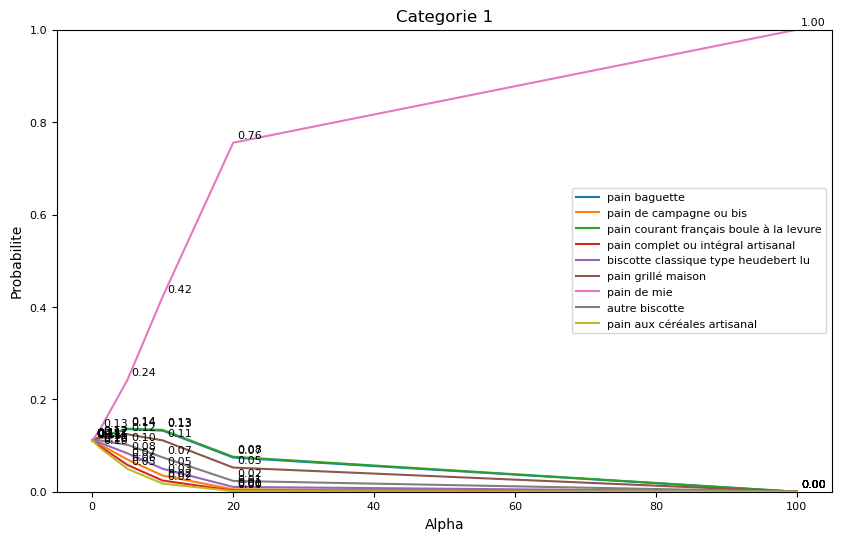

categorie 2


categorie 3


categorie 4


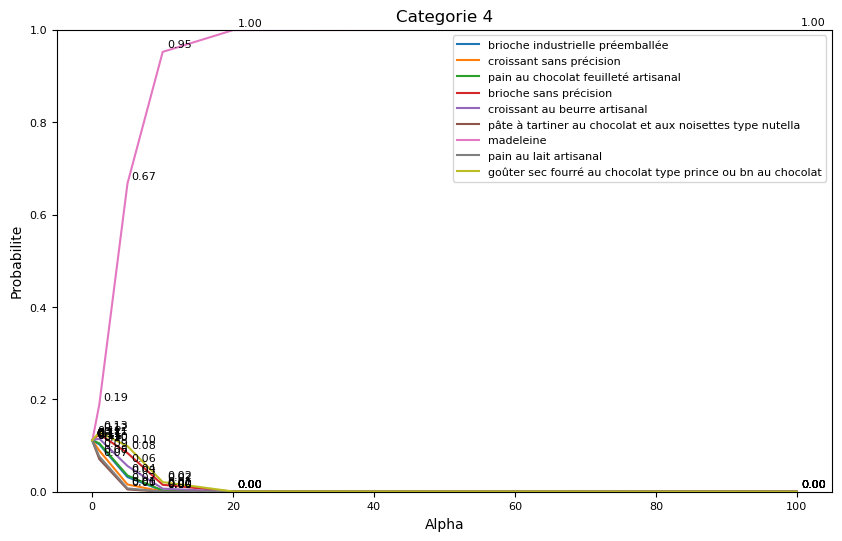

categorie 5


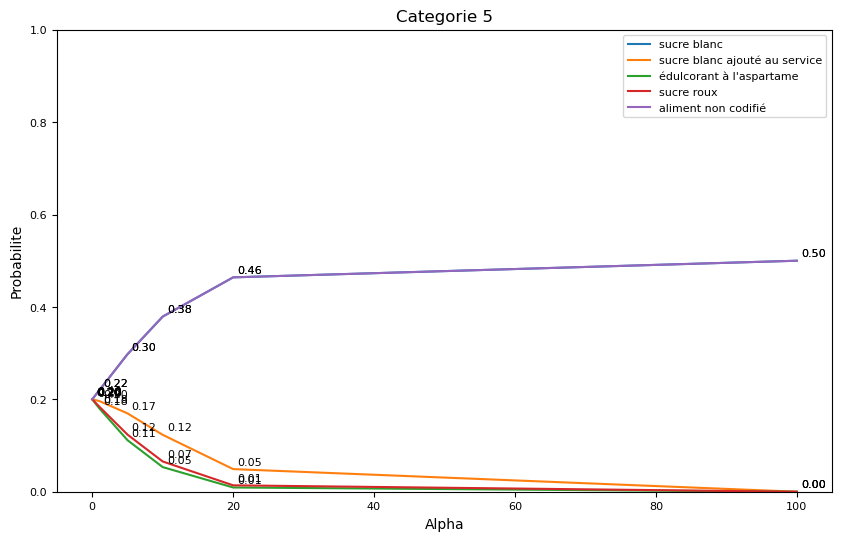

categorie 6
categorie 7


In [150]:
#CALCUL DES PROBABILITES DES ALIMENTS en fonction de alpha et pour un individu donné: aliments déjà consommés dans le passé

ind=110391    
c=8
model=w2v_cbow_pdj_freq_load         
alpha=[0, 0.1, 1, 5, 10, 20, 100]

for i in range(c):
    print("consommations reelles de la catégorie:", i, d_indiv_cluster_names_6j[ind][i])

similarities = {}
proba = {}
for i in range(c):
    print("categorie", i)
    dic_proba={}  
    if d_indiv_cluster_names_6j[ind][i]!=[]:
        for a in alpha:  
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:         
                similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                * norm(model.wv[e]))
                proba[e] = np.exp(a*similarities[e])
                p.append(proba[e]) 
            p=np.array(p)
            p_normalized = p / np.sum(p) 
            dic_proba[a]=p_normalized


        dic_proba_aliment={}
        for e in dico_cluster_codes[i]:
            liste=[]
            for a in alpha:
                liste.append(dic_proba[a][dico_cluster_codes[i].index(e)])
            dic_proba_aliment[e]=liste

    
        fig, ax = plt.subplots(figsize=(10, 6))

        for e in dico_cluster_codes[i]:
            x = alpha
            y = dic_proba_aliment[e]
            ax.plot(x, y, label=dic_alim[e])
        # Add labels for each data point
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.2f}", xy=(xi, yi), xytext=(3, 3), textcoords='offset points', fontsize=8)
        ax.legend(fontsize=8)
        ax.tick_params(axis='both', labelsize=8)
        ax.set_title(f"Categorie {i}", fontsize=12)
        ax.set_xlabel("Alpha", fontsize=10)
        ax.set_ylabel("Probabilite", fontsize=10)
        ax.set_ylim([0, 1])
        plt.show()    
           

# Métriques de vraisemblance et ranking

In [152]:
d_indiv_cluster_6j

{110025: {0: [19041, 18066, 19041, 18066],
  1: [],
  2: [],
  3: [18004, 18004],
  4: [7601, 7601],
  5: [31016, 31016],
  6: [],
  7: []},
 110067: {0: [2012, 2012, 2012, 2012],
  1: [],
  2: [],
  3: [18004, 18004, 18004, 18004],
  4: [7601, 7601, 7601, 7601],
  5: [31016, 31016, 31016, 31016],
  6: [],
  7: []},
 110071: {0: [18066, 18066, 18066],
  1: [7001, 7001],
  2: [16400, 16400],
  3: [18004, 18004, 18004, 18004, 18004, 18004],
  4: [],
  5: [81052, 81052, 81052, 81052, 81052, 81052],
  6: [31008, 31008],
  7: []},
 110110: {0: [19041, 19041, 19041, 19041, 19041],
  1: [7001],
  2: [16402],
  3: [18020, 18020, 18020, 18020, 18020],
  4: [],
  5: [],
  6: [31008],
  7: []},
 110113: {0: [19041, 19050, 19050, 19050, 19050, 19050],
  1: [7001, 7001, 7001],
  2: [],
  3: [],
  4: [7741, 7741],
  5: [],
  6: [31006, 31006, 31006],
  7: [18150, 18150, 18150, 18150]},
 110125: {0: [13005, 13039, 18066],
  1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: []},
 110167: {0: []

In [71]:
# Calculer la frequence de consommation d'un cluster pour un individu

d_indiv_cluster_6j
d_cluster_freq_ind={}
c=8
beta=0.05

d_cluster_freq_ind={k: {i: 0 for i in range(c)} for k in d_6j.keys()}
alim=0
for key, value in d_indiv_cluster_6j.items():
    for e in d_6j[key]:
        alim+=len(d_6j[key][e])
    for subkey, subvalue in value.items():
#         print(key, subkey, subvalue)
        if alim!=0:
            d_cluster_freq_ind[key][subkey]+=(len(d_indiv_cluster_6j[key][subkey]))/alim  
    alim=0
    cat=0
d_cluster_freq_ind

            
for key in d_cluster_freq_ind.keys():
    no_cat=0
    for value, subvalue in d_cluster_freq_ind[key].items():
        if subvalue==0:
            no_cat+=1
    for value, subvalue in d_cluster_freq_ind[key].items():    
        if subvalue==0:
            d_cluster_freq_ind[key][value]=beta
        elif subvalue!=0:
            d_cluster_freq_ind[key][value]*=(1-beta*8)
            d_cluster_freq_ind[key][value]+=beta
d_cluster_freq_ind            

{110025: {0: 0.29,
  1: 0.05,
  2: 0.05,
  3: 0.16999999999999998,
  4: 0.16999999999999998,
  5: 0.16999999999999998,
  6: 0.05,
  7: 0.05},
 110067: {0: 0.2, 1: 0.05, 2: 0.05, 3: 0.2, 4: 0.2, 5: 0.2, 6: 0.05, 7: 0.05},
 110071: {0: 0.1357142857142857,
  1: 0.10714285714285714,
  2: 0.10714285714285714,
  3: 0.22142857142857142,
  4: 0.05,
  5: 0.22142857142857142,
  6: 0.10714285714285714,
  7: 0.05},
 110110: {0: 0.28076923076923077,
  1: 0.09615384615384616,
  2: 0.09615384615384616,
  3: 0.28076923076923077,
  4: 0.05,
  5: 0.05,
  6: 0.09615384615384616,
  7: 0.05},
 110113: {0: 0.25,
  1: 0.15,
  2: 0.05,
  3: 0.05,
  4: 0.11666666666666667,
  5: 0.05,
  6: 0.15,
  7: 0.18333333333333335},
 110125: {0: 0.65,
  1: 0.05,
  2: 0.05,
  3: 0.05,
  4: 0.05,
  5: 0.05,
  6: 0.05,
  7: 0.05},
 110167: {0: 0.05,
  1: 0.05,
  2: 0.05,
  3: 0.35,
  4: 0.05,
  5: 0.35,
  6: 0.05,
  7: 0.05},
 110194: {0: 0.16999999999999998,
  1: 0.09,
  2: 0.05,
  3: 0.21000000000000002,
  4: 0.16999999999

In [69]:
# CALCUL POUR LE JOUR CACHE DU RATIO D ALIMENTS NOUVEAUX VERSUS ALIMENTS DEJA CONSOMMES DANS LE PASSE 

c=8
model=w2v_cbow_pdj_freq_load
oldF_oldC_ratio=0
newF_oldC_ratio=0
newF_newC_ratio=0


liste_users=list(d_indiv_cluster_6j.keys())

for user in liste_users:
    ind=user           
    old_food_old_cat=0
    new_food_old_cat=0
    new_food_new_cat=0
    cat=0    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            cat+=1
    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                for j in d_indiv_cluster_1j[ind][i]:
                    if j in d_indiv_cluster_6j[ind][i]: 
                        old_food_old_cat+=1 
                    elif j not in d_indiv_cluster_6j[ind][i]:
                        new_food_old_cat+=1
            elif d_indiv_cluster_names_6j[ind][i]==[]:        
                for j in d_indiv_cluster_1j[ind][i]:
                        new_food_new_cat+=1
    total_food=old_food_old_cat+new_food_old_cat+new_food_new_cat                              
                
    oldF_oldC_ratio += old_food_old_cat/total_food
    newF_oldC_ratio += new_food_old_cat/total_food
    newF_newC_ratio += new_food_new_cat/total_food


print("OUR MODEL=> mean oldF_oldC_ratio", oldF_oldC_ratio/len(liste_users))
print("OUR MODEL=> mean newF_oldC_ratio",  newF_oldC_ratio/len(liste_users))
print("OUR MODEL=> mean newF_newC_ratio", newF_newC_ratio/len(liste_users))

OUR MODEL=> mean oldF_oldC_ratio 0.893702283902691
OUR MODEL=> mean newF_oldC_ratio 0.0629480460662526
OUR MODEL=> mean newF_newC_ratio 0.04334967003105595


In [72]:
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR UN INDIVIDU  
# AVEC NOTRE MODELE  ET ALPHA =1

ind=110113    
c=8
model=w2v_cbow_pdj_freq_load
alpha=1
beta=0.05

for i in range(c):
    print("conso jours de recueil non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
for i in range(c):
    print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])

dic_proba={} 
similarities = {}
proba = {}

for i in range(c):    
    if d_indiv_cluster_names_6j[ind][i]!=[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:         
            similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                * norm(model.wv[e]))
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e]) 
        p=np.array(p)
        p_normalized = p / np.sum(p) 
        dic_proba[i]=p_normalized
    elif d_indiv_cluster_names_6j[ind][i]==[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:  
            similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e]) 
        p=np.array(p)
        p_normalized = p / np.sum(p) 
        dic_proba[i]=p_normalized
print(dic_proba)
print(d_cluster_freq_ind[ind])              
     
log_likelihood=0
log_like_old=0
log_like_new=0
cat=0
for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        cat+=1
print("nombre catégorie", cat)

for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            for j in d_indiv_cluster_1j[ind][i]:
                if j in d_indiv_cluster_6j[ind][i]: 
                    index = dico_cluster_codes[i].index(j)
                    log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                elif j not in d_indiv_cluster_6j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
        elif d_indiv_cluster_names_6j[ind][i]==[]:        
            for j in d_indiv_cluster_1j[ind][i]:
                index2= dico_cluster_codes[i].index(j)
                log_like_new += np.log((dic_proba[i][index2])*beta)
log_likelihood=log_like_old+log_like_new 

print("OUR MODEL- 1 indiv- total log likelihood", log_likelihood)           
print("OUR MODEL- 1 indiv- old log likelihood", log_like_old)     
print("OUR MODEL- 1 indiv- new log likelihood", log_like_new)     

conso jours de recueil non cachés - catégorie: 0 ['lait demi-écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht']
conso jours de recueil non cachés - catégorie: 1 ['pain baguette', 'pain baguette', 'pain baguette']
conso jours de recueil non cachés - catégorie: 2 []
conso jours de recueil non cachés - catégorie: 3 []
conso jours de recueil non cachés - catégorie: 4 ['brioche sans précision', 'brioche sans précision']
conso jours de recueil non cachés - catégorie: 5 []
conso jours de recueil non cachés - catégorie: 6 ['confiture ou marmelade tout type', 'confiture ou marmelade tout type', 'confiture ou marmelade tout type']
conso jours de recueil non cachés - catégorie: 7 ['poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré']
conso jour caché - catég

In [156]:
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR UN INDIVIDU  
# AVEC NOTRE MODELE ET ALPHA=10

ind=110113    
c=8
model=w2v_cbow_pdj_freq_load
alpha=100
beta=0.05

for i in range(c):
    print("conso jours de recueil non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
for i in range(c):
    print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])


dic_proba={} 
similarities = {}
proba = {}

for i in range(c):    
    if d_indiv_cluster_names_6j[ind][i]!=[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:         
            similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                * norm(model.wv[e]))
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e]) 
        p=np.array(p)
        p_normalized = p / np.sum(p) 
        dic_proba[i]=p_normalized
    elif d_indiv_cluster_names_6j[ind][i]==[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:  
            similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e]) 
        p=np.array(p)
        p_normalized = p / np.sum(p) 
        dic_proba[i]=p_normalized
print(dic_proba)
print(d_cluster_freq_ind[ind])              
   
    
log_likelihood=0
log_like_old=0
log_like_new=0
cat=0
for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        cat+=1
print("nombre catégorie", cat)

for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            for j in d_indiv_cluster_1j[ind][i]:
                if j in d_indiv_cluster_6j[ind][i]: 
                    index = dico_cluster_codes[i].index(j)
                    log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                elif j not in d_indiv_cluster_6j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
        elif d_indiv_cluster_names_6j[ind][i]==[]:        
            for j in d_indiv_cluster_1j[ind][i]:
                index2= dico_cluster_codes[i].index(j)
                log_like_new += np.log((dic_proba[i][index2])*beta)
log_likelihood=log_like_old+log_like_new 

print("OUR MODEL- 1 indiv- total log likelihood", log_likelihood)           
print("OUR MODEL- 1 indiv- old log likelihood", log_like_old)     
print("OUR MODEL- 1 indiv- new log likelihood", log_like_new)     

conso jours de recueil non cachés - catégorie: 0 ['lait demi-écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht']
conso jours de recueil non cachés - catégorie: 1 ['pain baguette', 'pain baguette', 'pain baguette']
conso jours de recueil non cachés - catégorie: 2 []
conso jours de recueil non cachés - catégorie: 3 []
conso jours de recueil non cachés - catégorie: 4 ['brioche sans précision', 'brioche sans précision']
conso jours de recueil non cachés - catégorie: 5 []
conso jours de recueil non cachés - catégorie: 6 ['confiture ou marmelade tout type', 'confiture ou marmelade tout type', 'confiture ou marmelade tout type']
conso jours de recueil non cachés - catégorie: 7 ['poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré']
conso jour caché - catég

In [76]:
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 
# AVEC NOTRE MODELE ET ALPHA=1

c=8
model=w2v_cbow_pdj_freq_load
alpha=1
beta=0.05
log_like_all=0
log_like_all_old=0
log_like_all_new=0


# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())

for user in liste_users:
    ind=user    
#     for i in range(c):
#         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
#     for i in range(c):
#             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   

    dic_proba={}  
    similarities = {}
    proba = {}
    for i in range(c):    
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:         
                similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                    * norm(model.wv[e]))
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e]) 
            p=np.array(p)
            p_normalized = p / np.sum(p) 
            dic_proba[i]=p_normalized
        elif d_indiv_cluster_names_6j[ind][i]==[]:
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:  
                similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e]) 
            p=np.array(p)
            p_normalized = p / np.sum(p) 
            dic_proba[i]=p_normalized
#     print(dic_proba)              
        
            
    log_likelihood=0
    log_like_old=0
    log_like_new=0
    cat=0    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            cat+=1
    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                for j in d_indiv_cluster_1j[ind][i]:
                    if j in d_indiv_cluster_6j[ind][i]: 
                        index = dico_cluster_codes[i].index(j)
                        log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                    elif j not in d_indiv_cluster_6j[ind][i]:
                        index2= dico_cluster_codes[i].index(j)
                        log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
            elif d_indiv_cluster_names_6j[ind][i]==[]:        
                for j in d_indiv_cluster_1j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*beta)
    log_likelihood=log_like_old+log_like_new                              
                
    log_like_all += log_likelihood
    log_like_all_old += log_like_old
    log_like_all_new += log_like_new

print("alpha=", alpha)
print("OUR MODEL- total log likelihood", log_like_all)
print("OUR MODEL=> mean total log likelihood", log_like_all/len(liste_users))
print("OUR MODEL => MEAN old log likelihood", log_like_all_old/len(liste_users))
print("OUR MODEL => MEAN new log likelihood", log_like_all_new/len(liste_users))
    


alpha= 1
OUR MODEL- total log likelihood -18340.62354209437
OUR MODEL=> mean total log likelihood -12.459662732401068
OUR MODEL => MEAN old log likelihood -10.725337527742703
OUR MODEL => MEAN new log likelihood -1.7343252046583673


In [74]:
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 
# AVEC NOTRE MODELE ET ALPHA=15

c=8
model=w2v_cbow_pdj_freq_load
alpha=15
beta=0.05
log_like_all=0
log_like_all_old=0
log_like_all_new=0


# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())

for user in liste_users:
    ind=user    
#     for i in range(c):
#         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
#     for i in range(c):
#             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   

    dic_proba={}    
    similarities = {}
    proba = {}
    
    for i in range(c):    
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:         
                similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                    * norm(model.wv[e]))
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e]) 
            p=np.array(p)
            p_normalized = p / np.sum(p) 
            dic_proba[i]=p_normalized
        elif d_indiv_cluster_names_6j[ind][i]==[]:
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:  
                similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e]) 
            p=np.array(p)
            p_normalized = p / np.sum(p) 
            dic_proba[i]=p_normalized
#     print(dic_proba)              
        
            
    log_likelihood=0
    log_like_old=0
    log_like_new=0
    cat=0    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            cat+=1
    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                for j in d_indiv_cluster_1j[ind][i]:
                    if j in d_indiv_cluster_6j[ind][i]: 
                        index = dico_cluster_codes[i].index(j)
                        log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                    elif j not in d_indiv_cluster_6j[ind][i]:
                        index2= dico_cluster_codes[i].index(j)
                        log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
            elif d_indiv_cluster_names_6j[ind][i]==[]:        
                for j in d_indiv_cluster_1j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*beta)
    log_likelihood=log_like_old+log_like_new                              
                
    log_like_all += log_likelihood
    log_like_all_old += log_like_old
    log_like_all_new += log_like_new
    
print("alpha=", alpha)
print("OUR MODEL- total log likelihood", log_like_all)
print("OUR MODEL=> MEAN total log likelihood", log_like_all/len(liste_users))
print("OUR MODEL => MEAN old log likelihood", log_like_all_old/len(liste_users))
print("OUR MODEL => MEAN new log likelihood", log_like_all_new/len(liste_users))
    

alpha= 15
OUR MODEL- total log likelihood -14708.86276540828
OUR MODEL=> MEAN total log likelihood -9.992433943891495
OUR MODEL => MEAN old log likelihood -7.531408572331723
OUR MODEL => MEAN new log likelihood -2.4610253715597734


LV totale: [-13.111112459368396, -12.459662732401068, -10.880819967669215, -10.145813855706301, -9.992433943891495, -10.117475857530538, -10.395476137656916, -10.765804782660522, -11.195508536511602, -11.665129700268464, -12.162539955366073, -12.67988539219033, -13.21191944788242, -13.75503672711345, -14.306692275399271, -14.865043705912713, -15.428725929394108, -15.99670632384316, -18.29804828246473, -21.212284512460243, -24.146324246633384, -27.090111019513696, -30.03917389722727]
LV old: [-11.381422901787596, -10.725337527742703, -9.024553719350315, -8.01512711357881, -7.531408572331723, -7.299832236862929, -7.206650155104688, -7.196686755351591, -7.239889433950709, -7.318515227740515, -7.421532725546059, -7.541832769715017, -7.674698836123168, -7.816917643012317, -7.966243789228527, -8.121069833447859, -8.28021887033285, -8.442811486886347, -9.116288077773284, -9.986825347960622, -10.87196825784874, -11.764085355338931, -12.659892643212647]
LV new: [-1.7296895575808138, -1.73432520

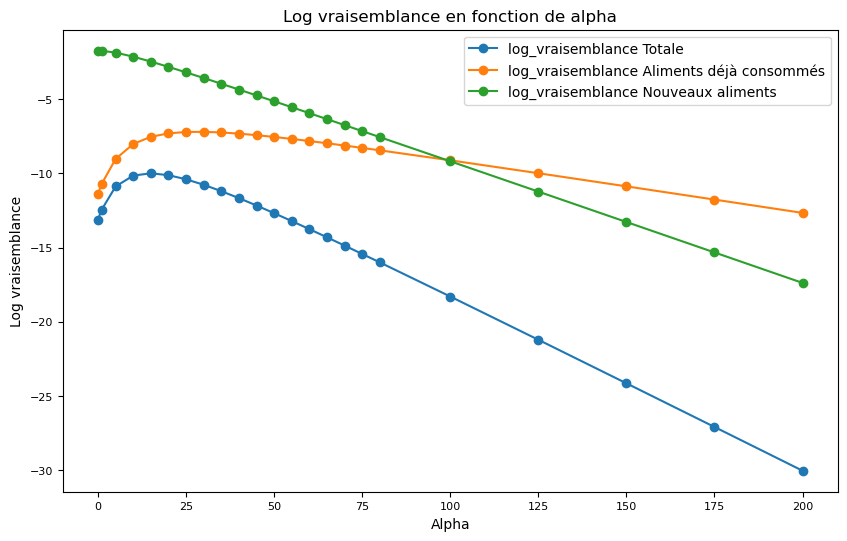

In [75]:
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 
# AVEC NOTRE MODELE ET COURBE DES VALEURS D'ALPHA
# TEST SUR UNE GAMME LARGE


c=8
model=w2v_cbow_pdj_freq_load
alpha_values=[0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100, 125, 150, 175, 200]

beta=0.05
# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())
tot_log_lkl_mean=[]
log_like_all_old_mean=[]
log_like_all_new_mean=[]

for alpha in alpha_values: 
    log_like_all=0
    log_like_all_old=0
    log_like_all_new=0
    for user in liste_users:
        ind=user    
    #     for i in range(c):
    #         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
    #     for i in range(c):
    #             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   

        dic_proba={}
        similarities = {}
        proba = {}
        for i in range(c):    
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:         
                    similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                        * norm(model.wv[e]))
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e]) 
                p=np.array(p)
                p_normalized = p / np.sum(p) 
                dic_proba[i]=p_normalized
            elif d_indiv_cluster_names_6j[ind][i]==[]:
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:  
                    similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e]) 
                p=np.array(p)
                p_normalized = p / np.sum(p) 
                dic_proba[i]=p_normalized
    #     print(dic_proba)              

        log_likelihood=0
        log_like_old=0
        log_like_new=0
        cat=0    
        for i in range(c):
            if d_indiv_cluster_names_1j[ind][i]!=[]:
                cat+=1

        for i in range(c):
            if d_indiv_cluster_names_1j[ind][i]!=[]:
                if d_indiv_cluster_names_6j[ind][i]!=[]:
                    for j in d_indiv_cluster_1j[ind][i]:
                        if j in d_indiv_cluster_6j[ind][i]: 
                            index = dico_cluster_codes[i].index(j)
                            log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                        elif j not in d_indiv_cluster_6j[ind][i]:
                            index2= dico_cluster_codes[i].index(j)
                            log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
                elif d_indiv_cluster_names_6j[ind][i]==[]:        
                    for j in d_indiv_cluster_1j[ind][i]:
                        index2= dico_cluster_codes[i].index(j)
                        log_like_new += np.log((dic_proba[i][index2])*beta)
        log_likelihood=log_like_old+log_like_new                              

        log_like_all += log_likelihood
        log_like_all_old += log_like_old
        log_like_all_new += log_like_new

    tot_log_lkl_mean.append(log_like_all/len(liste_users))
    log_like_all_old_mean.append(log_like_all_old/len(liste_users))    
    log_like_all_new_mean.append(log_like_all_new/len(liste_users))                             
        
fig, ax = plt.subplots(figsize=(10, 6))
x = alpha_values
y1 = tot_log_lkl_mean
y2 = log_like_all_old_mean
y3 = log_like_all_new_mean
print("LV totale:", y1)
print("LV old:", y2)
print("LV new:", y3)

ax.plot(x, y1, 'o-', label="log_vraisemblance Totale")
ax.plot(x, y2, 'o-', label='log_vraisemblance Aliments déjà consommés')
ax.plot(x, y3, 'o-', label='log_vraisemblance Nouveaux aliments')
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=8)
ax.set_title(f"Log vraisemblance en fonction de alpha", fontsize=12)
ax.set_xlabel("Alpha", fontsize=10)
ax.set_ylabel("Log vraisemblance", fontsize=10)
ax.legend(fontsize=10) 
plt.savefig("loglikelihood_alpha.jpg")
plt.show()  




[-13.111112459368396, -12.459662732401068, -11.929765469148625, -11.501762208058569, -11.157355360209204, -10.880819967669215, -10.65911935498829, -10.481889676378072, -10.341135259294253, -10.230709379764807, -10.145813855706301, -10.082624499231999, -10.0380374136828, -10.009499212885164, -9.994889296217456, -9.992433943891495, -10.000640773760713, -10.018247222337703, -10.04417937817759, -10.077518827443038, -10.117475857530538, -10.163367757528052, -10.214601214606194, -10.270658000289675, -10.331083296368043, -10.395476137656916, -10.463481553128817, -10.534784071659466, -10.609102326849817, -10.686184549882169, -10.765804782660522, -10.84775967774512, -10.931865778644118, -11.017957195372754, -11.105883607037198, -11.195508536511602]
[-11.381422901787596, -10.725337527742703, -10.178432320222733, -9.723216416576339, -9.343298413427693, -9.024553719350315, -8.75525376814546, -8.526069365926928, -8.329804701643479, -8.160929711968484, -8.01512711357881, -7.888953834017786, -7.77961

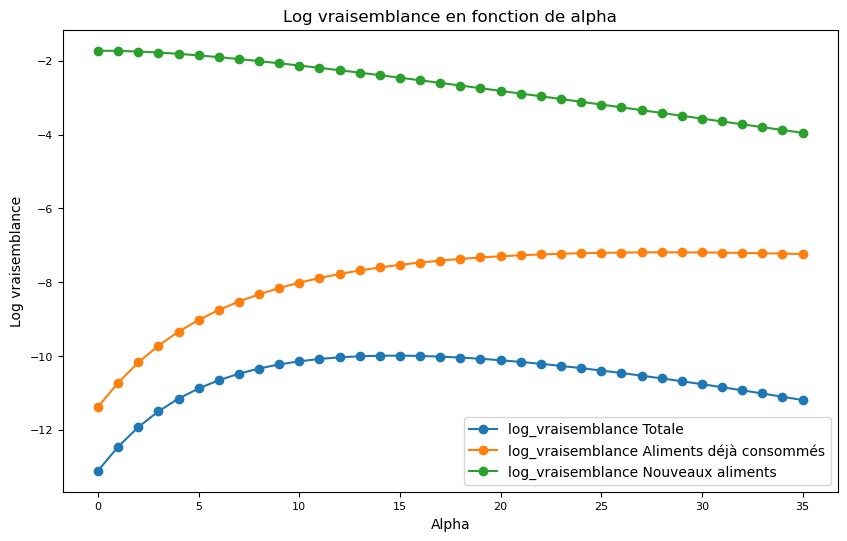

alpha* total, old, new: 15 28 0


In [74]:
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 
# AVEC NOTRE MODELE ET COURBE DES VALEURS D'ALPHA 
# FOCUS SUR UNE GAMME RESTREINTE 

c=8
model=w2v_cbow_pdj_freq_load
alpha_values=[i for i in range(36)]
beta=0.05

# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())
tot_log_lkl_mean=[]
log_like_all_old_mean=[]
log_like_all_new_mean=[]

for alpha in alpha_values: 
    log_like_all=0
    log_like_all_old=0
    log_like_all_new=0
    for user in liste_users:
        ind=user    
    #     for i in range(c):
    #         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
    #     for i in range(c):
    #             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   

        dic_proba={}   
        similarities = {}
        proba = {}
        for i in range(c):    
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:         
                    similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                        * norm(model.wv[e]))
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e]) 
                p=np.array(p)
                p_normalized = p / np.sum(p) 
                dic_proba[i]=p_normalized
            elif d_indiv_cluster_names_6j[ind][i]==[]:
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:  
                    similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e]) 
                p=np.array(p)
                p_normalized = p / np.sum(p) 
                dic_proba[i]=p_normalized
    #     print(dic_proba)              

        log_likelihood=0
        log_like_old=0
        log_like_new=0
        cat=0    
        for i in range(c):
            if d_indiv_cluster_names_1j[ind][i]!=[]:
                cat+=1

        for i in range(c):
            if d_indiv_cluster_names_1j[ind][i]!=[]:
                if d_indiv_cluster_names_6j[ind][i]!=[]:
                    for j in d_indiv_cluster_1j[ind][i]:
                        if j in d_indiv_cluster_6j[ind][i]: 
                            index = dico_cluster_codes[i].index(j)
                            log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                        elif j not in d_indiv_cluster_6j[ind][i]:
                            index2= dico_cluster_codes[i].index(j)
                            log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
                elif d_indiv_cluster_names_6j[ind][i]==[]:        
                    for j in d_indiv_cluster_1j[ind][i]:
                        index2= dico_cluster_codes[i].index(j)
                        log_like_new += np.log((dic_proba[i][index2])*beta)
        log_likelihood=log_like_old+log_like_new                              

        log_like_all += log_likelihood
        log_like_all_old += log_like_old
        log_like_all_new += log_like_new

    tot_log_lkl_mean.append(log_like_all/len(liste_users))
    log_like_all_old_mean.append(log_like_all_old/len(liste_users))    
    log_like_all_new_mean.append(log_like_all_new/len(liste_users))                             
        
fig, ax = plt.subplots(figsize=(10, 6))
x = alpha_values
y1 = tot_log_lkl_mean
y2 = log_like_all_old_mean
y3 = log_like_all_new_mean
print(y1)
print(y2)
print(y3)

ax.plot(x, y1, 'o-', label="log_vraisemblance Totale")
ax.plot(x, y2, 'o-', label='log_vraisemblance Aliments déjà consommés')
ax.plot(x, y3, 'o-', label='log_vraisemblance Nouveaux aliments')
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=8)
ax.set_title(f"Log vraisemblance en fonction de alpha", fontsize=12)
ax.set_xlabel("Alpha", fontsize=10)
ax.set_ylabel("Log vraisemblance", fontsize=10)
ax.legend(fontsize=10) 
plt.savefig("loglikelihood_alpha.jpg")
plt.show()  


argmax_alpha_tot = np.argmax(tot_log_lkl_mean)
best_alpha_tot = alpha_values[argmax_alpha_tot]
argmax_alpha_old = np.argmax(log_like_all_old_mean)
best_alpha_old = alpha_values[argmax_alpha_old]
argmax_alpha_new = np.argmax(log_like_all_new_mean)
best_alpha_new = alpha_values[argmax_alpha_new]

print("alpha* total, old, new:", best_alpha_tot, best_alpha_old, best_alpha_new)

In [75]:
#AVEC UN MODELE RANDOM SUR LE CLUSTER (aliments du cluster équiprobables)
#CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR UN INDIVIDU  

ind=110113    
c=8
model=w2v_cbow_pdj_freq_load
alpha=10
beta=0.05

for i in range(c):
    print("conso jours de recueil non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
for i in range(c):
    print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])


dic_proba={} 
proba = {}
for i in range(c):    
    p=[]
    p_normalized=[]
    for e in dico_cluster_codes[i]:   
        proba[e] = 1/len(dico_cluster_codes[i])
        p.append(proba[e]) 
    p=np.array(p)
    p_normalized = p
    dic_proba[i]=p_normalized
print(dic_proba)


log_likelihood=0
log_like_old=0
log_like_new=0
cat=0
for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        cat+=1
print("nombre catégorie", cat)

for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            for j in d_indiv_cluster_1j[ind][i]:
                if j in d_indiv_cluster_6j[ind][i]: 
                    index = dico_cluster_codes[i].index(j)
                    log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                elif j not in d_indiv_cluster_6j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
        elif d_indiv_cluster_names_6j[ind][i]==[]:        
            for j in d_indiv_cluster_1j[ind][i]:
                index2= dico_cluster_codes[i].index(j)
                log_like_new += np.log((dic_proba[i][index2])*beta)
log_likelihood=log_like_old+log_like_new             
            
print("RANDOM ON CLUSTER - 1 indiv - total log likelihood", log_likelihood)           
print("RANDOM ON CLUSTER - 1 indiv - old log likelihood", log_like_old)     
print("RANDOM ON CLUSTER - 1 indiv - new log likelihood", log_like_new)   


conso jours de recueil non cachés - catégorie: 0 ['lait demi-écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht']
conso jours de recueil non cachés - catégorie: 1 ['pain baguette', 'pain baguette', 'pain baguette']
conso jours de recueil non cachés - catégorie: 2 []
conso jours de recueil non cachés - catégorie: 3 []
conso jours de recueil non cachés - catégorie: 4 ['brioche sans précision', 'brioche sans précision']
conso jours de recueil non cachés - catégorie: 5 []
conso jours de recueil non cachés - catégorie: 6 ['confiture ou marmelade tout type', 'confiture ou marmelade tout type', 'confiture ou marmelade tout type']
conso jours de recueil non cachés - catégorie: 7 ['poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré']
conso jour caché - catég

In [77]:
#AVEC UN MODELE RANDOM SUR LE CLUSTER (aliments du cluster équiprobables)
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 

c=8
model=w2v_cbow_pdj_freq_load
alpha=10
beta=0.05
log_like_all=0
log_like_all_old=0
log_like_all_new=0

# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())

for user in liste_users:
    ind=user    
#     for i in range(c):
#         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
#     for i in range(c):
#             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   
    dic_proba={}  
    proba = {}
    for i in range(c):    
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:             
            proba[e] = 1/len(dico_cluster_codes[i])
            p.append(proba[e])
        p=np.array(p)
        p_normalized = p
        dic_proba[i]=p_normalized
#     print(dic_proba)
            
    log_likelihood=0
    log_like_old=0
    log_like_new=0
    cat=0    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            cat+=1
   
    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                for j in d_indiv_cluster_1j[ind][i]:
                    if j in d_indiv_cluster_6j[ind][i]: 
                        index = dico_cluster_codes[i].index(j)
                        log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                    elif j not in d_indiv_cluster_6j[ind][i]:
                        index2= dico_cluster_codes[i].index(j)
                        log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
            elif d_indiv_cluster_names_6j[ind][i]==[]:        
                for j in d_indiv_cluster_1j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*beta)
    log_likelihood=log_like_old+log_like_new                              
                
    log_like_all += log_likelihood
    log_like_all_old += log_like_old
    log_like_all_new += log_like_new    
    

print("RANDOM ON CLUSTER - total log likelihood", log_like_all)
print("RANDOM ON CLUSTER => mean total log likelihood", log_like_all/len(liste_users))
print("RANDOM ON CLUSTER - old log likelihood", log_like_all_old/len(liste_users))
print("RANDOM ON CLUSTER - new log likelihood", log_like_all_new/len(liste_users))
    

RANDOM ON CLUSTER - total log likelihood -19299.55754019028
RANDOM ON CLUSTER => mean total log likelihood -13.111112459368396
RANDOM ON CLUSTER - old log likelihood -11.381422901787596
RANDOM ON CLUSTER - new log likelihood -1.7296895575808138


In [78]:
#AVEC UN MODELE RANDOM (aliments du petit déjeuner équiprobables)
#CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR UN INDIVIDU  

# Rappel du nombre d'aliments 
longueur=0
for i in range(c):
    longueur+=len(dico_cluster_codes[i])
print(longueur)


ind=110113    
c=8
model=w2v_cbow_pdj_freq_load
beta=0.05

for i in range(c):
    print("conso jours de recueil non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
for i in range(c):
    print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])

dic_proba={}
proba = {}
for i in range(c):    
    p=[]
    p_normalized=[]
    for e in dico_cluster_codes[i]:   
        proba[e] = 1/longueur
        p.append(proba[e]) 
    p=np.array(p)
    p_normalized = p
    dic_proba[i]=p_normalized
print(dic_proba)

log_likelihood=0
log_like_old=0
log_like_new=0
cat=0
for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        cat+=1
print("nombre catégorie", cat)

for i in range(c):
    if d_indiv_cluster_names_1j[ind][i]!=[]:
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            for j in d_indiv_cluster_1j[ind][i]:
                if j in d_indiv_cluster_6j[ind][i]: 
                    log_like_old += np.log(1/longueur)
                elif j not in d_indiv_cluster_6j[ind][i]:
                    log_like_new += np.log(1/longueur)
        elif d_indiv_cluster_names_6j[ind][i]==[]:        
            for j in d_indiv_cluster_1j[ind][i]:
                log_like_new += np.log(1/longueur)
log_likelihood=log_like_old+log_like_new   


print("RANDOM  - 1 indiv - total log likelihood", log_likelihood)           
print("RANDOM - 1 indiv - old log likelihood", log_like_old)     
print("RANDOM  - 1 indiv - new log likelihood", log_like_new)   


56
conso jours de recueil non cachés - catégorie: 0 ['lait demi-écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht', 'lait écrémé uht']
conso jours de recueil non cachés - catégorie: 1 ['pain baguette', 'pain baguette', 'pain baguette']
conso jours de recueil non cachés - catégorie: 2 []
conso jours de recueil non cachés - catégorie: 3 []
conso jours de recueil non cachés - catégorie: 4 ['brioche sans précision', 'brioche sans précision']
conso jours de recueil non cachés - catégorie: 5 []
conso jours de recueil non cachés - catégorie: 6 ['confiture ou marmelade tout type', 'confiture ou marmelade tout type', 'confiture ou marmelade tout type']
conso jours de recueil non cachés - catégorie: 7 ['poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré', 'poudre soluble à base de chicorée et de café type ricoré']
conso jour caché - ca

In [79]:
#AVEC UN MODELE RANDOM (aliments du petit déjeuner équiprobables)
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 

#Rappel du nombre d'aliments 
longueur=0
for i in range(c):
    longueur+=len(dico_cluster_codes[i])
print(longueur)

c=8
model=w2v_cbow_pdj_freq_load
beta=0.05
log_like_all=0
log_like_all_old=0
log_like_all_new=0

# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())

for user in liste_users:
    ind=user    
#     for i in range(c):
#         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
#     for i in range(c):
#             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   

    dic_proba={}  
    proba = {}
    for i in range(c):    
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:          
            proba[e] = 1/longueur
            p.append(proba[e])
        p=np.array(p)
        p_normalized = p
        dic_proba[i]=p_normalized
#     print(dic_proba)
            
    log_likelihood=0
    log_like_old=0
    log_like_new=0
    cat=0    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            cat+=1
    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                for j in d_indiv_cluster_1j[ind][i]:
                    if j in d_indiv_cluster_6j[ind][i]: 
                        log_like_old += np.log(1/longueur)
                    elif j not in d_indiv_cluster_6j[ind][i]:
                        log_like_new += np.log(1/longueur)
            elif d_indiv_cluster_names_6j[ind][i]==[]:        
                for j in d_indiv_cluster_1j[ind][i]:
                    log_like_new += np.log(1/longueur)
    log_likelihood=log_like_old+log_like_new   

    log_like_all += log_likelihood
    log_like_all_old += log_like_old
    log_like_all_new += log_like_new   
    
print("RANDOM - total log likelihood", log_like_all)
print("RANDOM => mean total log likelihood", log_like_all/len(liste_users))
print("RANDOM - mean old log likelihood", log_like_all_old/len(liste_users))
print("RANDOM - mean new log likelihood", log_like_all_new/len(liste_users))
    

56
RANDOM - total log likelihood -21463.175215
RANDOM => mean total log likelihood -14.580961423233695
RANDOM - mean old log likelihood -12.970273824155559
RANDOM - mean new log likelihood -1.6106875990781213


In [80]:
# MOST POPULAR BY CLUSTER 
# définir l'aliment le plus populaire par cluster
# ensemble des consommations du cluster par l'ensemble des individus

c=8
beta=0.05
liste_conso_cluster={}
liste_conso_cluster_merge={}
mostpopular_byclust={}

for i in range(c):
    liste_conso_cluster[i]=[]
    liste_conso_cluster_merge[i]=[]
    
    
for i in range(c):
    for key in d_indiv_cluster_6j.keys():
        liste_conso_cluster[i].append(d_indiv_cluster_6j[key][i])
# print(liste_conso_cluster)

for i in range(c):
    for key, value in liste_conso_cluster.items():
        for sublist in value:
            for e in sublist:
                if key==i:
                    liste_conso_cluster_merge[i].append(e)
# print(liste_conso_cluster_merge)

from collections import Counter
for i in range(c):
    compteur = Counter(liste_conso_cluster_merge[i])
    element_plus_frequent, nombre_occurrences = compteur.most_common(1)[0]
    mostpopular_byclust[i]= element_plus_frequent
print(mostpopular_byclust)

for key,value in mostpopular_byclust.items():
    print(key, dic_alim[value])

#AVEC UN MODELE MOST POPULAR BY CLUSTER (aliments les plus fréquents par cluster)
# CALCUL DE LA VRAISEMBLANCE DES ALIMENTS DU JOUR CACHE POUR PLUSIEURS INDIVIDUS 

#Rappel du nombre d'aliments 
longueur=0
for i in range(c):
    longueur+=len(dico_cluster_codes[i])
print(longueur)

model=w2v_cbow_pdj_freq_load
alpha=10
log_like_all=0
log_like_all_old=0
log_like_all_new=0

# liste_users=[110113]
# liste_users=list(d_indiv_cluster_6j.keys())[0:10]
liste_users=list(d_indiv_cluster_6j.keys())

for user in liste_users:
    ind=user    
#     for i in range(c):
#         print("conso jours non cachés - catégorie:", i, d_indiv_cluster_names_6j[ind][i])
#     for i in range(c):
#             print("conso jour caché - catégorie:", i, d_indiv_cluster_names_1j[ind][i])   
    dic_proba={}  
    proba = {}
    for i in range(c):    
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]: 
            if e==mostpopular_byclust[i]:
                proba[e] = 1-0.0001*(len(dico_cluster_codes[i])-1)
            else:
                proba[e]=0.0001
            p.append(proba[e])
        p=np.array(p)
        p_normalized = p
        dic_proba[i]=p_normalized
#     print(dic_proba)
            
    log_likelihood=0
    log_like_old=0
    log_like_new=0
    cat=0    
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            cat+=1
            
            
    for i in range(c):
        if d_indiv_cluster_names_1j[ind][i]!=[]:
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                for j in d_indiv_cluster_1j[ind][i]:
                    if j in d_indiv_cluster_6j[ind][i]: 
                        index = dico_cluster_codes[i].index(j)
                        log_like_old += np.log((dic_proba[i][index])*(d_cluster_freq_ind[ind][i]))
                    elif j not in d_indiv_cluster_6j[ind][i]:
                        index2= dico_cluster_codes[i].index(j)
                        log_like_new += np.log((dic_proba[i][index2])*(d_cluster_freq_ind[ind][i]))
            elif d_indiv_cluster_names_6j[ind][i]==[]:        
                for j in d_indiv_cluster_1j[ind][i]:
                    index2= dico_cluster_codes[i].index(j)
                    log_like_new += np.log((dic_proba[i][index2])*beta)
    log_likelihood=log_like_old+log_like_new                              
                
    log_like_all += log_likelihood
    log_like_all_old += log_like_old
    log_like_all_new += log_like_new    

print("MOST POPULAR ON CLUSTER - total log likelihood", log_like_all)
print("MOST POPULAR ON CLUSTER => mean total log likelihood", log_like_all/len(liste_users))
print("MOST POPULAR ON CLUSTER=> MEAN old log likelihood", log_like_all_old/len(liste_users))
print("MOST POPULAR ON CLUSTER => MEAN new log likelihood", log_like_all_new/len(liste_users))
    

{0: 19041, 1: 7001, 2: 16400, 3: 18004, 4: 7740, 5: 31016, 6: 31006, 7: 18150}
0 lait demi-écrémé uht
1 pain baguette
2 beurre doux
3 café noir prêt à boire non sucré
4 brioche industrielle préemballée
5 sucre blanc
6 confiture ou marmelade tout type
7 poudre soluble à base de chicorée et de café type ricoré
56
MOST POPULAR ON CLUSTER - total log likelihood -32027.780277851558
MOST POPULAR ON CLUSTER => mean total log likelihood -21.758002906149155
MOST POPULAR ON CLUSTER=> MEAN old log likelihood -18.197130332344212
MOST POPULAR ON CLUSTER => MEAN new log likelihood -3.560872573804963


In [81]:
# Regarder les distances entre les aliments du cluster 0 et voir ensuite l'impact de différentes
# valeurs d'alpha sur les écarts de probabilités entre les aliments 

D_alimclust0 = pd.DataFrame(columns=['Code_A1','Code_A2','Nom_A1_inca','Nom_A2_inca', 
                               'Dist'], index = range((len(dico_cluster_codes[0])**2)))


#préciser le modèle W2V appris sur INCA 
model=w2v_cbow_pdj_freq_load

i=0
for j in range(len(dico_cluster_codes[0])):
    for k in range(len(dico_cluster_codes[0])):
        D_alimclust0.Code_A1[i]=dico_cluster_codes[0][k]
        D_alimclust0.Code_A2[i]=dico_cluster_codes[0][j]
        if (D_alimclust0.Code_A1[i] in model.wv) and (D_alimclust0.Code_A2[i] in model.wv):
            D_alimclust0.Dist[i]=model.wv.similarity(D_alimclust0.Code_A1[i], D_alimclust0.Code_A2[i])
            D_alimclust0.Nom_A1_inca[i]=dic_alim[D_alimclust0.Code_A1[i]]
            D_alimclust0.Nom_A2_inca[i]=dic_alim[D_alimclust0.Code_A2[i]]
        i+=1
              
Distnotnull=D_alimclust0[D_alimclust0["Dist"].notnull()]
Dist_diff_alim=Distnotnull[Distnotnull.Code_A1 != Distnotnull.Code_A2]
Dist_diff_alim.reset_index(drop=True, inplace=True)
Dist_diff_alim=Dist_diff_alim.sort_values('Dist', ascending=False)
for i in range(len(Dist_diff_alim)):
    if i in Dist_diff_alim.index:
        k=Dist_diff_alim.Code_A1[i]
        l=Dist_diff_alim.Code_A2[i]
        Dist_diff_alim=Dist_diff_alim.drop(Dist_diff_alim[(Dist_diff_alim.Code_A1==l) & (Dist_diff_alim.Code_A2==k)].index)
Dist_diff_alim        
# Dist_diff_alim.to_excel('dist_alim_pdj.xlsx', index=False)

Code_A1 Code_A2                                  Nom_A1_inca  \
108    2004    2070                 jus de fruits sans précision   
21    13021   18008                                   kiwi frais   
73     2013   19050                   jus d'orange pressé maison   
65    13021   13039                                   kiwi frais   
52     2070    2012                  pur jus d'orange pasteurisé   
96     2070    2013                  pur jus d'orange pasteurisé   
13    13034   18008                               orange fraîche   
15    13039   18008                      pomme non pelée fraîche   
97     2004    2013                 jus de fruits sans précision   
53     2004    2012                 jus de fruits sans précision   
25     2012   19041  jus d'orange à base de concentré pasteurisé   
43    13021   13034                                   kiwi frais   
29     2013   19041                   jus d'orange pressé maison   
31     2004   19041                 jus de fruits sans précision   
51     2013    2012                   jus d'orange pressé maison   
41     2070   13034                  pur jus d'orange pasteurisé   
27    19050   19041                              lait écrémé uht   
61    13005   13039                               banane fraîche   
19     2070   18008                  pur jus d'orange pasteurisé   
40     2013   13034                   jus d'orange pressé maison   
17    13005   18008                               banane fraîche   
30     2070   19041                  pur jus d'orange pasteurisé   
37    13039   13034                      pomme non pelée fraîche   
109   13021    2070                                   kiwi frais   
87    13021   13005                                   kiwi frais   
38    19050   13034                              lait écrémé uht   
39    13005   13034                               banane fraîche   
1     19041   18066                         lait demi-écrémé uht   
74     2070   19050                  pur jus d'orange pasteurisé   
42     2004   13034                 jus de fruits sans précision   
36     2012   13034  jus d'orange à base de concentré pasteurisé   
84     2013   13005                   jus d'orange pressé maison   
49    19050    2012                              lait écrémé uht   
18     2013   18008                   jus d'orange pressé maison   
75     2004   19050                 jus de fruits sans précision   
0     18008   18066                                eau de source   
85     2070   13005                  pur jus d'orange pasteurisé   
72    13005   19050                               banane fraîche   
120   13021    2004                                   kiwi frais   
20     2004   18008                 jus de fruits sans précision   
8      2070   18066                  pur jus d'orange pasteurisé   
98    13021    2013                                   kiwi frais   
63     2070   13039                  pur jus d'orange pasteurisé   
4     13039   18066                      pomme non pelée fraîche   
86     2004   13005                 jus de fruits sans précision   
9      2004   18066                 jus de fruits sans précision   
16    19050   18008                              lait écrémé uht   
14     2012   18008  jus d'orange à base de concentré pasteurisé   
24    13034   19041                               orange fraîche   
3      2012   18066  jus d'orange à base de concentré pasteurisé   
5     19050   18066                              lait écrémé uht   
7      2013   18066                   jus d'orange pressé maison   
60    19050   13039                              lait écrémé uht   
54    13021    2012                                   kiwi frais   
62     2013   13039                   jus d'orange pressé maison   
12    19041   18008                         lait demi-écrémé uht   
10    13021   18066                                   kiwi frais   
6     13005   18066                               banane fra

In [82]:
# créer un dictionnaire qui liste par individu l'ensemble des aliments (non rares) mangés sur 6 jours de recueil
# puis 1 jour de test 

# print(d_new)
d_6j={}
d_1j={}

for key, value in d_new.items():
    lon=len(d_new[key])
    k=0
    if lon>=2:
        for i in range(1,8):
            if i in d_new[key]:
                k+=1
                if k<lon:
                    d_6j.setdefault(key, {})[i]=d_new[key][i]
                if k==lon:
                    d_1j.setdefault(key, {})[0]=d_new[key][i]
# print(d_6j)
# print(d_1j)


d_indiv_freq_6j={k: [] for k in d_6j.keys()}

for key, value in d_6j.items():
    for subkey, subvalue in value.items():
        for e in subvalue:
            d_indiv_freq_6j[key].append(e)

# print(d_indiv_freq_6j)     

d_indiv_freq_1j={k: [] for k in d_1j.keys()}

for key, value in d_1j.items():
    for subkey, subvalue in value.items():
        for e in subvalue:
            d_indiv_freq_1j[key].append(e)

# d_indiv_freq_1j

In [ ]:
# with open("d_indiv_freq_6j.pickle", "wb") as fichier:
#     pickle.dump(d_indiv_freq_6j, fichier)
# with open("Alim_non_rare.pickle", "wb") as fichier:
#     pickle.dump(Alim_non_rare, fichier)
# with open("dico_alim_cluster.pickle", "wb") as fichier:
#     pickle.dump(dico_alim_cluster, fichier)
# with open("d_1j.pickle", "wb") as fichier:
#     pickle.dump(d_1j, fichier)

In [83]:
# !pip install lightfm
# import pickle
# import numpy as np
# with open("/d_indiv_freq_6j.pickle", "rb") as fichier:
#     d_indiv_freq_6j = pickle.load(fichier)
# with open("/Alim_non_rare.pickle", "rb") as fichier:
#     Alim_non_rare= pickle.load(fichier)
# with open("/dico_alim_cluster.pickle", "rb") as fichier:
#     dico_alim_cluster= pickle.load(fichier)
# with open("/d_1j.pickle", "rb") as fichier:
#     d_1j= pickle.load(fichier)
   
# from lightfm import LightFM

# from lightfm.data import Dataset

# # Initialize variables
# users = list(d_indiv_freq_6j.keys())
# items = Alim_non_rare

# # Create an empty list to store the interaction data
# interaction_data = []

# # Iterate over each user and calculate the frequency of food consumption
# for user in users:
#     for item in items:
#         if item in d_indiv_freq_6j[user]:
#             interaction_data.append((user, item))  # User has consumed the item

# print(interaction_data)

# # Create a Dataset object
# dataset = Dataset()

# # Fit the dataset with user and item IDs
# dataset.fit(users, items)

# # Build the interaction matrix
# train_data, _ = dataset.build_interactions(interaction_data)
# # print(train_data)

# # Définir les différentes valeurs d'hyperparamètres à tester
# # epochs = [100]
# epochs = [10, 1000]
# # no_components = [50]
# no_components = [10, 50, 100, 200]
# learning_rates = [1, 0.01]
# # learning_rates = [1, 0.01, 0.001, 0.0001]

# best_mrr = 0.0
# best_params = {}
# c=8
# # dic_bpr={k: {i: [] for i in range(c)} for k in list(d_indiv_freq_6j.keys())}


# for epoch in epochs:
#     for num_components in no_components:
#         for learning_rate in learning_rates:
#             dic_bpr={k: {i: [] for i in range(c)} for k in list(d_indiv_freq_6j.keys())}
#             # Créer un modèle LightFM avec les hyperparamètres actuels
#             model = LightFM(loss='logistic', learning_rate=learning_rate, no_components=num_components)
#              # Entraîner le modèle sur les données d'entraînement
#             model.fit(train_data, epochs=epoch, num_threads=1)

#             # Évaluer MRR sur les données de validation
#             total_mrr=0
#             for user_idx, user_id in enumerate(users):
#                 train_prediction=model.predict(user_idx, list(range(len(items))))
#                 # print(train_prediction)
#                 items_tries = sorted(range(len(train_prediction)), key=lambda i: train_prediction[i], reverse=True)
#                 # print(items_tries)
#                 alim_tries = [Alim_non_rare[element] for element in items_tries]
#                 # print(alim_tries)  
#                 for e in alim_tries:
#                     for i in range(c):
#                         if dico_alim_cluster[e]==i:
#                             dic_bpr[user_id][i].append(e) 
#                 # print(dic_bpr[user_id])
#                 real_conso=d_1j[user_id][0]
#                 # print(real_conso)

#                 mrr = 0
#                 for consumption in real_conso:
#                     if consumption in dic_bpr[user_id][dico_alim_cluster[consumption]]:
#                         rank = dic_bpr[user_id][dico_alim_cluster[consumption]].index(consumption)
#                         inverse_rank = 1/(rank+1)
#                         mrr += inverse_rank
#                 mrr /= len(real_conso)
#                 # print("mrr id", user_id, mrr)
#                 total_mrr+=mrr
                
#             performance=total_mrr/len(d_indiv_freq_6j.keys())
#             print("MRR moyenne sur tous les utilisateurs:", total_mrr/len(d_indiv_freq_6j.keys()))

#             if performance > best_mrr:
#                 best_mrr = performance
#                 best_params = {
#                 'no_components': num_components,
#                 'learning_rate': learning_rate,
#                 'epochs': epoch
#                  }    
  

# print("Meilleurs hyperparamètres :")
# print(best_params)
# print("Meilleure performance (MRR) :", best_mrr)  

# On obtient des valeurs optimales d'hyperparamètres mais ce n'est pas la bonne loss : 
# ici c'est loss logistique et il nous faut bpr loss

In [ ]:
#en testant avec bpr loss et les paramètres suivants on obtient (google colab):
# valeurs d'hyperparamètres testées
# epochs = [10, 1000, 5000]
# no_components = [10, 50, 100, 200]
# learning_rates = [5, 1, 0.01, 0.001]

# for epoch in epochs:
#   for num_components in no_components:
#     for learning_rate in learning_rates:

#RESULTATS 

# MRR moyenne sur tous les utilisateurs: 0.40680864309176107
# MRR moyenne sur tous les utilisateurs: 0.8040782894219667
# MRR moyenne sur tous les utilisateurs: 0.6658706922705135
# MRR moyenne sur tous les utilisateurs: 0.6541987316343156
# MRR moyenne sur tous les utilisateurs: 0.433881416854433
# MRR moyenne sur tous les utilisateurs: 0.85441940122489
# MRR moyenne sur tous les utilisateurs: 0.667894766358591
# MRR moyenne sur tous les utilisateurs: 0.6569329818989336
# MRR moyenne sur tous les utilisateurs: 0.4062122854998798
# MRR moyenne sur tous les utilisateurs: 0.8450208922913688
# MRR moyenne sur tous les utilisateurs: 0.67490307208948
# MRR moyenne sur tous les utilisateurs: 0.659485988610581
# MRR moyenne sur tous les utilisateurs: 0.4125717569310466
# MRR moyenne sur tous les utilisateurs: 0.8404909099124935
# MRR moyenne sur tous les utilisateurs: 0.6705639495387204
# MRR moyenne sur tous les utilisateurs: 0.6615893305746782
# MRR moyenne sur tous les utilisateurs: 0.3944194861453121
# MRR moyenne sur tous les utilisateurs: 0.8637938316589809
# MRR moyenne sur tous les utilisateurs: 0.8235879940057942
# MRR moyenne sur tous les utilisateurs: 0.7131721853349376
# MRR moyenne sur tous les utilisateurs: 0.39440111497520375
# MRR moyenne sur tous les utilisateurs: 0.880006354385599
# MRR moyenne sur tous les utilisateurs: 0.8685571320645079
# MRR moyenne sur tous les utilisateurs: 0.7570342332237384
# MRR moyenne sur tous les utilisateurs: 0.39295489319842714
# MRR moyenne sur tous les utilisateurs: 0.8781998042924629
# MRR moyenne sur tous les utilisateurs: 0.8745649401648283
# MRR moyenne sur tous les utilisateurs: 0.7561639830023472
# MRR moyenne sur tous les utilisateurs: 0.3799660072842816
# MRR moyenne sur tous les utilisateurs: 0.8768890825331281
# MRR moyenne sur tous les utilisateurs: 0.8757425070310841
# MRR moyenne sur tous les utilisateurs: 0.7593362685262682
# MRR moyenne sur tous les utilisateurs: 0.375321522289265
# MRR moyenne sur tous les utilisateurs: 0.8711454289596271
# MRR moyenne sur tous les utilisateurs: 0.8349044816206836
# MRR moyenne sur tous les utilisateurs: 0.7780160696010129
# MRR moyenne sur tous les utilisateurs: 0.42800272007545875
# MRR moyenne sur tous les utilisateurs: 0.8809069695517914
# MRR moyenne sur tous les utilisateurs: 0.8759317580100776
# MRR moyenne sur tous les utilisateurs: 0.798144919810536
# MRR moyenne sur tous les utilisateurs: 0.42072306210193594
# MRR moyenne sur tous les utilisateurs: 0.8772536312642084
# MRR moyenne sur tous les utilisateurs: 0.8761681405825668
# MRR moyenne sur tous les utilisateurs: 0.8067021235302978
# MRR moyenne sur tous les utilisateurs: 0.38579654952487524
# MRR moyenne sur tous les utilisateurs: 0.875082732905483
# MRR moyenne sur tous les utilisateurs: 0.8767713683553404
# MRR moyenne sur tous les utilisateurs: 0.8180548112278517
# Meilleurs hyperparamètres :
# {'no_components': 50, 'learning_rate': 1, 'epochs': 5000}
# Meilleure performance (MRR) : 0.8809069695517914

In [84]:
real_conso=d_1j[110025][0]
print(real_conso)

#Rappel des différens dictionnaires sur les 6j 
# d_6j
# d_indiv_cluster_6j
# d_indiv_freq_6j

[18004, 19041, 31016, 7001, 16632, 18066]


In [85]:
# créer un dictionnaire qui donne par aliment son cluster
dico_alim_cluster={}

for key, value in dico_cluster_codes.items():
    for e in value:
        dico_alim_cluster[e]=key
# dico_alim_cluster    

In [86]:
# Essayer MRR appliquée à notre système avec recommandations triees par cluster:
#  calcul du MRR en considérant les consommations du jour caché 
# (on ordonne tous les aliments en fonction de leur proba au sein d'un cluster)   
# alpha n'a pas d'impact sur MRR donc on met alpha=1

c=8
model=w2v_cbow_pdj_freq_load
# alpha=10
alpha_values=[1]
best_mrr = 0.0
best_params = {}


for alpha in alpha_values:
    dic_nmf={k: {i: [] for i in range(c)} for k in d_6j.keys()}
    total_mrr=0
    for user_id in list(d_indiv_cluster_6j.keys()):
        ind=user_id 
        similarities = {}
        proba = {}
        for i in range(c):
            if d_indiv_cluster_names_6j[ind][i]!=[]:
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:
                    similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                        * norm(model.wv[e]))
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e])            
                p=np.array(p)
                p_normalized = p / np.sum(p)
    #             print(user_id, i, "cat consommée, proba normalisee", p_normalized)
                liste_combinee=zip(p_normalized, dico_cluster_codes[i])
                liste_triee=sorted(liste_combinee, reverse=True)
                dic_nmf[user_id][i]=[x[1] for x in liste_triee]

            elif d_indiv_cluster_names_6j[ind][i]==[]:
                    p=[]
                    p_normalized=[]
                    for e in dico_cluster_codes[i]:
                        similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                        proba[e] = np.exp(alpha*similarities[e])
                        p.append(proba[e])
                    p=np.array(p)
                    p_normalized = p / np.sum(p)
    #                 print(user_id, i, "cat non consommée, proba normalisee", p_normalized)
                    liste_combinee=zip(p_normalized, dico_cluster_codes[i])
                    liste_triee=sorted(liste_combinee, reverse=True)
                    dic_nmf[user_id][i]=[x[1] for x in liste_triee]
    #     print(dic_nmf[user_id])   

        real_conso=d_1j[user_id][0]
    #     print(real_conso)

        mrr = 0
        for consumption in real_conso:
            if consumption in dic_nmf[user_id][dico_alim_cluster[consumption]]:
                rank = dic_nmf[user_id][dico_alim_cluster[consumption]].index(consumption)
                inverse_rank = 1/(rank+1)
                mrr += inverse_rank
        mrr /= len(real_conso)
    #     print("mrr id", user_id, mrr, "\n")
        total_mrr+=mrr          
                        
    performance=total_mrr/len(d_6j)
    print("alpha=", alpha, "MRR moyenne sur tous les utilisateurs:", total_mrr/len(d_6j))

    if performance > best_mrr:
        best_mrr = performance
        best_params = {
        'alpha': alpha,
            }    
    
print("Meilleurs hyperparamètres :")
print(best_params)
print("Meilleure performance (MRR) :", best_mrr)  


alpha= 1 MRR moyenne sur tous les utilisateurs: 0.8793795188032262
Meilleurs hyperparamètres :
{'alpha': 1}
Meilleure performance (MRR) : 0.8793795188032262


In [87]:
#  MRR appliquée à RANDOM PAR CLUSTER 
#  calcul du MRR en considérant les consommations du jour caché 

c=8
total_mrr=0

for user_id in list(d_indiv_cluster_6j.keys()):
    ind=user_id   
    real_conso=d_1j[user_id][0]
#     print(real_conso)
    mrr = 0
    for consumption in real_conso:  
        mrr_e=0
        for i in range(c):
            if consumption in dico_cluster_codes[i]:
#                 print("dico_cluster_codes[i]", len(dico_cluster_codes[i]))
                for k in range(1,len(dico_cluster_codes[i])+1):
                    inverse_rank=1/k
                    mrr_e+=inverse_rank
#                     print(mrr_e)
                mrr_e /= len(dico_cluster_codes[i])
#                 print("mrr_e final", mrr_e)
        mrr += mrr_e
    mrr /= len(real_conso)
#     print("mrr user:", mrr)
    total_mrr+=mrr
                         
performance=total_mrr/len(d_6j)
print("MRR moyenne sur tous les utilisateurs:", total_mrr/len(d_6j))

MRR moyenne sur tous les utilisateurs: 0.3770907934462647


In [88]:
#  MRR appliquée à MOST POPULAR
#  calcul du MRR en considérant les consommations du jour caché 


c=8
total_mrr=0

for user_id in list(d_indiv_cluster_6j.keys()):
    ind=user_id   
    real_conso=d_1j[user_id][0]
#     print(real_conso)
    mrr = 0
    for consumption in real_conso:  
        for i in range(c):
            if consumption in dico_cluster_codes[i]:  
#                 print(consumption, mostpopular_byclust[i])
                if consumption==mostpopular_byclust[i]:
                    mrr+=1
    mrr /=len(real_conso)
#     print(mrr)
    total_mrr+=mrr

performance=total_mrr/len(d_6j)
print("MRR moyenne sur tous les utilisateurs:", total_mrr/len(d_6j))    

MRR moyenne sur tous les utilisateurs: 0.5442724508281579


In [89]:
# Rappel des aliments les plus populaires 
for key,value in mostpopular_byclust.items():
    print(key, dic_alim[value])

0 lait demi-écrémé uht
1 pain baguette
2 beurre doux
3 café noir prêt à boire non sucré
4 brioche industrielle préemballée
5 sucre blanc
6 confiture ou marmelade tout type
7 poudre soluble à base de chicorée et de café type ricoré


# Analyse des catégories consommées en même temps ou non 

In [ ]:
# Analyse surtout basée sur les règles d'association et l'utilisation de apriori

In [100]:
# frequence de conso de chaque cluster
c=8

for i in range(c):
    n=0
    for liste in liste_dej_cluster:
        if (i in liste):
            n+=1
    freq=n/len(liste_dej_cluster)
    print("cluster", i, ": % de petits dej avec i: ", round(freq, 3))


cluster 0 : % de petits dej avec i:  0.547
cluster 1 : % de petits dej avec i:  0.509
cluster 2 : % de petits dej avec i:  0.361
cluster 3 : % de petits dej avec i:  0.845
cluster 4 : % de petits dej avec i:  0.216
cluster 5 : % de petits dej avec i:  0.583
cluster 6 : % de petits dej avec i:  0.28
cluster 7 : % de petits dej avec i:  0.096


nombre de petits déjeuners considérés: 7882


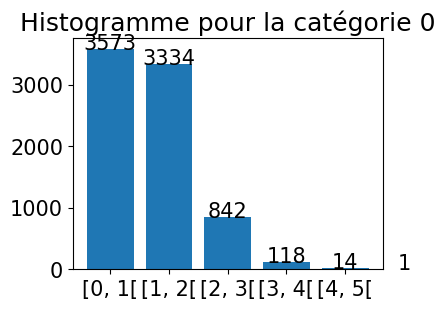

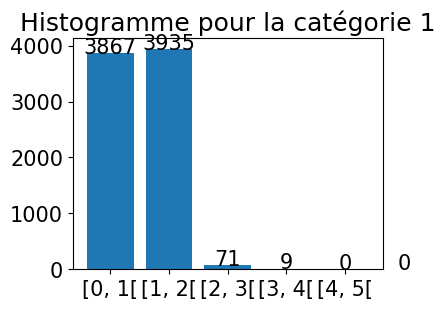

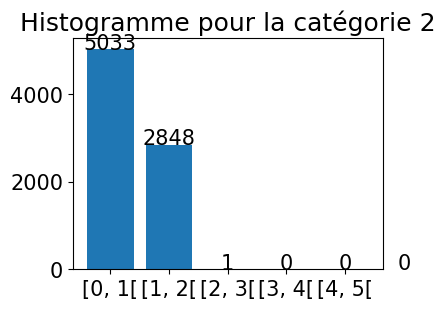

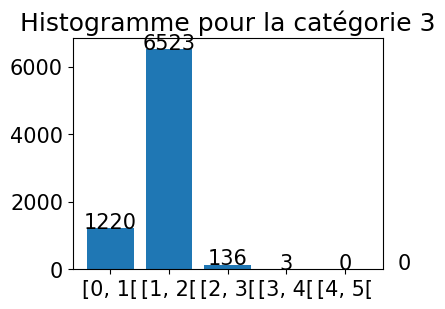

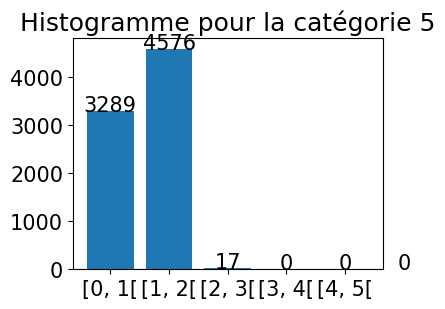

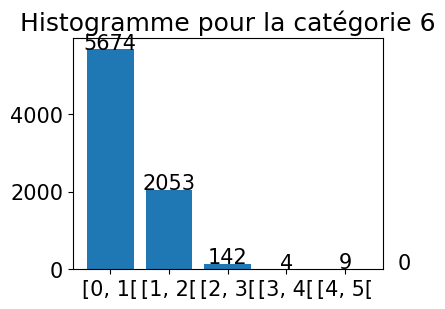

In [101]:
#Nombre d'aliments consommés par cluster, par repas 
 
import numpy as np
import matplotlib.pyplot as plt

c = 8
liste_dej_cluster

print("nombre de petits déjeuners considérés:", len(liste_dej_cluster))

for i in range(c):
    plt.figure(figsize=(4, 3))
    n = 0
    m = []
    for liste in liste_dej_cluster:
        n += 1
        if i in liste:
            m.append(liste.count(i))
        else:
            m.append(0)
    cat = str(i)
    
    bin_edges = [0, 1, 2, 3, 4, 5]
    plt.hist(m, bins=bin_edges, align='left', rwidth=0.8)
    plt.title("Histogramme pour la catégorie " + cat)
    for j in bin_edges:
        plt.text(bin_edges[j], m.count(j), str(m.count(j)), ha='center')
   
    plt.xticks(bin_edges[:-1], [f"[{x}, {x+1}[" for x in bin_edges[:-1]])
    plt.show()
    
#     print(i, m, "\n")
#     print(i, np.mean(m))
            


In [104]:
!pip install mlxtend
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Créer un objet MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transformer les catégories en une matrice binaire
categories_binary = mlb.fit_transform(liste_dej_cluster)

# Créer un dataframe à partir de la matrice binaire
df = pd.DataFrame(categories_binary, columns=mlb.classes_)

# Afficher le dataframe
print(df.head())

   0  1  2  3  4  5  6  7
0  1  0  0  1  1  1  0  0
1  1  0  0  1  1  1  0  0
2  1  1  1  1  0  1  0  0
3  1  0  0  1  1  1  0  0
4  1  0  0  1  1  1  0  0


In [105]:
# Générer les itemsets fréquents
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# Générer les règles d'association à partir des itemsets fréquents
rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules_df = rules_df.sort_values(by="confidence", ascending=False)

# Afficher les règles d'association
print(rules_df)
# rules_df.to_excel("rules2.xlsx", index=False)


     antecedents consequents  antecedent support  consequent support  \
0            (7)         (0)            0.095534            0.546689   
9         (1, 7)         (0)            0.050875            0.546689   
10        (5, 7)         (0)            0.056331            0.546689   
43  (0, 2, 3, 5)         (1)            0.101497            0.509388   
26     (0, 2, 6)         (1)            0.102385            0.509388   
24     (0, 2, 3)         (1)            0.175717            0.509388   
45  (0, 2, 3, 6)         (1)            0.080817            0.509388   
46  (0, 2, 5, 6)         (1)            0.052905            0.509388   
15        (2, 6)         (1)            0.164679            0.509388   
33     (2, 3, 5)         (1)            0.177493            0.509388   
36     (2, 3, 6)         (1)            0.142730            0.509388   
38     (2, 5, 6)         (1)            0.084623            0.509388   
12        (2, 3)         (1)            0.311342            0.50

C:\Users\jacqueno\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [106]:
# Générer les itemsets fréquents
frequent_itemsets2 = apriori(df, min_support=0.1, use_colnames=True)

# Générer les règles d'association à partir des itemsets fréquents
df2_rules = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

# Afficher les règles d'association avec leur lift
print(df2_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


C:\Users\jacqueno\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


    antecedents consequents   support  confidence      lift
0           (0)         (1)  0.321365    0.587839  1.154010
1           (1)         (0)  0.321365    0.630884  1.154010
2           (0)         (2)  0.224182    0.410072  1.134499
3           (2)         (0)  0.224182    0.620218  1.134499
4           (0)         (4)  0.122050    0.223254  1.033893
5           (4)         (0)  0.122050    0.565217  1.033893
6           (0)         (6)  0.179523    0.328382  1.172242
7           (6)         (0)  0.179523    0.640851  1.172242
8           (1)         (2)  0.348389    0.683935  1.892165
9           (2)         (1)  0.348389    0.963847  1.892165
10          (1)         (3)  0.430601    0.845330  1.000134
11          (3)         (1)  0.430601    0.509457  1.000134
12          (1)         (6)  0.251205    0.493151  1.760423
13          (6)         (1)  0.251205    0.896739  1.760423
14          (2)         (3)  0.311342    0.861355  1.019093
15          (3)         (2)  0.311342   

In [107]:
# Générer les itemsets fréquents
frequent_itemsets3 = apriori(df,  min_support=0.0000000001, use_colnames=True)

# Générer les règles d'association à partir des itemsets fréquents
df3_rules = association_rules(frequent_itemsets3, metric="lift",  min_threshold=0.00001)
df3_rules = df3_rules.sort_values(by="lift", ascending=True)
df3_rules = df3_rules[df3_rules.lift<0.7]

print(df3_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
# df3_rules.to_excel("rules_exclusion.xlsx", index=False)

C:\Users\jacqueno\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


             antecedents         consequents   support  confidence      lift
141               (0, 7)                 (3)  0.000381    0.003984  0.004714
43                   (7)                 (3)  0.000381    0.003984  0.004714
42                   (3)                 (7)  0.000381    0.000450  0.004714
144                  (3)              (0, 7)  0.000381    0.000450  0.004714
726            (0, 4, 7)                 (3)  0.000127    0.006061  0.007170
335                  (3)              (4, 7)  0.000127    0.000150  0.007170
334               (4, 7)                 (3)  0.000127    0.006061  0.007170
735                  (3)           (0, 4, 7)  0.000127    0.000150  0.007170
344               (3, 5)                 (7)  0.000381    0.000731  0.007650
759               (3, 5)              (0, 7)  0.000381    0.000731  0.007650
758               (0, 7)              (3, 5)  0.000381    0.003984  0.007650
349                  (7)              (3, 5)  0.000381    0.003984  0.007650

In [108]:
df.head()
df[df[3]==1][df[5]==0]

C:\Users\jacqueno\AppData\Local\Temp\ipykernel_9760\4048897093.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df[3]==1][df[5]==0]


0  1  2  3  4  5  6  7
15    1  0  0  1  0  0  0  0
16    1  1  1  1  0  0  1  0
17    1  0  0  1  0  0  0  0
18    1  0  0  1  0  0  0  0
19    1  0  0  1  0  0  0  0
20    1  0  0  1  0  0  0  0
30    1  1  0  1  0  0  1  0
34    0  0  0  1  1  0  1  0
35    1  0  0  1  1  0  1  0
36    1  0  0  1  1  0  1  0
37    1  1  0  1  0  0  1  0
38    1  0  0  1  0  0  1  0
43    0  0  0  1  1  0  0  0
44    0  1  1  1  0  0  0  0
45    1  1  1  1  0  0  0  0
71    0  1  1  1  0  0  1  0
72    0  1  1  1  0  0  1  0
73    0  1  1  1  0  0  1  0
74    0  1  1  1  0  0  1  0
78    0  0  0  1  0  0  0  0
79    0  0  0  1  0  0  0  0
80    0  0  0  1  0  0  0  0
81    0  0  0  1  0  0  0  0
82    0  0  0  1  0  0  0  0
83    0  0  0  1  0  0  0  0
84    0  0  0  1  0  0  0  0
105   0  1  1  1  0  0  0  0
106   0  1  1  1  0  0  0  0
120   1  0  0  1  0  0  0  0
136   0  1  1  1  0  0  1  0
137   0  1  1  1  0  0  1  0
138   0  1  1  1  0  0  1  0
139   0  1  1  1  0  0  1  0
140   0  1  1  1  0  0  0  0
141   0  1  1  1  0  0  1  0
148   0  0  0  1  1  0  0  0
164   0  0  0  1  0  0  0  0
165   1  0  0  1  1  0  1  0
166   1  0  0  1  1  0  0  0
168   1  0  0  1  1  0  0  0
169   1  0  0  1  1  0  0  0
170   1  1  0  1  0  0  1  0
171   1  1  0  1  0  0  1  0
172   1  1  0  1  0  0  1  0
173   1  1  0  1  0  0  1  0
174   1  1  0  1  0  0  1  0
175   1  1  0  1  0  0  1  0
176   1  1  0  1  0  0  1  0
177   1  1  0  1  0  0  1  0
185   1  0  0  1  0  0  0  0
186   1  1  1  1  0  0  0  0
187   1  1  1  1  0  0  0  0
188   1  0  0  1  0  0  0  0
189   1  1  0  1  1  0  0  0
190   1  1  1  1  0  0  0  0
213   0  1  1  1  0  0  1  0
214   0  1  1  1  0  0  1  0
215   1  1  1  1  0  0  1  0
216   0  1  1  1  0  0  1  0
217   0  1  1  1  0  0  1  0
248   0  0  0  1  1  0  0  0
251   0  1  1  1  0  0  0  0
252   1  0  0  1  0  0  0  0
253   1  0  0  1  1  0  0  0
254   0  1  0  1  0  0  1  0
255   1  1  0  1  0  0  0  0
257   0  1  0  1  0  0  1  0
258   0  1  0  1  0  0  1  0
259   0  1  0  1  0  0  1  0
260   0  1  0  1  0  0  1  0
261   0  1  0  1  0  0  1  0
262   0  1  1  1  0  0  0  0
265   1  1  1  1  0  0  0  0
266   1  1  1  1  0  0  0  0
267   1  1  1  1  0  0  0  0
268   1  1  1  1  0  0  0  0
269   0  0  0  1  1  0  0  0
270   1  0  0  1  1  0  0  0
278   1  1  1  1  0  0  1  0
279   1  1  1  1  0  0  1  0
280   1  1  1  1  0  0  1  0
281   1  1  1  1  0  0  1  0
282   1  1  1  1  0  0  1  0
298   0  0  0  1  0  0  0  0
299   0  0  0  1  0  0  0  0
300   0  0  0  1  0  0  0  0
301   0  0  0  1  0  0  0  0
334   1  1  0  1  0  0  1  0
335   1  1  0  1  0  0  1  0
336   1  1  0  1  0  0  1  0
337   1  1  0  1  0  0  1  0
338   1  1  0  1  0  0  1  0
339   1  1  0  1  0  0  1  0
340   1  1  0  1  0  0  1  0
346   0  1  1  1  0  0  0  0
347   0  1  1  1  0  0  0  0
348   0  1  1  1  0  0  0  0
349   0  1  1  1  0  0  0  0
350   0  1  1  1  0  0  0  0
351   0  1  1  1  1  0  0  0
352   0  1  1  1  0  0  0  0
367   0  1  1  1  0  0  1  0
368   0  1  1  1  0  0  1  0
369   0  1  1  1  0  0  1  0
370   0  1  1  1  0  0  1  0
371   1  1  1  1  0  0  0  0
372   1  0  0  1  1  0  0  0
373   1  1  1  1  0  0  0  0
374   1  1  1  1  0  0  0  0
375   1  0  0  1  0  0  0  0
376   1  0  0  1  0  0  0  0
377   1  0  0  1  0  0  0  0
378   1  0  0  1  0  0  0  0
379   1  0  0  1  0  0  0  0
380   1  0  0  1  0  0  0  0
381   0  0  0  1  1  0  1  0
382   1  1  1  1  0  0  0  0
383   1  1  1  1  0  0  0  0
384   1  1  1  1  0  0  0  0
402   0  0  0  1  0  0  0  0
403   0  0  0  1  0  0  0  0
404   0  0  0  1  0  0  0  0
405   0  0  0  1  0  0  0  0
406   0  0  0  1  0  0  0  0
407   0  0  0  1  0  0  0  0
408   0  0  0  1  0  0  0  0
409   0  1  1  1  0  0  1  0
410   0  1  1  1  0  0  1  0
411   0  1  1  1  0  0  1  0
412   0  1  1  1  0  0  1  0
413   0  1  1  1  0  0  1  0
414   0  1  1  1  0  0  1  0
417   1  0  0  1  1  0  0  0
418   1  0  0  1  1  0  0  0
419   1  0  0  1  1  0  0  0
420   1  0  0  1  1  0  0  0
421   1  0  0  1  1  0  0  0
422 

In [109]:
column_names = list(df.columns)
print(column_names)  # Affiche les noms de colonnes
dic_alim

[0, 1, 2, 3, 4, 5, 6, 7]


{7001: 'pain baguette',
 7004: 'pain grillé maison',
 7012: 'pain courant français boule à la levure',
 7100: 'pain de campagne ou bis',
 7110: 'pain complet ou intégral artisanal',
 7125: 'pain de seigle et froment',
 7126: 'pain de seigle aux raisins',
 7160: 'pain baguette sans sel',
 7200: 'pain de mie',
 7225: 'pain brioché ou viennois',
 7255: 'pain aux céréales artisanal',
 90003: 'pain type poilâne',
 91123: 'pain sans précision',
 92031: 'autre pain',
 7300: 'biscotte classique type heudebert lu',
 7310: 'biscotte sans adjonction de sel',
 7330: 'biscotte multicéréales type heudebert aux six céréales',
 7340: 'biscotte complète ou riche en fibres',
 7400: 'pain grillé au froment type tranches pain grillé pelletier lu braisotte jacquet',
 7411: 'tartine extrudée fourrée au chocolat ou aux fruits type craquinette de lu',
 7425: 'pain grillé multicéréales type pain grillé multicéréales heudebert lu',
 92030: 'autre biscotte',
 7430: 'croûtons',
 7500: 'chapelure ou panure',
 7812

In [110]:
d_6j.items()
d_new_indiv_nonnuls
dico_cluster_codes
value_to_find = ["yaourt ou spécialité laitière nature", "eau du robinet", "eau de source", 'lait demi-écrémé uht', 
                 'lait écrémé uht', 'poudre soluble à base de chicorée et de café type ricoré', 'café soluble en poudre',
                 'pâte à tartiner au chocolat et aux noisettes type nutella','clémentine ou mandarine fraîche']
code_yaourt = [key for key, value in dic_alim.items() if value == value_to_find[0]]
code_eau_robinet= [key for key, value in dic_alim.items() if value == value_to_find[1]]
code_eau_source= [key for key, value in dic_alim.items() if value == value_to_find[2]]
code_laitdemi_ec= [key for key, value in dic_alim.items() if value == value_to_find[3]]
code_lait_ec=[key for key, value in dic_alim.items() if value == value_to_find[4]]
code_chicoreesolub=[key for key, value in dic_alim.items() if value == value_to_find[5]]
code_cafesolub=[key for key, value in dic_alim.items() if value == value_to_find[6]]
pate_tartiner=[key for key, value in dic_alim.items() if value == value_to_find[7]]
clementine=[key for key, value in dic_alim.items() if value == value_to_find[8]]
print("code_yaourt", code_yaourt)
print("code_eau_robinet", code_eau_robinet)
print("code_eau_source", code_eau_source)
print("code_laitdemi_ec", code_laitdemi_ec)
print("code_lait_ec", code_lait_ec)
print("code_chicoreesolub",code_chicoreesolub)
print("code_cafesolub", code_cafesolub)
print("pate à tartiner", pate_tartiner)
print("clementine", clementine)

code_yaourt [19600]
code_eau_robinet [18066]
code_eau_source [18008]
code_laitdemi_ec [19041]
code_lait_ec [19050]
code_chicoreesolub [18150]
code_cafesolub [18005]
pate à tartiner [31032]
clementine [13024]


In [113]:
eau_robinet_sscafesolub=0
eau_robinet=0
cafesolub_sseaurobinet=0
cafesolub_eaurobinet=0

for key, value in d_new_indiv_nonnuls.items():
    for subkey, subvalue in value.items():
        codes_clust_sub=[]
        for e in subvalue:
            codes_clust_sub.append(dico_alim_cluster[e])
        if ((18066 in subvalue) and (7 not in codes_clust_sub)):
            eau_robinet_sscafesolub+=1
#             for i in subvalue:
#                 print(dic_alim[i])
#             print("/n")            
        if (18066 in subvalue):
             eau_robinet+=1
        if ((18066 not in subvalue) and (7 in codes_clust_sub)):
            cafesolub_sseaurobinet+=1
#             for i in subvalue:
#                 print(dic_alim[i])
#             print("/n")        
        if ((18066 in subvalue) and (7 in codes_clust_sub)):
            cafesolub_eaurobinet+=1
#             for i in subvalue:
#                 print(dic_alim[i])
#             print("/n")                    

print("eau_robinet_sans cafe ou chicoree soluble", eau_robinet_sscafesolub)   
print("eau_robinet", eau_robinet) 
print("cafe ou chicoree solub_sseaurobinet", cafesolub_sseaurobinet)
print("cafe ou chicoree solub_eaurobinet", cafesolub_eaurobinet)


# il est donc fréquent de consommer de l'eau du robinet sans poudre soluble. 

eau_robinet_sans cafe ou chicoree soluble 488
eau_robinet 953
cafe ou chicoree solub_sseaurobinet 288
cafe ou chicoree solub_eaurobinet 465


In [114]:
categorie7=0
cafesol_eau=0
cafe_lait=0
cafe_eau_lait=0
cafe_eaudesource_only=0
chicoreesol_eau=0
chicoreesol_lait=0
chicoreesol_eau_lait=0
chicoree_eaudesource_only=0

for key, value in d_new_indiv_nonnuls.items():
    for subkey, subvalue in value.items():
        codes_clust_sub=[]
        for e in subvalue:
            codes_clust_sub.append(dico_alim_cluster[e])
        if (7 in codes_clust_sub):
            categorie7+=1
            if ((18005 in subvalue) and ((18066 in subvalue) or (18008 in subvalue)) and (19041 not in subvalue) 
                and (19050 not in subvalue)):
                cafesol_eau+=1
            if ((18005 in subvalue) and (18008 not in subvalue) and (18066 not in subvalue)  and ((19041 in subvalue) 
                                                                                                  or (19050 in subvalue))):
                cafe_lait+=1
                
            if  ((18005 in subvalue) and ((18008 in subvalue) or (18066 in subvalue))  and ((19041 in subvalue) 
                                                                                                  or (19050 in subvalue))):  
                cafe_eau_lait+=1 
            if  ((18005 in subvalue) and (18008 in subvalue) and (18066 not in subvalue) and (19041 not in subvalue) 
                and (19050 not in subvalue)):
                cafe_eaudesource_only+=1
                
            if ((18150 in subvalue) and ((18066 in subvalue) or (18008 in subvalue)) and (19041 not in subvalue) 
                and (19050 not in subvalue)):
                chicoreesol_eau+=1
            if ((18150 in subvalue) and (18008 not in subvalue) and (18066 not in subvalue)  and ((19041 in subvalue) 
                                                                                                  or (19050 in subvalue))):
                chicoreesol_lait+=1
            if  ((18150 in subvalue) and ((18008 in subvalue) or (18066 in subvalue))  and ((19041 in subvalue) 
                                                                                                  or (19050 in subvalue))):   
                chicoreesol_eau_lait+=1
            if  ((18150 in subvalue) and (18008 in subvalue) and (18066 not in subvalue) and (19041 not in subvalue) 
                and (19050 not in subvalue)):
                chicoree_eaudesource_only+=1
                
print("categorie7",categorie7)
print("cafesol_eau", cafesol_eau)
print("cafe_lait", cafe_lait)
print("cafe_eau_lait", cafe_eau_lait)
print("cafe_eaudesource_only", cafe_eaudesource_only)
print("chicoreesol_eau", chicoreesol_eau)
print("chicoreesol_lait", chicoreesol_lait)
print("chicoreesol_eau_lait", chicoreesol_eau_lait)
print("chicoree_eaudesource_only", chicoree_eaudesource_only)

#dans l'association des catégories 7 et 0 (7 implique 0), il y a différentes catégories possibles : 
# café soluble avec eau, lait ou les 2, chicorée soluble avec eau lait ou les 2

categorie7 753
cafesol_eau 99
cafe_lait 63
cafe_eau_lait 50
cafe_eaudesource_only 1
chicoreesol_eau 204
chicoreesol_lait 179
chicoreesol_eau_lait 158
chicoree_eaudesource_only 2


# Tester les interactions avec les graphes de connaissances

In [ ]:
#ATTENTION ALLER SUR LE GIGHUB DE AYOUB HAMMAL POUR TELEHCARGER LE DOSSIER knowledge-mining-nutrition

In [101]:
!pip install rdflib
!pip install pyshacl
import sys
sys.path.append(r'C:\Users\jacqueno\Documents\IODAA\EXERSYS\Axe_2\knowledge-mining-nutrition\lib')
import semanticValidator

import time
from pprint import pprint

from semanticValidator import Validator
from semanticValidator.metadata import *

# to be replaced by the path to the knowledge base file
start_time = time.time()
print("loading the knowledge base... ", end="")
validator = Validator()
print(f"done! {time.time() - start_time} s")

id_consumer = 110006
print("adding the consumer... ", end="")
validator.attach_consumer(id_consumer)
print(f"done! {time.time() - start_time} s")

recommendation = {
    "recommendation": [[[18150, 7001], [], []]],  # jours  # repas
    "id_consumer": id_consumer,
    "profiles": [
        "profile-allergique-soja",
        "profile-allergique-lait",
        "profile-ovo-lacto-vegetarien",
    ],
}

start_time = time.time()
print("inserting the recommendation... ", end="")
recommendation_id = validator.insert_recommendation(recommendation)
print(f"done! {time.time() - start_time} s")

start_time = time.time()
print("validating the recommendation... ", end="")
result = validator.validate_graph(
    recommendation_id=recommendation_id,
    validators=[
        {"name": "allergies", "fn": validator.validate_allergies},
        {"name": "vegetarien", "fn": validator.validate_diet},
        {"name": "association", "fn": validator.validate_association_rules},
        {"name": "exclusion", "fn": validator.validate_exclusion_rules},
        {"name": "cardinality", "fn": validator.validate_cardinality_rules},
    ],
)
print(f"done! {time.time() - start_time} s")

pprint(result)


start_time = time.time()
print("dropping the recommendation... ", end="")
validator.drop_recommendation(recommendation_id)
print(f"done! {time.time() - start_time} s")

start_time = time.time()
print("reseting the knowledge graph... ", end="")
validator.reset_knowledge_graph()
print(f"done! {time.time() - start_time} s")


loading the knowledge base... done! 7.964752197265625 s
adding the consumer... done! 10.351346015930176 s
inserting the recommendation... done! 0.0 s
validating the recommendation... done! 0.5875115394592285 s
([{'name': 'allergies', 'report': {'conforms': True, 'messages': []}},
  {'name': 'vegetarien', 'report': {'conforms': True, 'messages': []}},
  {'name': 'association', 'report': {'conforms': False, 'filter': [False]}},
  {'name': 'exclusion', 'report': {'conforms': True, 'filter': []}},
  {'name': 'cardinality', 'report': {'conforms': True, 'filter': []}}],
 False)
dropping the recommendation... done! 0.0 s
reseting the knowledge graph... done! 0.0 s


In [90]:
#Exemple de recommandation pour un individu, basé sur les jours de recueil moins 1:

c=8
model=w2v_cbow_pdj_freq_load         
alpha=10 #Conservateur 

ind=110025 
reco_petitdej=[]

for i in range(c):
    if d_indiv_cluster_names_6j[ind][i]!=[]:
        p=[]
        p_normalized=[]
        for e in dico_cluster_codes[i]:
            similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                * norm(model.wv[e]))
            proba[e] = np.exp(alpha*similarities[e])
            p.append(proba[e])            
        p=np.array(p)
        p_normalized = p / np.sum(p)
#         print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized)
        tirage = np.random.multinomial(1, p_normalized)
        for a in range(len(dico_cluster_codes[i])):
            if tirage[a]==1:
                reco_petitdej.append(dico_cluster_codes[i][a]) 
                print("\t => pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n")                  
                    
    elif d_indiv_cluster_names_6j[ind][i]==[]:
        if np.random.choice([True, False], p=[0.05, 0.95]):
            print("on recommande aussi une catégorie non consommée dans le passé \n")
            # Dans 5% des cas, on tire une multInomiale
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:
                similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])
            p=np.array(p)
            p_normalized = p / np.sum(p)
#             print(i, dico_cluster_noms[i], "\n, proba normalisée:", p_normalized)
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(dico_cluster_codes[i])):
                if tirage[a]==1:
                    reco_petitdej.append(dico_cluster_codes[i][a])                    
                    print("\=> pour la catégorie", i, "l'aliment recommandé est", dic_alim[dico_cluster_codes[i][a]], "\n") 

print("=>la liste des codes des aliments recommandés est", reco_petitdej, "\n")



	 => pour la catégorie 0 l'aliment recommandé est eau du robinet 

	 => pour la catégorie 3 l'aliment recommandé est café noir prêt à boire non sucré 

	 => pour la catégorie 4 l'aliment recommandé est croissant sans précision 

	 => pour la catégorie 5 l'aliment recommandé est sucre blanc ajouté au service 

=>la liste des codes des aliments recommandés est [18066, 18004, 7601, 81052] 



In [91]:
#fonction émettre une recommandation pour un individu à partir de son identifiant et de la valeur d'alpha souhaitée

def emettre_reco(ind, alpha_value):  
    alpha=alpha_value     
    c=8
    model=w2v_cbow_pdj_freq_load         
    reco_petitdej=[]
    for i in range(c):       
        if d_indiv_cluster_names_6j[ind][i]!=[]:
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:
                similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                    * norm(model.wv[e]))
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])            
            p=np.array(p)
            p_normalized = p / np.sum(p)
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(dico_cluster_codes[i])):
                if tirage[a]==1:
                    reco_petitdej.append(dico_cluster_codes[i][a])                  
        elif d_indiv_cluster_names_6j[ind][i]==[]:
            if np.random.choice([True, False], p=[0.05, 0.95]):
                # Dans 5% des cas, on tire une multInomiale
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:
                    similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e])
                p=np.array(p)
                p_normalized = p / np.sum(p)
                tirage = np.random.multinomial(1, p_normalized)
                for a in range(len(dico_cluster_codes[i])):
                    if tirage[a]==1:
                        reco_petitdej.append(dico_cluster_codes[i][a])                    
    return(reco_petitdej)

In [92]:
# fonction tirer un aliment au sein d'une catégorie pour un individu à partir de son identifiant et de la valeur d'alpha 
# souhaitée (que la catégorie ait été consommée dans le passé ou non, on tire un aliment)

def tirer_alim_categorie(ind, categorie, alpha_value):  
    alpha=alpha_value     
    c=8
    model=w2v_cbow_pdj_freq_load         
    aliment_tire=[]
    i=categorie      
    if d_indiv_cluster_names_6j[ind][i]!=[]:
            p=[]
            p_normalized=[]
            for e in dico_cluster_codes[i]:
                similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                    * norm(model.wv[e]))
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])            
            p=np.array(p)
            p_normalized = p / np.sum(p)
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(dico_cluster_codes[i])):
                if tirage[a]==1:
                    aliment_tire.append(dico_cluster_codes[i][a])                  
    elif d_indiv_cluster_names_6j[ind][i]==[]:
                p=[]
                p_normalized=[]
                for e in dico_cluster_codes[i]:
                    similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e])
                p=np.array(p)
                p_normalized = p / np.sum(p)
                tirage = np.random.multinomial(1, p_normalized)
                for a in range(len(dico_cluster_codes[i])):
                    if tirage[a]==1:
                        aliment_tire.append(dico_cluster_codes[i][a])
#     print("aliment tiré", aliment_tire)
    return(aliment_tire)

In [93]:
# fonction tirer un aliment au sein d'une catégorie pour un individu à partir de son identifiant et de la valeur d'alpha 
# souhaitée (que la catégorie ait été consommée dans le passé ou non, on tire un aliment)
# on interdit l'aliment qui a causé probleme précédemment !!!
import copy

def tirer_alimdiff_categorie(ind, aliminterdit, categorie, alpha_value):  
    alpha=alpha_value     
    c=8
    model=w2v_cbow_pdj_freq_load         
    aliment_tire=[]
    i=categorie
    newliste=copy.deepcopy(dico_cluster_codes)
    if d_indiv_cluster_names_6j[ind][i]!=[]:
            p=[]
            p_normalized=[]
            newliste[i].remove(aliminterdit)
#             print(newliste[i])
            for e in newliste[i]:
                similarities[e] = dot(mean_indiv_clust_6j[(ind,i)], model.wv[e]) / (norm(mean_indiv_clust_6j[(ind,i)]) 
                                                                                    * norm(model.wv[e]))
                proba[e] = np.exp(alpha*similarities[e])
                p.append(proba[e])            
            p=np.array(p)
            p_normalized = p / np.sum(p)
            tirage = np.random.multinomial(1, p_normalized)
            for a in range(len(newliste[i])):
                if tirage[a]==1:
                    aliment_tire.append(newliste[i][a])  
    elif d_indiv_cluster_names_6j[ind][i]==[]:
                p=[]
                p_normalized=[]
                newliste[i].remove(aliminterdit)
                for e in newliste[i]:
                    similarities[e] = dot(moy_clusters[i], model.wv[e]) / (norm(moy_clusters[i]) * norm(model.wv[e]))        
                    proba[e] = np.exp(alpha*similarities[e])
                    p.append(proba[e])
                p=np.array(p)
                p_normalized = p / np.sum(p)
                tirage = np.random.multinomial(1, p_normalized)
                for a in range(len(newliste[i])):
                    if tirage[a]==1:
                        aliment_tire.append(newliste[i][a])
#     print("aliment tiré", aliment_tire)
    return(aliment_tire)

In [94]:
#tester la fonction émettre une recommandation pour un individu à partir de son identifiant et de la valeur 
# d'alpha souhaitée: exemple
emettre_reco(110025, 10)

[18066, 18020, 7601, 31016]

In [95]:
#tester la fonction  tirer un aliment au sein d'une catégorie pour un individu à partir de son identifiant et de la valeur 
# d'alpha souhaitée: exemple SANS EXCLURE L ALIMENT INTERDIT
tirer_alim_categorie(110025, 3, 10)

[18004]

In [96]:
dico_cluster_codes[3]

[18151, 18004, 18020, 18073, 18101, 18071]

In [97]:
#tester la fonction  tirer un aliment au sein d'une catégorie pour un individu à partir de son identifiant et de la valeur 
# d'alpha souhaitée: EN EXCLUANT UN ALIMENT INTERDIT
tirer_alimdiff_categorie(110025, 18004, 3, 10)

[18020]

In [98]:
# fonction émettre une recommandation et sa validation pour un individu à partir de son identifiant 
# et de la valeur d'alpha souhaitée: exemple d'un individu


def emettre_result(ind, alpha_value):

        reco_petitdej=emettre_reco(ind, alpha_value)
        print("la liste des codes d'aliments recommandés pour le petit déjeuner pour l'indiv", ind, "est:", reco_petitdej)

#         print("loading the knowledge base... ", end="")
#         validator = Validator()
#         print(f"done!")
        id_consumer = ind
        print("adding the consumer... ", end="")
        validator.attach_consumer(id_consumer)
        print(f"done!")
        recommendation = {
            "recommendation": [[reco_petitdej]],  # jours  # repas
            "id_consumer": id_consumer,
            "profiles": [
                "profile-allergique-soja",
                "profile-allergique-lait",
                "profile-ovo-lacto-vegetarien",
            ],
        }
        print("inserting the recommendation... ", end="")
        recommendation_id = validator.insert_recommendation(recommendation)
        print(f"done!")

        print("validating the recommendation... ", end="")
        result = validator.validate_graph(
            recommendation_id=recommendation_id,
            validators=[
                {"name": "allergies", "fn": validator.validate_allergies},
                {"name": "vegetarien", "fn": validator.validate_diet},
                {"name": "association", "fn": validator.validate_association_rules},
                {"name": "exclusion", "fn": validator.validate_exclusion_rules},
                {"name": "cardinality", "fn": validator.validate_cardinality_rules},
            ],
         )
        print(f"done!")

        pprint(result)
        
        print("dropping the recommendation... ", end="")
        validator.drop_recommendation(recommendation_id)
        print(f"done!")
        
        print("reseting the knowledge graph... ", end="")
        validator.reset_knowledge_graph()
        print(f"done!")



In [99]:
# fonction émettre une recommandation et sa validation pour un individu à partir de son identifiant 
# et de la valeur d'alpha souhaitée: exemple d'un individu


def emettre_result_valide(ind, alpha_value):
    n=0
    echec=0
    valid_gate=0
    reco_petitdej=emettre_reco(ind, alpha_value)
    reco_liste= [dic_alim[i] for i in reco_petitdej]
#     print("la liste des codes d'aliments recommandés pour le petit déj pour l'indiv", ind, "est:", reco_petitdej, reco_liste)
#     print("loading the knowledge base... ", end="")
#     validator = Validator()
#     print(f"done!")
    id_consumer = ind
#     print("adding the consumer... ", end="")
    validator.attach_consumer(id_consumer)
#     print(f"done!")
    recommendation = {
        "recommendation": [[reco_petitdej]],  # jours  # repas
        "id_consumer": id_consumer,
        "profiles": [
            "profile-allergique-soja",
#             "profile-allergique-lait",            
            "profile-allergique-oeufs",
            "profile-ovo-lacto-vegetarien",
        ],
    }
#     print("inserting the recommendation... ", end="")
    recommendation_id = validator.insert_recommendation(recommendation)
#     print(f"done!")

#     print("validating the recommendation... ", end="")
    result = validator.validate_graph(
        recommendation_id=recommendation_id,
        validators=[
            {"name": "allergies", "fn": validator.validate_allergies},
            {"name": "vegetarien", "fn": validator.validate_diet},
            {"name": "association", "fn": validator.validate_association_rules},
            {"name": "exclusion", "fn": validator.validate_exclusion_rules},
            {"name": "cardinality", "fn": validator.validate_cardinality_rules},
        ],
    )
#     print(f"done!")

#     pprint(result)

#     print("dropping the recommendation... ", end="")
    validator.drop_recommendation(recommendation_id)
#     print(f"done!")

    n+=1
    result_current=result[0]
    
    if all(result_current[i]["report"]["conforms"] for i in range(5)):
        valid_gate=1
#         print("reseting the knowledge graph... ", end="")
        validator.reset_knowledge_graph()
#         print(f"done!")
        print("recommandation validée à la première étape")
        return([valid_gate, echec])
    
    else:
        while n < 21 and not all(result_current[i]["report"]["conforms"] for i in range(5)):
                while n < 21 and ((result_current[0]["report"]["conforms"]==False) or 
                                  (result_current[1]["report"]["conforms"]==False)):
                    reco_issue=[]
                    nouveaux_alim=[]
                    if "filter" in result_current[0]["report"]:
                        for index, value in enumerate(result_current[0]["report"]["filter"][0][0]):
#                             print(value)
                            if not value:
                                reco_issue.append(reco_petitdej[index])
                    if "filter" in result_current[1]["report"]:
                        for index, value in enumerate(result_current[1]["report"]["filter"][0][0]):
#                             print(value)
                            if not value:
                                reco_issue.append(reco_petitdej[index])
                    reco_issue=list(set(reco_issue))
    #                 print("reco_issue", reco_issue)
                    cat_issue=[dico_alim_cluster[key] for key in reco_issue]
    #                 print("cat_issue", cat_issue)
                    for cat in cat_issue:
                        nouveaux_alim.append(tirer_alim_categorie(ind, cat, 0)[0])
    #                 print("nouveaux aliments tirés:", nouveaux_alim)
    #                 print("nouvelle tentative N°", n)
                    reco_petitdej = [item for item in reco_petitdej if item not in reco_issue] + nouveaux_alim
                    reco_liste= [dic_alim[i] for i in reco_petitdej]
#                     print("la liste des codes d'aliments recommandés pour le PDJ pour l'indiv", ind, "est:", reco_petitdej, 
#                           reco_liste)

                    recommendation = {
                        "recommendation": [[reco_petitdej]],  # jours  # repas
                        "id_consumer": id_consumer,
                        "profiles": [
                            "profile-allergique-soja",
                            "profile-allergique-oeufs",
#                             "profile-allergique-lait",
                            "profile-ovo-lacto-vegetarien",
                        ],
                    }
#                     print("inserting the recommendation... ", end="")
                    recommendation_id = validator.insert_recommendation(recommendation)
#                     print(f"done!")

#                     print("validating the recommendation... ", end="")
                    result = validator.validate_graph(
                        recommendation_id=recommendation_id,
                        validators=[
                            {"name": "allergies", "fn": validator.validate_allergies},
                            {"name": "vegetarien", "fn": validator.validate_diet},
                            {"name": "association", "fn": validator.validate_association_rules},
                            {"name": "exclusion", "fn": validator.validate_exclusion_rules},
                            {"name": "cardinality", "fn": validator.validate_cardinality_rules},
                        ],
                    )
#                     print(f"done!")

#                     pprint(result)
                    result_current=result[0]
    
#                     print("dropping the recommendation... ", end="")
                    validator.drop_recommendation(recommendation_id)
#                     print(f"done!")

                    n+=1 
                    if not all(result_current[i]["report"]["conforms"] for i in range(5)):
                        break
                    elif all(result_current[i]["report"]["conforms"] for i in range(5)):
                        valid_gate=n
                        print("recommandation validée à l'étape", n)
#                         print("reseting the knowledge graph... ", end="")
                        validator.reset_knowledge_graph()
#                         print(f"done!")                        
                        return([valid_gate, echec])

                while n < 21 and ((result_current[2]["report"]["conforms"]==False) 
                or (result_current[3]["report"]["conforms"]==False) or (result_current[4]["report"]["conforms"]==False)):
#                     print("nouvelle tentative N°", n)
                    reco_petitdej=emettre_reco(ind, 0)
                    reco_liste=[dic_alim[i] for i in reco_petitdej]
#                     print("la liste des codes d'aliments recommandés pour le petit déjeuner pour l'indiv", ind, "est:", 
#                           reco_petitdej, reco_liste)

                    recommendation = {
                        "recommendation": [[reco_petitdej]],  # jours  # repas
                        "id_consumer": id_consumer,
                        "profiles": [
                            "profile-allergique-soja",
                            "profile-allergique-oeufs",
#                             "profile-allergique-lait",  
                            "profile-ovo-lacto-vegetarien",
                        ],
                    }
#                     print("inserting the recommendation... ", end="")
                    recommendation_id = validator.insert_recommendation(recommendation)
#                     print(f"done!")

#                     print("validating the recommendation... ", end="")
                    result = validator.validate_graph(
                        recommendation_id=recommendation_id,
                        validators=[
                            {"name": "allergies", "fn": validator.validate_allergies},
                            {"name": "vegetarien", "fn": validator.validate_diet},
                            {"name": "association", "fn": validator.validate_association_rules},
                            {"name": "exclusion", "fn": validator.validate_exclusion_rules},
                            {"name": "cardinality", "fn": validator.validate_cardinality_rules},
                        ],
                    )
#                     print(f"done!")

#                     pprint(result)
                    result_current=result[0]

#                     print("dropping the recommendation... ", end="")
                    validator.drop_recommendation(recommendation_id)
#                     print(f"done!")

                    n+=1 
                    if not all(result_current[i]["report"]["conforms"] for i in range(5)):
                        break
                    elif all(result_current[i]["report"]["conforms"] for i in range(5)):
                        valid_gate=n
                        print("recommandation validée à l'étape", n)
#                         print("reseting the knowledge graph... ", end="")
                        validator.reset_knowledge_graph()
#                         print(f"done!")
                        return([valid_gate, echec])

        if n == 21 and not all(result_current[i]["report"]["conforms"] for i in range(5)):
                echec=1
#                 print("reseting the knowledge graph... ", end="")
                validator.reset_knowledge_graph()
#                 print(f"done!")
                return([valid_gate, echec])


In [102]:
#tester la fonction émettre une recommandation et sa validation pour un individu à partir de son identifiant 
# et de la valeur d'alpha souhaitée: exemple d'un individu

emettre_result(110025, 10)

la liste des codes d'aliments recommandés pour le petit déjeuner pour l'indiv 110025 est: [18066, 18004, 7601, 1]
adding the consumer... done!
inserting the recommendation... done!
validating the recommendation... done!
([{'name': 'allergies',
   'report': {'conforms': False,
              'filter': [[[True, True, False, True]]],
              'messages': [{'allergy': {'label': 'lait'},
                            'food': {'category': '4',
                                     'code': '7601',
                                     'label': 'croissant sans précision'},
                            'ingredient': {'code': '226',
                                           'label': 'beurre doux'}},
                           {'allergy': {'label': 'lait'},
                            'food': {'category': '4',
                                     'code': '7601',
                                     'label': 'croissant sans précision'},
                            'ingredient': {'code': '577',
   

In [103]:
emettre_result_valide(110025, 2)

recommandation validée à l'étape 2


[2, 0]

In [246]:
# Tester sur x utilisateurs avec des profils allergiques,sans exclure les aliments qui ont posé probleme 
# pour allergie ou végétarisme

valid_gate=0
echec=0
liste_users=list(d_indiv_cluster_6j.keys())[:10]

for user in liste_users:
    resultat=emettre_result_valide(user, 10)
    valid_gate+=resultat[0]
    echec+=resultat[1]
print("nombre moyen de tentatives pour aboutir à une reco valide", valid_gate/(len(liste_users)-echec))
print("nombre d'individus pour lesquels ça a marché:", len(liste_users)-echec)
print("nombre d'individus pour lesquels ça a échoué:", echec)


recommandation validée à la première étape
recommandation validée à la première étape
recommandation validée à la première étape
recommandation validée à la première étape
recommandation validée à la première étape
recommandation validée à la première étape
nombre moyen de tentatives pour aboutir à une reco valide 1.0
nombre d'individus pour lesquels ça a marché: 6
nombre d'individus pour lesquels ça a échoué: 4


In [104]:
def diagnostic_allergy(cat, p):
        liste_alim=dico_cluster_codes[cat]
#         print("la liste des codes d'aliments du cluster est:", liste_alim)
        id_consumer = 110025
#         print("adding the consumer... ", end="")
        validator.attach_consumer(id_consumer)
#         print(f"done!")
        recommendation = {
            "recommendation": [[liste_alim]],  # jours  # repas
            "id_consumer": id_consumer,
            "profiles": [
                p,
            ],
        }
#         print("inserting the recommendation... ", end="")
        recommendation_id = validator.insert_recommendation(recommendation)

#         print("validating the recommendation... ", end="")
        result = validator.validate_graph(
            recommendation_id=recommendation_id,
            validators=[
                {"name": "allergies", "fn": validator.validate_allergies},
            ],
         )
        print("categorie", cat, "allergie", p)
#         pprint(result)

        result_current=result[0]
        if result_current[0]["report"]["conforms"]:
            output=1.0
        else:
            target_list=result_current[0]["report"]["filter"][0][0]
#             print(target_list)
            false_indices = [index for index, value in enumerate(target_list) if not value]
            output= round((len(false_indices)/len(target_list)), 2)                   

#         print("dropping the recommendation... ", end="")
        validator.drop_recommendation(recommendation_id)        
        
#         print("reseting the knowledge graph... ", end="")
        validator.reset_knowledge_graph()

        return(output)


def diagnostic_veggie(cat, p):
        liste_alim=dico_cluster_codes[cat]
#         print("la liste des codes d'aliments du cluster est:", liste_alim)
        id_consumer = 110025
#         print("adding the consumer... ", end="")
        validator.attach_consumer(id_consumer)
#         print(f"done!")
        recommendation = {
            "recommendation": [[liste_alim]],  # jours  # repas
            "id_consumer": id_consumer,
            "profiles": [
                p,
            ],
        }
#         print("inserting the recommendation... ", end="")
        recommendation_id = validator.insert_recommendation(recommendation)

#         print("validating the recommendation... ", end="")
        result = validator.validate_graph(
            recommendation_id=recommendation_id,
            validators=[
                {"name": "vegetarien", "fn": validator.validate_diet},
            ],
         )
        print("categorie", cat, "type de veggie", p)
#         pprint(result)

        result_current=result[0]
        if result_current[0]["report"]["conforms"]:
            output=1.0
        else:
            target_list=result_current[0]["report"]["filter"][0][0]
#             print(target_list)
            false_indices = [index for index, value in enumerate(target_list) if not value]
            output= round((len(false_indices)/len(target_list)), 2)                   

#         print("dropping the recommendation... ", end="")
        validator.drop_recommendation(recommendation_id) 
        
#         print("reseting the knowledge graph... ", end="")
        validator.reset_knowledge_graph()


        return(output)                   

In [176]:
profiles = [
    "profile-allergique-anhydride_sulfureux_et_sulfites",
    "profile-allergique-arachides",
    "profile-allergique-crustacés",
    "profile-allergique-céleri",
    "profile-allergique-fruits_à_coque",
    "profile-allergique-gluten",
    "profile-allergique-graines_de_sésame",
    "profile-allergique-lait",
    "profile-allergique-lupin",
    "profile-allergique-mollusques",
    "profile-allergique-moutarde",
    "profile-allergique-poisson",
    "profile-allergique-soja",
    "profile-allergique-œufs",
    "profile-lacto-vegetarien",
    "profile-ovo-lacto-vegetarien",
    "profile-ovo-vegetarien",
    "profile-vegetalien",
]

c=8
conformity = {k: {i: {} for i in profiles} for k in range(c)}

for p in profiles[:14]:
    for cat in range(c):
        conformity[cat][p]=diagnostic_allergy(cat, p)
for p in profiles[14:18]:
    for cat in range(c):
        conformity[cat][p]=diagnostic_veggie(cat, p)        



categorie 0 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 1 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 2 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 3 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 4 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 5 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 6 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 7 allergie profile-allergique-anhydride_sulfureux_et_sulfites
categorie 0 allergie profile-allergique-arachides
categorie 1 allergie profile-allergique-arachides
categorie 2 allergie profile-allergique-arachides
categorie 3 allergie profile-allergique-arachides
categorie 4 allergie profile-allergique-arachides
categorie 5 allergie profile-allergique-arachides
categorie 6 allergie profile-allergique-arachides
categorie 7 allergie profile-allergique-arachides
categorie 0 allergie pro

In [178]:
print(dico_cluster_group)
conformity
with open("conformity_new.pickle", "wb") as fichier:
    pickle.dump(conformity, fichier)

{0: ['eaux', 'eaux', 'lait', 'fruits', 'boissons fraîches sans alcool', 'fruits', 'lait', 'fruits', 'boissons fraîches sans alcool', 'boissons fraîches sans alcool', 'boissons fraîches sans alcool', 'fruits'], 1: ['pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche', 'pain et panification sèche'], 2: ['margarine', 'margarine', 'beurre', 'beurre', 'margarine', 'beurre'], 3: ['café', 'café', 'autres boissons chaudes', 'café', 'autres boissons chaudes', 'café'], 4: ['viennoiserie', 'viennoiserie', 'viennoiserie', 'viennoiserie', 'viennoiserie', 'chocolat', 'pâtisseries et gâteaux', 'viennoiserie', 'biscuits sucrés ou salés et barres'], 5: ['sucres et dérivés', 'sucres et dérivés', 'aliments destinés à une alimentation particulière', 'sucres et dérivés', '-'], 6: ['sucres et dérivés', 'fruits', 'ultra-frais

[0, 1, 2, 3, 4, 5, 6, 7]
['profile-allergique-anhydride_sulfureux_et_sulfites', 'profile-allergique-arachides', 'profile-allergique-crustacés', 'profile-allergique-céleri', 'profile-allergique-fruits_à_coque', 'profile-allergique-gluten', 'profile-allergique-graines_de_sésame', 'profile-allergique-lait', 'profile-allergique-lupin', 'profile-allergique-mollusques', 'profile-allergique-moutarde', 'profile-allergique-poisson', 'profile-allergique-soja', 'profile-allergique-œufs', 'profile-lacto-vegetarien', 'profile-ovo-lacto-vegetarien', 'profile-ovo-vegetarien', 'profile-vegetalien']


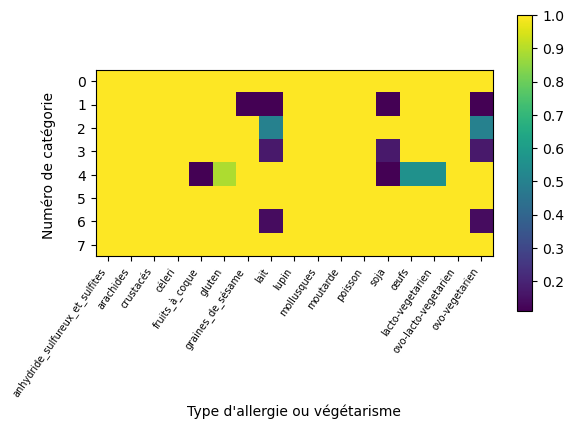

In [193]:
# REprésentation heatmap du diagnostic des aliments porblématiques par catégorie, en cas d'allergie ou de végétarisme

with open("conformity_new.pickle", "rb") as fichier:
    data = pickle.load(fichier)

rows = sorted(data.keys())
# print(rows)
cols = sorted(data[rows[0]].keys())
print(cols)
cols.remove('profile-vegetalien')
matrix = np.array([[data[row][col] for col in cols] for row in rows])
plt.imshow(matrix, cmap='viridis', interpolation='nearest')

cols = [col.replace("profile-", "") for col in cols]
cols = [col.replace("allergique-", "") for col in cols]
plt.xticks(np.arange(len(cols)), cols)
plt.yticks(np.arange(len(rows)), rows)
plt.tick_params(axis='x', labelsize=7)
plt.xticks(rotation=55, ha='right')
plt.xlabel("Type d'allergie ou végétarisme")
plt.ylabel("Numéro de catégorie \n")
# plt.subplots_adjust(bottom=0.2) 

# Ajoutez une barre de couleur pour représenter les valeurs
plt.colorbar(shrink=0.8)

# Affichez la heatmap
plt.show()

